# โมเดลทำนายโรคหัวใจ (Heart Disease Prediction Models)
# by Orgin

โน้ตบุ๊กนี้ใช้สำหรับฝึกและประเมินโมเดลหลายประเภทเพื่อทำนายโรคหัวใจ โดยใช้ข้อมูลที่ผ่านการ impute ค่าที่หายไปแล้ว

## โครงสร้าง

1. การตั้งค่าเริ่มต้น
   - Import libraries
   - โหลดข้อมูล train/test
   - สร้างโฟลเดอร์สำหรับเก็บโมเดล
   - กำหนดค่าพารามิเตอร์ (n_runs, etc.)

2. ฟังก์ชันสนับสนุน
   - log_final_run_metrics: คำนวณและแสดงผลการประเมินโมเดล
   - save_run_metrics: บันทึกผลลัพธ์แต่ละรัน
   - save_model: บันทึกโมเดลลงไฟล์

3. การฝึกโมเดล (n_runs=5 รอบต่อโมเดล)
   - Logistic Regression
   - Random Forest (พร้อม feature importance)
   - EBM (Explainable Boosting Machine)
   - SVM (Support Vector Machine)
   - XGBoost (พร้อม bootstrap และ feature importance)
   - DNN (Deep Neural Network)

4. การรวมโมเดล (Model Combination)
   - โหลดโมเดลที่บันทึกไว้
   - Ensemble แบบ average probabilities
   - Ensemble แบบ majority vote
   - Stacking meta-learner (OOF)

# Train / Test models (from preprocessed imput data)
ในเซลล์ถัดไปจะมีการนำเข้าไลบรารีที่จำเป็น ฟังก์ชันวัดผล แล้วโหลดไฟล์ train/test ที่เราเซฟไว้ก่อนหน้า จากนั้นจะฝึกโมเดลหลายตัว (n_runs = 5)

## 1. การตั้งค่าเริ่มต้น (Setup)

### 1.1 Import Libraries
นำเข้าไลบรารีที่จำเป็นสำหรับการสร้างและประเมินโมเดล:
- pandas, numpy: สำหรับจัดการข้อมูล
- matplotlib, seaborn: สำหรับการพล็อตกราฟ
- sklearn: สำหรับโมเดล ML พื้นฐาน
- interpret: สำหรับ EBM
- xgboost: สำหรับ XGBoost
- keras: สำหรับ Deep Neural Network
- joblib: สำหรับบันทึก/โหลดโมเดล

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from xgboost import XGBClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, learning_curve, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import joblib
import os, json
print(os.getcwd())
import pandas as pd
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score,
    hamming_loss, zero_one_loss, log_loss, brier_score_loss,
    precision_recall_curve, average_precision_score, roc_curve, auc
)

/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/imput/G1_Original


In [2]:
data_train = pd.read_csv('/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/data/heart_disease_preprocessed_imput_train.csv')
data_train

Gender_Male  Gender_Female  Smoking_No  Smoking_Yes  \
0             0.0            0.0         1.0         -1.0   
1            -1.0            1.0         1.0         -1.0   
2            -1.0            1.0         0.0          0.0   
3             0.0            0.0         0.0          0.0   
4            -1.0            1.0         1.0         -1.0   
...           ...            ...         ...          ...   
7995         -1.0            1.0         0.0          0.0   
7996         -1.0            1.0         1.0         -1.0   
7997          0.0            0.0         0.0          0.0   
7998         -1.0            1.0         1.0         -1.0   
7999         -1.0            1.0         0.0          0.0   

      Family Heart Disease_No  Family Heart Disease_Yes  Diabetes_No  \
0                        -1.0                       1.0          0.0   
1                         0.0                       0.0          0.0   
2                        -1.0                       1.0         -1.0   
3                         0.0                       0.0         -1.0   
4                        -1.0                       1.0          0.0   
...                       ...                       ...          ...   
7995                      0.0                       0.0         -1.0   
7996                      0.0                       0.0         -1.0   
7997                      0.0                       0.0          0.0   
7998                      0.0                       0.0          0.0   
7999                     -1.0                       1.0          0.0   

      Diabetes_Yes  High Blood Pressure_No  High Blood Pressure_Yes  ...  \
0              0.0                     0.0                      0.0  ...   
1              0.0                     1.0                     -1.0  ...   
2              1.0                     0.0                      0.0  ...   
3              1.0                     1.0                     -1.0  ...   
4              0.0                     1.0                     -1.0  ...   
...            ...                     ...                      ...  ...   
7995           1.0                     0.0                      0.0  ...   
7996           1.0                     1.0                     -1.0  ...   
7997           0.0                     0.0                      0.0  ...   
7998           0.0                     1.0                     -1.0  ...   
7999           0.0                     0.0                      0.0  ...   

           Age  Blood Pressure  Cholesterol Level       BMI  Sleep Hours  \
0    -0.967742        0.806452           0.612526 -0.018123     0.760242   
1    -0.870968       -0.870968          -0.729579  0.108841    -0.009194   
2    -0.129032        0.258065          -0.703263  0.451024     0.633356   
3    -0.645161       -0.225806           0.875684 -0.692829     0.927827   
4    -0.096774       -0.483871          -0.019053 -0.074256     0.313956   
...        ...             ...                ...       ...          ...   
7995 -0.774194        0.096774           0.967789  0.983111     0.722989   
7996 -0.129032       -0.322581           0.000012  0.863420    -0.305438   
7997 -0.129032       -0.322581          -0.176947 -0.596459     0.915130   
7998 -0.290323        0.903226           0.744105 -0.057397    -0.594951   
7999  0.258065       -0.903226           0.744105 -0.096738    -0.105488   

      Triglyceride Level  Fasting Blood Sugar  CRP Level  Homocysteine Level  \
0              -0.331531             0.928571  -0.217432            0.749543   
1               0.561802             0.047619  -0.563436           -0.642523   
2               0.841802            -0.261905   0.770134            0.989293   
3               0.795136             0.006073  -0.896355            0.043466   
4               0.668469             0.690476   0.454549            0.780983   
...                  ...                  ...        ...                 ...   
7995            0.9351

In [3]:
data_test  = pd.read_csv('/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/data/heart_disease_preprocessed_imput_test.csv')
data_test

Gender_Male  Gender_Female  Smoking_No  Smoking_Yes  \
0             0.0            0.0         0.0          0.0   
1             0.0            0.0         1.0         -1.0   
2             0.0            0.0         1.0         -1.0   
3             0.0            0.0         0.0          0.0   
4            -1.0            1.0         1.0         -1.0   
...           ...            ...         ...          ...   
1995          0.0            0.0         0.0          0.0   
1996          0.0            0.0         0.0          0.0   
1997         -1.0            1.0         0.0          0.0   
1998         -1.0            1.0         0.0          0.0   
1999          0.0            0.0         0.0          0.0   

      Family Heart Disease_No  Family Heart Disease_Yes  Diabetes_No  \
0                         0.0                       0.0         -1.0   
1                         0.0                       0.0         -1.0   
2                         0.0                       0.0         -1.0   
3                        -1.0                       1.0          0.0   
4                        -1.0                       1.0         -1.0   
...                       ...                       ...          ...   
1995                      0.0                       0.0          0.0   
1996                      0.0                       0.0          0.0   
1997                      0.0                       0.0         -1.0   
1998                      0.0                       0.0          0.0   
1999                     -1.0                       1.0         -1.0   

      Diabetes_Yes  High Blood Pressure_No  High Blood Pressure_Yes  ...  \
0              1.0                     0.0                      0.0  ...   
1              1.0                     1.0                     -1.0  ...   
2              1.0                     1.0                     -1.0  ...   
3              0.0                     0.0                      0.0  ...   
4              1.0                     0.0                      0.0  ...   
...            ...                     ...                      ...  ...   
1995           0.0                     0.0                      0.0  ...   
1996           0.0                     1.0                     -1.0  ...   
1997           1.0                     0.0                      0.0  ...   
1998           0.0                     0.0                      0.0  ...   
1999           1.0                     0.0                      0.0  ...   

           Age  Blood Pressure  Cholesterol Level       BMI  Sleep Hours  \
0     0.451613       -0.645161           0.112526  0.830412     0.605291   
1     0.129032       -0.903226           0.007263 -0.321051    -0.371821   
2    -0.935484       -0.354839           0.046737 -0.962751     0.850361   
3    -0.129032        0.838710           0.073053 -0.678870    -0.295235   
4    -0.870968        0.709677          -0.979579  0.213048    -0.300161   
...        ...             ...                ...       ...          ...   
1995  0.741935        0.032258          -0.255895  0.347660     0.933001   
1996  0.677419        0.612903           0.388842  0.287665     0.918022   
1997 -0.677419       -0.451613          -0.637474  0.050581    -0.731032   
1998 -0.483871       -0.580645          -0.637474 -0.233702     0.085528   
1999  0.129032       -0.483871          -0.795369 -0.837405     0.180965   

      Triglyceride Level  Fasting Blood Sugar  CRP Level  Homocysteine Level  \
0               0.221802             0.000000  -0.093568            0.423311   
1              -0.438198            -0.095238   0.624742            0.595734   
2               0.808469            -0.571429   0.360814           -0.243791   
3               0.781802            -0.261905  -0.124976            0.688098   
4               0.535136            -0.285714   0.797776           -0.788947   
...                  ...                  ...        ...                 ...   
1995           -0.7181

In [4]:
# Create directories for models and results
base_path = '/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE'
model_dir = os.path.join(base_path, 'model', 'imput')
os.makedirs(model_dir, exist_ok=True)
print(f'Created model directory: {model_dir}')

Created model directory: /Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/model/imput


In [5]:
label_col = 'Heart Disease Status'
X_train = data_train.drop(columns=[label_col])
y_train = data_train[label_col]
X_test  = data_test.drop(columns=[label_col])
y_test  = data_test[label_col]

if y_train.dtype.kind not in "biu":
    map_ = {'No': 0, 'Yes': 1}  # ปรับ mapping ให้ตรงชุดข้อมูลจริง
    y_train = y_train.map(map_)
    y_test  = y_test.map(map_)
    assert set(y_train.dropna().unique()) <= {0,1} and set(y_test.dropna().unique()) <= {0,1}, \
        "Label mapping ไม่เป็น 0/1 ตรวจค่า label อีกครั้งนะคะ"
    y_train = y_train.astype(int)
    y_test  = y_test.astype(int)

print('Loaded train:', data_train.shape, ' test:', data_test.shape)
print('Train label counts:\n', y_train.value_counts())
print('Test  label counts:\n', y_test.value_counts())

Loaded train: (8000, 28)  test: (2000, 28)
Train label counts:
 Heart Disease Status
0    6400
1    1600
Name: count, dtype: int64
Test  label counts:
 Heart Disease Status
0    1600
1     400
Name: count, dtype: int64


In [6]:
# Settings
n_runs = 5
model_dir = "imput"              # ที่เก็บโมเดล/ไฟล์สรุป
os.makedirs(model_dir, exist_ok=True)
results = {
    'Logistic Regression': {'train': [], 'test': []},
    'Random Forest': {'train': [], 'test': []},
    'EBM': {'train': [], 'test': []},
    'SVM': {'train': [], 'test': []},
    'XGBoost': {'train': [], 'test': []},
    'DNN': {'train': [], 'test': []},
}
roc_data = {}
detailed_metrics = [] 

In [7]:
# ---------------- Helpers ----------------
def get_pos_proba_from_estimator(estimator, X):
    """คืน prob ของคลาส 1 ถ้ามี; ถ้าไม่มีจะลอง decision_function -> sigmoid; ไม่งั้น None"""
    if hasattr(estimator, "predict_proba"):
        p = estimator.predict_proba(X)
        return p[:, 1] if p.ndim == 2 and p.shape[1] >= 2 else None
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        return 1.0 / (1.0 + np.exp(-s))
    return None

def save_run_metrics(model_name, run, metrics, *, split=None, params=None, model_path=None, is_final=False):
    row = {
        'model': model_name, 'run': run, 'split': split, 'is_final': is_final,
        'model_path': model_path, **(params or {}), **metrics
    }
    detailed_metrics.append(row)
    return row

def save_model(model_name, model, is_dnn=False):
    if is_dnn:
        path = os.path.join(model_dir, f"{model_name.lower().replace(' ', '_')}.h5")
        model.save(path)
    else:
        path = os.path.join(model_dir, f"{model_name.lower().replace(' ', '_')}.joblib")
        joblib.dump(model, path)
    print(f"Saved model: {path}")
    return path

def update_results_scalar(results, model_name, split, metrics_row, key="f1"):
    val = metrics_row.get(key)
    if val is not None:
        results[model_name][split].append(val)

def log_final_run_metrics(
    model_name,
    y_true,
    y_pred,
    y_prob,
    roc_data_dict,
    *,
    split=None,      # 'train' | 'test'
    run=None,        # run index
    params=None      # dict ของ best_params_ หรือ config
):
    print(f"\n=== Final-Run Metrics: {model_name}" + (f" [{split}]" if split else "") + " ===")
    acc = accuracy_score(y_true, y_pred)
    err_rate = 1.0 - acc
    print(f"Accuracy: {acc:.4f}")
    print(f"Error rate (1-Acc): {err_rate:.4f}")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("Confusion Matrix [rows=true, cols=pred]:")
    print(cm)

    tn, fp, fn, tp = cm.ravel()
    eps = 1e-12
    sensitivity   = tp / (tp + fn + eps)   # recall+
    specificity   = tn / (tn + fp + eps)
    precision_pos = tp / (tp + fp + eps)   # PPV
    npv           = tn / (tn + fn + eps)
    fprate        = fp / (fp + tn + eps)
    fnrate        = fn / (fn + tp + eps)
    f1            = f1_score(y_true, y_pred, zero_division=0)

    mcc     = matthews_corrcoef(y_true, y_pred)
    kappa   = cohen_kappa_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    h_loss  = hamming_loss(y_true, y_pred)
    z1_loss = zero_one_loss(y_true, y_pred)

    support_pos = tp + fn
    support_neg = tn + fp
    prevalence_pos = support_pos / (support_pos + support_neg + eps)
    pred_pos_rate = (tp + fp) / (support_pos + support_neg + eps)
    youden_j = sensitivity + specificity - 1

    print(f"Sensitivity (Recall+): {sensitivity:.4f} | Specificity: {specificity:.4f}")
    print(f"Precision (PPV): {precision_pos:.4f} | NPV: {npv:.4f}")
    print(f"FPR: {fprate:.4f} | FNR: {fnrate:.4f} | F1: {f1:.4f}")
    print(f"MCC: {mcc:.4f} | Cohen's kappa: {kappa:.4f} | Balanced Acc: {bal_acc:.4f}")
    print(f"Hamming loss: {h_loss:.4f} | Zero-One loss: {z1_loss:.4f}")
    print(f"Prevalence+: {prevalence_pos:.4f} | Pred+ rate: {pred_pos_rate:.4f} | Youden J: {youden_j:.4f}")

    # Prob-based
    ll = brier = ap = roc_auc = None
    if y_prob is not None:
        try:
            ll    = float(log_loss(y_true, y_prob))
            brier = float(brier_score_loss(y_true, y_prob))
            prec, rec, _ = precision_recall_curve(y_true, y_prob)
            ap    = float(average_precision_score(y_true, y_prob))
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = float(auc(fpr, tpr))
            if roc_data_dict is not None:
                key = f"{model_name}" + (f"_{split}" if split else "") + (f"_run{run:02d}" if run is not None else "")
                roc_data_dict[key] = (fpr, tpr, roc_auc)
            print(f"Log Loss: {ll:.4f} | Brier score: {brier:.4f} | Average Precision (PR-AUC): {ap:.4f} | ROC-AUC: {roc_auc:.4f}")
        except ValueError:
            print("ข้าม LogLoss/Brier/PR-AUC/ROC: โปรดตรวจว่า y_prob เป็น probability ของคลาส 1")

    return {
        'run': run, 'model': model_name, 'split': split, **(params or {}),
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
        'support_pos': int(support_pos), 'support_neg': int(support_neg),
        'prevalence_pos': float(prevalence_pos),
        'pred_pos_rate': float(pred_pos_rate),
        'youden_j': float(youden_j),
        'accuracy': float(acc),
        'error_rate': float(err_rate),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'precision_pos': float(precision_pos),
        'npv': float(npv),
        'fpr': float(fprate),
        'fnr': float(fnrate),
        'f1': float(f1),
        'mcc': float(mcc),
        'kappa': float(kappa),
        'balanced_accuracy': float(bal_acc),
        'hamming_loss': float(h_loss),
        'zero_one_loss': float(z1_loss),
        'log_loss': ll,
        'brier': brier,
        'avg_precision': ap,
        'roc_auc': roc_auc,
    }

def plot_cm_and_save(y_true, y_pred, title, out_path, normalize=False):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if normalize:
        denom = cm.sum(axis=1, keepdims=True).clip(min=1)
        cm_disp = cm.astype(float) / denom
    else:
        cm_disp = cm

    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm_disp, interpolation='nearest', cmap='Blues')
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels([0,1]); ax.set_yticklabels([0,1])
    fmt = ".2f" if normalize else "d"
    for (i, j), v in np.ndenumerate(cm_disp):
        ax.text(j, i, format(v, fmt), ha='center', va='center', fontsize=11)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()
    return cm


In [8]:
# ---------------- Class distribution (log) ----------------
print("\n[INFO] Class distribution (normalized)")
try:
    print("TRAIN:\n", y_train.value_counts(normalize=True))
    print("TEST:\n",  y_test.value_counts(normalize=True))
except Exception:
    def _dist(y):
        vals, cnts = np.unique(y, return_counts=True)
        return {int(v): c/len(y) for v, c in zip(vals, cnts)}
    print("TRAIN:", _dist(y_train)); print("TEST :", _dist(y_test))



[INFO] Class distribution (normalized)
TRAIN:
 Heart Disease Status
0    0.8
1    0.2
Name: proportion, dtype: float64
TEST:
 Heart Disease Status
0    0.8
1    0.2
Name: proportion, dtype: float64



[Logistic Regression] Run 1/5

Searching best parameters...
Fitting 5 folds for each of 112 candidates, totalling 560 fits


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parame


Best parameters: {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}

Scores for best parameters (CV mean):
ACC : 0.4376
PREC: 0.2022
REC : 0.6150
F1  : 0.3027
AUC : 0.5050

=== Final-Run Metrics: Logistic Regression [train] ===
Accuracy: 0.4467
Error rate (1-Acc): 0.5533
Classification Report:
              precision    recall  f1-score   support

           0     0.8176    0.3970    0.5345      6400
           1     0.2112    0.6456    0.3182      1600

    accuracy                         0.4467      8000
   macro avg     0.5144    0.5213    0.4264      8000
weighted avg     0.6963    0.4467    0.4912      8000

Confusion Matrix [rows=true, cols=pred]:
[[2541 3859]
 [ 567 1033]]
Sensitivity (Recall+): 0.6456 | Specificity: 0.3970
Precision (PPV): 0.2112 | NPV: 0.8176
FPR: 0.6030 | FNR: 0.3544 | F1: 0.3182
MCC: 0.0350 | Cohen's kappa: 0.0241 | Balanced Acc: 0.5213
Hamming loss: 0.5533 | Zero-One loss: 0.5533
Prevale

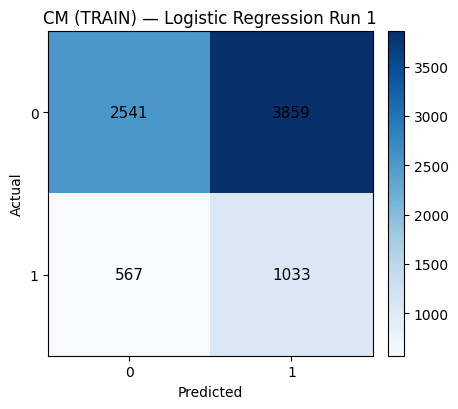

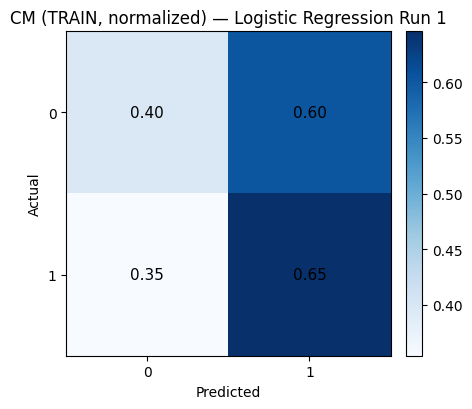


=== Final-Run Metrics: Logistic Regression [test] ===
Accuracy: 0.4340
Error rate (1-Acc): 0.5660
Classification Report:
              precision    recall  f1-score   support

           0     0.7779    0.4094    0.5364      1600
           1     0.1839    0.5325    0.2734       400

    accuracy                         0.4340      2000
   macro avg     0.4809    0.4709    0.4049      2000
weighted avg     0.6591    0.4340    0.4838      2000

Confusion Matrix [rows=true, cols=pred]:
[[655 945]
 [187 213]]
Sensitivity (Recall+): 0.5325 | Specificity: 0.4094
Precision (PPV): 0.1839 | NPV: 0.7779
FPR: 0.5906 | FNR: 0.4675 | F1: 0.2734
MCC: -0.0471 | Cohen's kappa: -0.0340 | Balanced Acc: 0.4709
Hamming loss: 0.5660 | Zero-One loss: 0.5660
Prevalence+: 0.2000 | Pred+ rate: 0.5790 | Youden J: -0.0581
Log Loss: 0.6940 | Brier score: 0.2504 | Average Precision (PR-AUC): 0.1860 | ROC-AUC: 0.4725


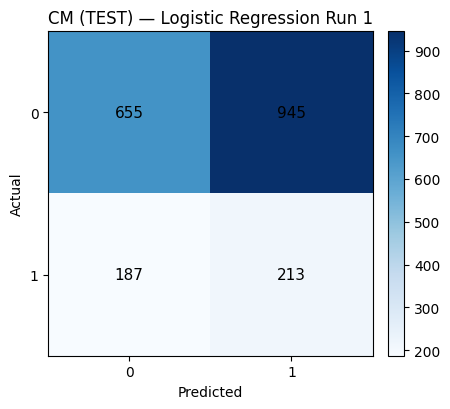

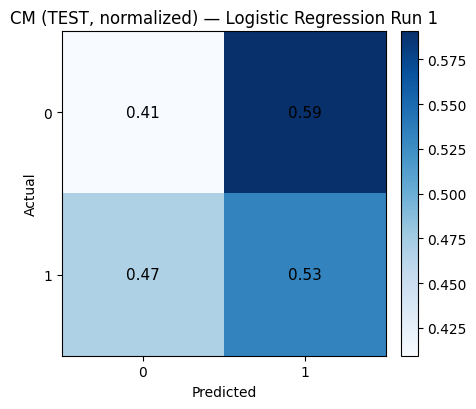

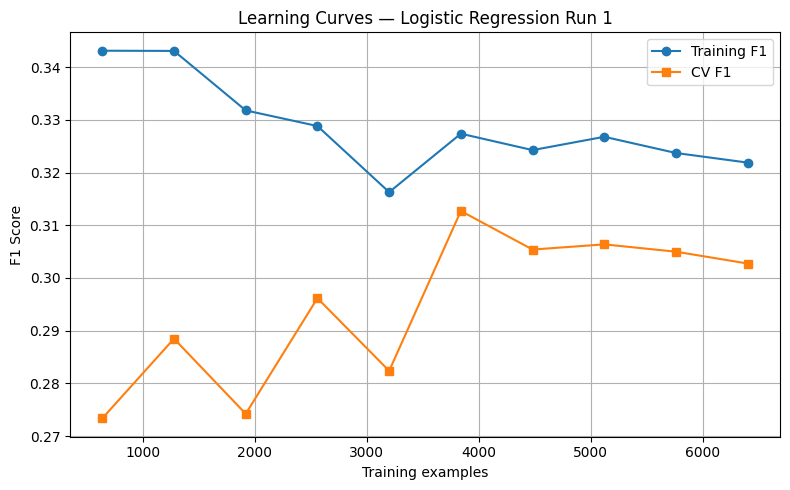

Saved model: imput/logistic_regression.joblib

[Logistic Regression] Run 2/5

Searching best parameters...
Fitting 5 folds for each of 112 candidates, totalling 560 fits


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parame


Best parameters: {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}

Scores for best parameters (CV mean):
ACC : 0.4429
PREC: 0.2000
REC : 0.5944
F1  : 0.2971
AUC : 0.4986

=== Final-Run Metrics: Logistic Regression [train] ===
Accuracy: 0.4467
Error rate (1-Acc): 0.5533
Classification Report:
              precision    recall  f1-score   support

           0     0.8176    0.3970    0.5345      6400
           1     0.2112    0.6456    0.3182      1600

    accuracy                         0.4467      8000
   macro avg     0.5144    0.5213    0.4264      8000
weighted avg     0.6963    0.4467    0.4912      8000

Confusion Matrix [rows=true, cols=pred]:
[[2541 3859]
 [ 567 1033]]
Sensitivity (Recall+): 0.6456 | Specificity: 0.3970
Precision (PPV): 0.2112 | NPV: 0.8176
FPR: 0.6030 | FNR: 0.3544 | F1: 0.3182
MCC: 0.0350 | Cohen's kappa: 0.0241 | Balanced Acc: 0.5213
Hamming loss: 0.5533 | Zero-One loss: 0.5533
Prevale

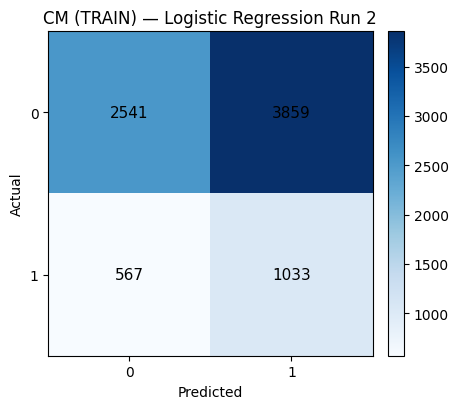

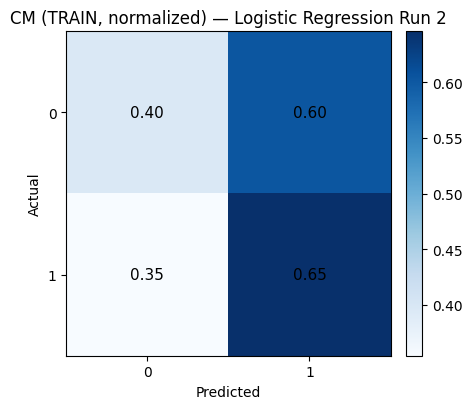


=== Final-Run Metrics: Logistic Regression [test] ===
Accuracy: 0.4340
Error rate (1-Acc): 0.5660
Classification Report:
              precision    recall  f1-score   support

           0     0.7779    0.4094    0.5364      1600
           1     0.1839    0.5325    0.2734       400

    accuracy                         0.4340      2000
   macro avg     0.4809    0.4709    0.4049      2000
weighted avg     0.6591    0.4340    0.4838      2000

Confusion Matrix [rows=true, cols=pred]:
[[655 945]
 [187 213]]
Sensitivity (Recall+): 0.5325 | Specificity: 0.4094
Precision (PPV): 0.1839 | NPV: 0.7779
FPR: 0.5906 | FNR: 0.4675 | F1: 0.2734
MCC: -0.0471 | Cohen's kappa: -0.0340 | Balanced Acc: 0.4709
Hamming loss: 0.5660 | Zero-One loss: 0.5660
Prevalence+: 0.2000 | Pred+ rate: 0.5790 | Youden J: -0.0581
Log Loss: 0.6940 | Brier score: 0.2504 | Average Precision (PR-AUC): 0.1860 | ROC-AUC: 0.4725


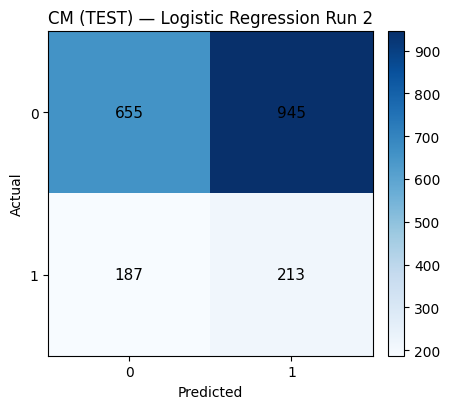

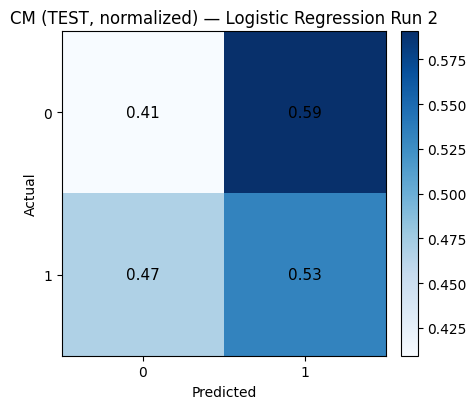

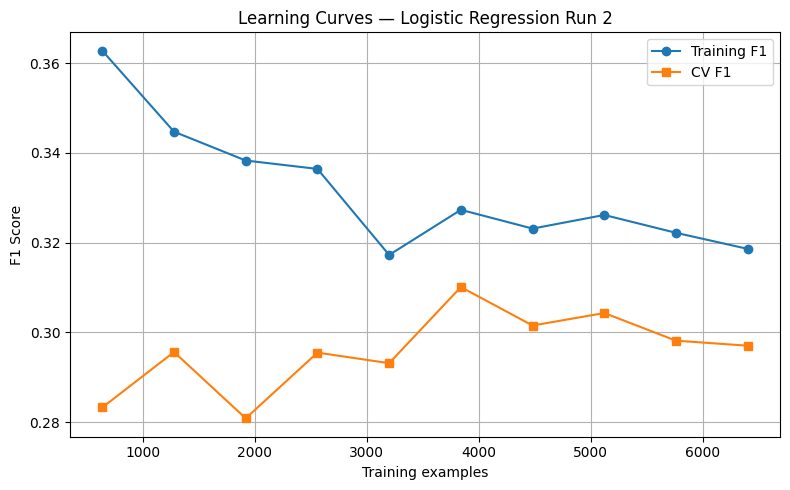

Saved model: imput/logistic_regression.joblib

[Logistic Regression] Run 3/5

Searching best parameters...
Fitting 5 folds for each of 112 candidates, totalling 560 fits


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parame


Best parameters: {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}

Scores for best parameters (CV mean):
ACC : 0.4355
PREC: 0.1991
REC : 0.6031
F1  : 0.2982
AUC : 0.5053

=== Final-Run Metrics: Logistic Regression [train] ===
Accuracy: 0.4467
Error rate (1-Acc): 0.5533
Classification Report:
              precision    recall  f1-score   support

           0     0.8176    0.3970    0.5345      6400
           1     0.2112    0.6456    0.3182      1600

    accuracy                         0.4467      8000
   macro avg     0.5144    0.5213    0.4264      8000
weighted avg     0.6963    0.4467    0.4912      8000

Confusion Matrix [rows=true, cols=pred]:
[[2541 3859]
 [ 567 1033]]
Sensitivity (Recall+): 0.6456 | Specificity: 0.3970
Precision (PPV): 0.2112 | NPV: 0.8176
FPR: 0.6030 | FNR: 0.3544 | F1: 0.3182
MCC: 0.0350 | Cohen's kappa: 0.0241 | Balanced Acc: 0.5213
Hamming loss: 0.5533 | Zero-One loss: 0.5533
Prevale

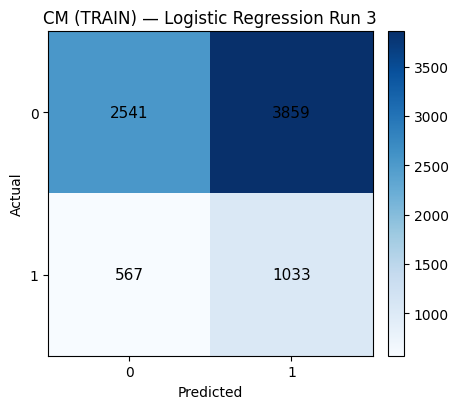

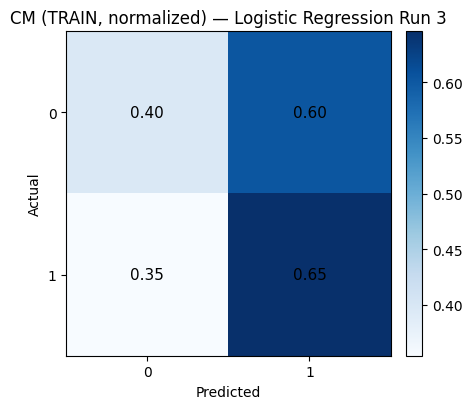


=== Final-Run Metrics: Logistic Regression [test] ===
Accuracy: 0.4340
Error rate (1-Acc): 0.5660
Classification Report:
              precision    recall  f1-score   support

           0     0.7779    0.4094    0.5364      1600
           1     0.1839    0.5325    0.2734       400

    accuracy                         0.4340      2000
   macro avg     0.4809    0.4709    0.4049      2000
weighted avg     0.6591    0.4340    0.4838      2000

Confusion Matrix [rows=true, cols=pred]:
[[655 945]
 [187 213]]
Sensitivity (Recall+): 0.5325 | Specificity: 0.4094
Precision (PPV): 0.1839 | NPV: 0.7779
FPR: 0.5906 | FNR: 0.4675 | F1: 0.2734
MCC: -0.0471 | Cohen's kappa: -0.0340 | Balanced Acc: 0.4709
Hamming loss: 0.5660 | Zero-One loss: 0.5660
Prevalence+: 0.2000 | Pred+ rate: 0.5790 | Youden J: -0.0581
Log Loss: 0.6940 | Brier score: 0.2504 | Average Precision (PR-AUC): 0.1860 | ROC-AUC: 0.4725


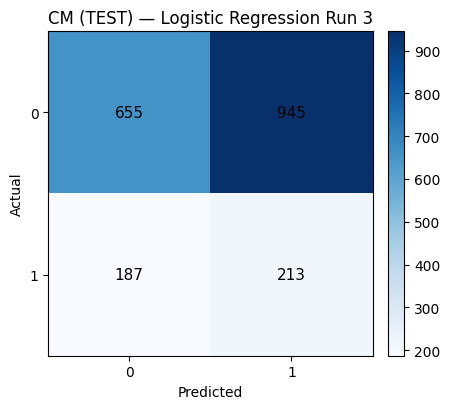

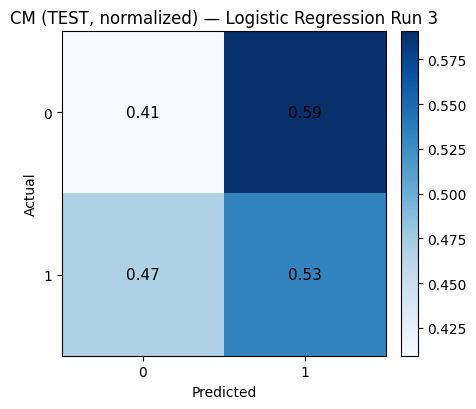

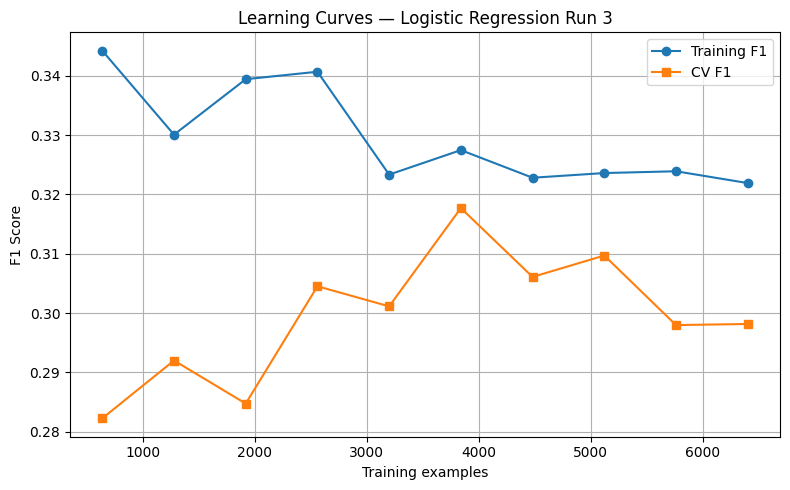

Saved model: imput/logistic_regression.joblib

[Logistic Regression] Run 4/5

Searching best parameters...
Fitting 5 folds for each of 112 candidates, totalling 560 fits


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parame


Best parameters: {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}

Scores for best parameters (CV mean):
ACC : 0.4351
PREC: 0.2011
REC : 0.6175
F1  : 0.3014
AUC : 0.5061

=== Final-Run Metrics: Logistic Regression [train] ===
Accuracy: 0.4467
Error rate (1-Acc): 0.5533
Classification Report:
              precision    recall  f1-score   support

           0     0.8176    0.3970    0.5345      6400
           1     0.2112    0.6456    0.3182      1600

    accuracy                         0.4467      8000
   macro avg     0.5144    0.5213    0.4264      8000
weighted avg     0.6963    0.4467    0.4912      8000

Confusion Matrix [rows=true, cols=pred]:
[[2541 3859]
 [ 567 1033]]
Sensitivity (Recall+): 0.6456 | Specificity: 0.3970
Precision (PPV): 0.2112 | NPV: 0.8176
FPR: 0.6030 | FNR: 0.3544 | F1: 0.3182
MCC: 0.0350 | Cohen's kappa: 0.0241 | Balanced Acc: 0.5213
Hamming loss: 0.5533 | Zero-One loss: 0.5533
Prevale

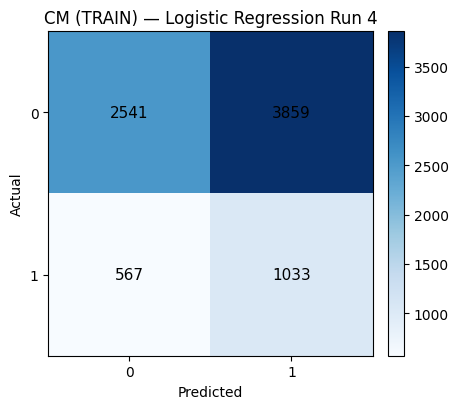

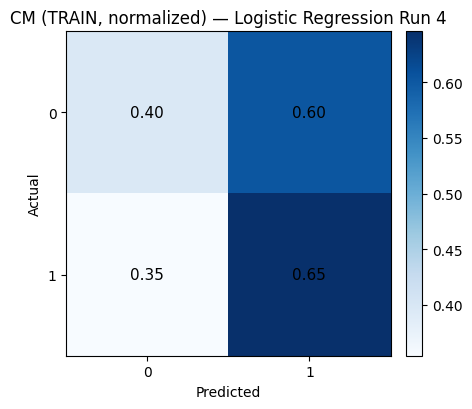


=== Final-Run Metrics: Logistic Regression [test] ===
Accuracy: 0.4340
Error rate (1-Acc): 0.5660
Classification Report:
              precision    recall  f1-score   support

           0     0.7779    0.4094    0.5364      1600
           1     0.1839    0.5325    0.2734       400

    accuracy                         0.4340      2000
   macro avg     0.4809    0.4709    0.4049      2000
weighted avg     0.6591    0.4340    0.4838      2000

Confusion Matrix [rows=true, cols=pred]:
[[655 945]
 [187 213]]
Sensitivity (Recall+): 0.5325 | Specificity: 0.4094
Precision (PPV): 0.1839 | NPV: 0.7779
FPR: 0.5906 | FNR: 0.4675 | F1: 0.2734
MCC: -0.0471 | Cohen's kappa: -0.0340 | Balanced Acc: 0.4709
Hamming loss: 0.5660 | Zero-One loss: 0.5660
Prevalence+: 0.2000 | Pred+ rate: 0.5790 | Youden J: -0.0581
Log Loss: 0.6940 | Brier score: 0.2504 | Average Precision (PR-AUC): 0.1860 | ROC-AUC: 0.4725


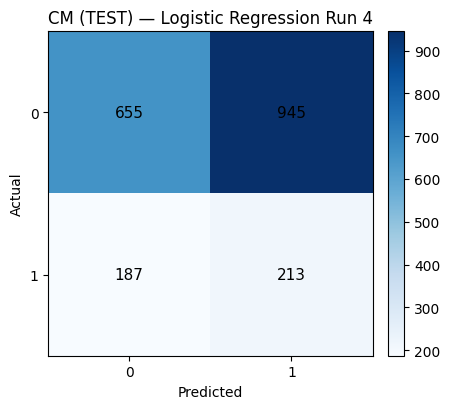

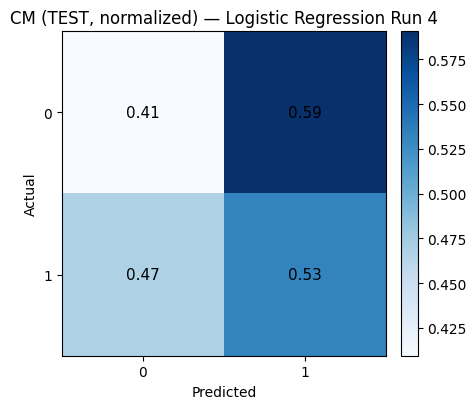

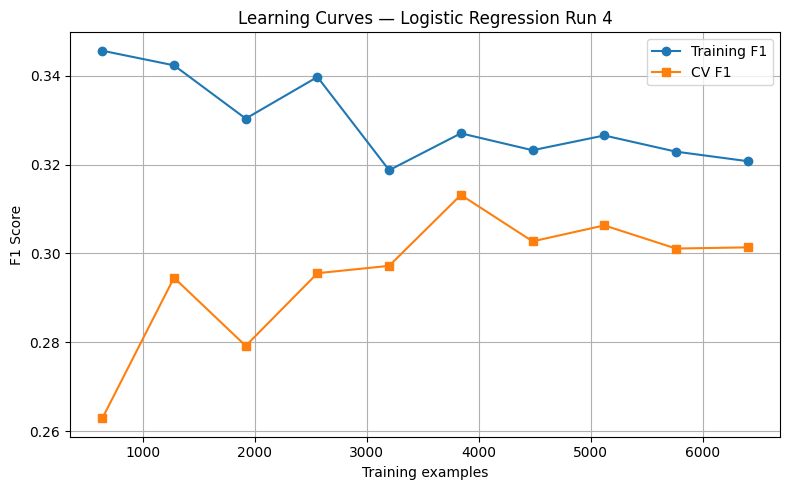

Saved model: imput/logistic_regression.joblib

[Logistic Regression] Run 5/5

Searching best parameters...
Fitting 5 folds for each of 112 candidates, totalling 560 fits


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parame


Best parameters: {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}

Scores for best parameters (CV mean):
ACC : 0.4377
PREC: 0.2033
REC : 0.6200
F1  : 0.3057
AUC : 0.5126

=== Final-Run Metrics: Logistic Regression [train] ===
Accuracy: 0.4467
Error rate (1-Acc): 0.5533
Classification Report:
              precision    recall  f1-score   support

           0     0.8176    0.3970    0.5345      6400
           1     0.2112    0.6456    0.3182      1600

    accuracy                         0.4467      8000
   macro avg     0.5144    0.5213    0.4264      8000
weighted avg     0.6963    0.4467    0.4912      8000

Confusion Matrix [rows=true, cols=pred]:
[[2541 3859]
 [ 567 1033]]
Sensitivity (Recall+): 0.6456 | Specificity: 0.3970
Precision (PPV): 0.2112 | NPV: 0.8176
FPR: 0.6030 | FNR: 0.3544 | F1: 0.3182
MCC: 0.0350 | Cohen's kappa: 0.0241 | Balanced Acc: 0.5213
Hamming loss: 0.5533 | Zero-One loss: 0.5533
Prevale

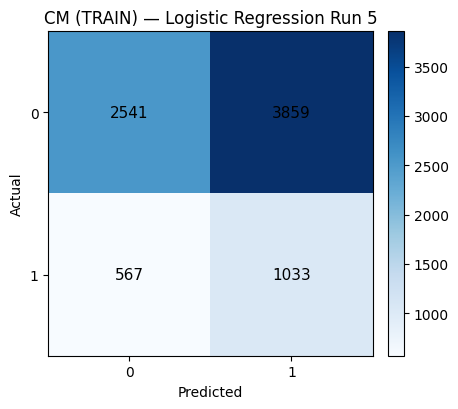

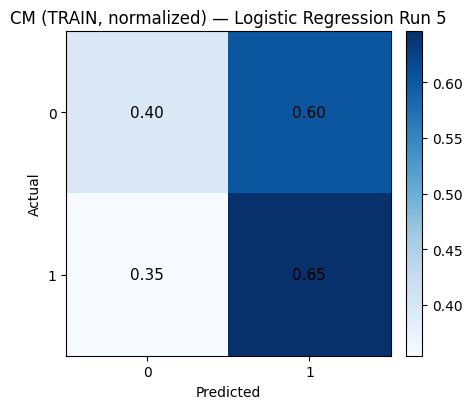


=== Final-Run Metrics: Logistic Regression [test] ===
Accuracy: 0.4340
Error rate (1-Acc): 0.5660
Classification Report:
              precision    recall  f1-score   support

           0     0.7779    0.4094    0.5364      1600
           1     0.1839    0.5325    0.2734       400

    accuracy                         0.4340      2000
   macro avg     0.4809    0.4709    0.4049      2000
weighted avg     0.6591    0.4340    0.4838      2000

Confusion Matrix [rows=true, cols=pred]:
[[655 945]
 [187 213]]
Sensitivity (Recall+): 0.5325 | Specificity: 0.4094
Precision (PPV): 0.1839 | NPV: 0.7779
FPR: 0.5906 | FNR: 0.4675 | F1: 0.2734
MCC: -0.0471 | Cohen's kappa: -0.0340 | Balanced Acc: 0.4709
Hamming loss: 0.5660 | Zero-One loss: 0.5660
Prevalence+: 0.2000 | Pred+ rate: 0.5790 | Youden J: -0.0581
Log Loss: 0.6940 | Brier score: 0.2504 | Average Precision (PR-AUC): 0.1860 | ROC-AUC: 0.4725


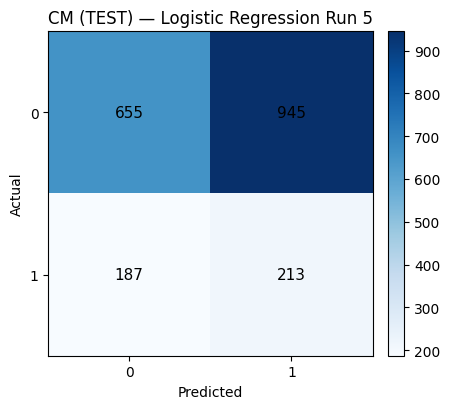

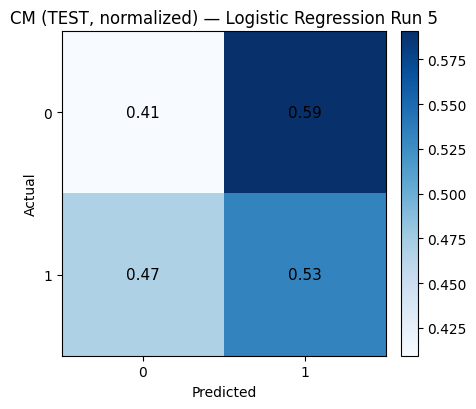

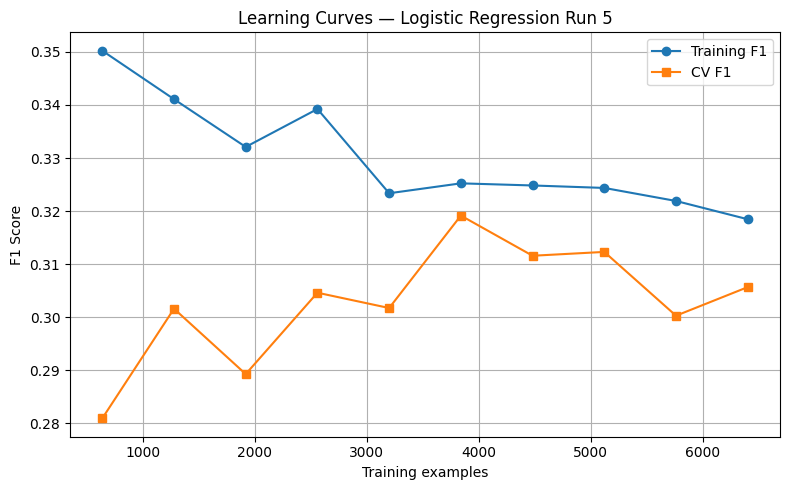

Saved model: imput/logistic_regression.joblib

F1 summary (Logistic only):
                 model  split  n_runs  mean_f1  std_f1  min_f1  max_f1
1  Logistic Regression   test       5   0.2734     0.0  0.2734  0.2734
0  Logistic Regression  train       5   0.3182     0.0  0.3182  0.3182


In [9]:
# ================== Logistic Regression (patched) ==================

MODEL_NAME = "Logistic Regression"

param_grid_lr = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None, {0: 1, 1: 2}, {0: 1, 1: 3}],
    'max_iter': [5000],
    'solver': ['liblinear', 'saga'],
    'random_state': [42],
}

for run in range(1, n_runs + 1):
    print("\n" + "="*70)
    print(f"[{MODEL_NAME}] Run {run}/{n_runs}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + run)

    grid = GridSearchCV(
        estimator=LogisticRegression(),
        param_grid=param_grid_lr,
        cv=skf,
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        refit='f1',
        n_jobs=-1,
        verbose=1
    )

    print("\nSearching best parameters...")
    grid.fit(X_train, y_train)
    best_est = grid.best_estimator_
    best_params = grid.best_params_
    bi = grid.best_index_

    print("\nBest parameters:", best_params)
    print("\nScores for best parameters (CV mean):")
    print(f"ACC : {grid.cv_results_['mean_test_accuracy'][bi]:.4f}")
    print(f"PREC: {grid.cv_results_['mean_test_precision'][bi]:.4f}")
    print(f"REC : {grid.cv_results_['mean_test_recall'][bi]:.4f}")
    print(f"F1  : {grid.cv_results_['mean_test_f1'][bi]:.4f}")
    print(f"AUC : {grid.cv_results_['mean_test_roc_auc'][bi]:.4f}")

    # ----- TRAIN -----
    y_tr_pred = best_est.predict(X_train)
    y_tr_prob = get_pos_proba_from_estimator(best_est, X_train)

    tr_metrics = log_final_run_metrics(
        MODEL_NAME, y_train, y_tr_pred, y_tr_prob, roc_data,
        split="train", run=run, params=best_params
    )
    row_tr = save_run_metrics(MODEL_NAME, run, tr_metrics, split="train", params=best_params)
    results[MODEL_NAME]['train'].append(tr_metrics.get('f1', np.nan))

    # CM (TRAIN)
    cm_train_png      = os.path.join(model_dir, f"cm_logreg_train_run{run:02d}.png")
    cm_train_norm_png = os.path.join(model_dir, f"cm_logreg_train_norm_run{run:02d}.png")
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN) — {MODEL_NAME} Run {run}", cm_train_png, normalize=False)
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN, normalized) — {MODEL_NAME} Run {run}", cm_train_norm_png, normalize=True)
    row_tr["cm_png"] = cm_train_png
    row_tr["cm_norm_png"] = cm_train_norm_png

    # ----- TEST -----
    y_te_pred = best_est.predict(X_test)
    y_te_prob = get_pos_proba_from_estimator(best_est, X_test)

    te_metrics = log_final_run_metrics(
        MODEL_NAME, y_test, y_te_pred, y_te_prob, roc_data,
        split="test", run=run, params=best_params
    )
    row_te = save_run_metrics(MODEL_NAME, run, te_metrics, split="test", params=best_params, is_final=True)
    results[MODEL_NAME]['test'].append(te_metrics.get('f1', np.nan))

    # CM (TEST)
    cm_test_png      = os.path.join(model_dir, f"cm_logreg_test_run{run:02d}.png")
    cm_test_norm_png = os.path.join(model_dir, f"cm_logreg_test_norm_run{run:02d}.png")
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST) — {MODEL_NAME} Run {run}", cm_test_png, normalize=False)
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST, normalized) — {MODEL_NAME} Run {run}", cm_test_norm_png, normalize=True)
    row_te["cm_png"] = cm_test_png
    row_te["cm_norm_png"] = cm_test_norm_png

    # ----- Learning Curve -----
    sizes, tr_scores, cv_scores = learning_curve(
        best_est, X_train, y_train,
        cv=skf, n_jobs=-1, scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    plt.figure(figsize=(8,5))
    plt.plot(sizes, tr_scores.mean(axis=1), marker='o', label='Training F1')
    plt.plot(sizes, cv_scores.mean(axis=1), marker='s', label='CV F1')
    plt.xlabel('Training examples'); plt.ylabel('F1 Score')
    plt.title(f'Learning Curves — {MODEL_NAME} Run {run}')
    plt.legend(loc='best'); plt.grid(True); plt.tight_layout()
    plt.show()

    # ----- Save model ต่อรอบ -----
    try:
        model_path = save_model(MODEL_NAME, best_est, is_dnn=False)
    except Exception:
        os.makedirs("imput", exist_ok=True)
        model_path = os.path.join("imput", f"{MODEL_NAME.lower().replace(' ', '_')}_run{run:02d}.joblib")
        joblib.dump(best_est, model_path); print(f"[Fallback] Saved model: {model_path}")
    detailed_metrics[-1]["model_path"] = model_path

# ----------------- Save per-model (Logistic) detailed table -----------------
df_all = pd.DataFrame(detailed_metrics)
df_logreg = df_all[df_all["model"] == MODEL_NAME].copy()
df_logreg.to_csv(os.path.join(model_dir, "detailed_metrics_logreg.csv"), index=False)

# ----------------- Make & save F1 summary for Logistic only -----------------
def _summarize_f1_for_model(results_dict, model_name):
    rows = []
    for split in ["train", "test"]:
        arr = np.array(results_dict.get(model_name, {}).get(split, []), dtype=float)
        if arr.size == 0:
            continue
        rows.append({
            "model": model_name,
            "split": split,
            "n_runs": len(arr),
            "mean_f1": arr.mean(),
            "std_f1": arr.std(),
            "min_f1": arr.min(),
            "max_f1": arr.max(),
        })
    return pd.DataFrame(rows).sort_values(["model","split"])

summary_f1_logreg = _summarize_f1_for_model(results, MODEL_NAME)
print("\nF1 summary (Logistic only):")
print(summary_f1_logreg.round(4))
summary_f1_logreg.to_csv(os.path.join(model_dir, "summary_f1_logreg.csv"), index=False)
# ======================================================================


[Random Forest] Run 1/5

Searching best parameters (RandomizedSearch)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'class_weight': 'balanced', 'bootstrap': True}

Scores for best parameters (CV mean):
ACC : 0.7482
PREC: 0.2122
REC : 0.0982
F1  : 0.1323
AUC : 0.5077

=== Final-Run Metrics: Random Forest [train] ===
Accuracy: 0.9216
Error rate (1-Acc): 0.0784
Classification Report:
              precision    recall  f1-score   support

           0     0.9564    0.9452    0.9507      6400
           1     0.7904    0.8275    0.8085      1600

    accuracy                         0.9216      8000
   macro avg     0.8734    0.8863    0.8796      8000
weighted avg     0.9232    0.9216    0.9223      8000

Confusion Matrix [rows=true, cols=pred]:
[[6049  351]
 [ 276 1324]]
Sensitivity (Recall+): 0.8275 | Specificity: 0.9452
Precision (PPV): 0.790

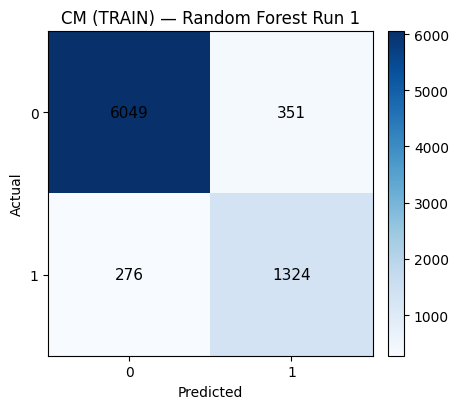

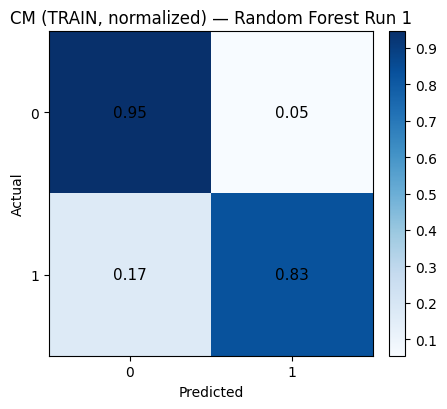


=== Final-Run Metrics: Random Forest [test] ===
Accuracy: 0.7310
Error rate (1-Acc): 0.2690
Classification Report:
              precision    recall  f1-score   support

           0     0.7970    0.8906    0.8412      1600
           1     0.1745    0.0925    0.1209       400

    accuracy                         0.7310      2000
   macro avg     0.4858    0.4916    0.4811      2000
weighted avg     0.6725    0.7310    0.6971      2000

Confusion Matrix [rows=true, cols=pred]:
[[1425  175]
 [ 363   37]]
Sensitivity (Recall+): 0.0925 | Specificity: 0.8906
Precision (PPV): 0.1745 | NPV: 0.7970
FPR: 0.1094 | FNR: 0.9075 | F1: 0.1209
MCC: -0.0219 | Cohen's kappa: -0.0205 | Balanced Acc: 0.4916
Hamming loss: 0.2690 | Zero-One loss: 0.2690
Prevalence+: 0.2000 | Pred+ rate: 0.1060 | Youden J: -0.0169
Log Loss: 0.6481 | Brier score: 0.2277 | Average Precision (PR-AUC): 0.1855 | ROC-AUC: 0.4725


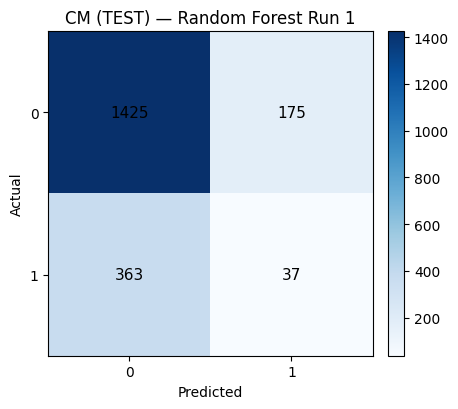

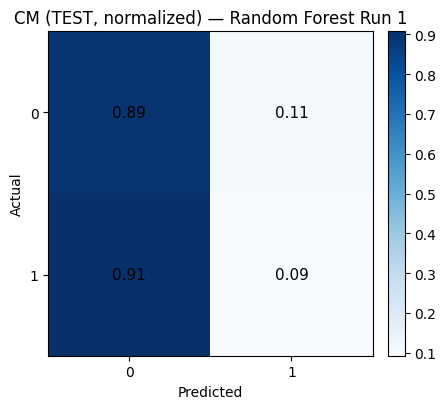

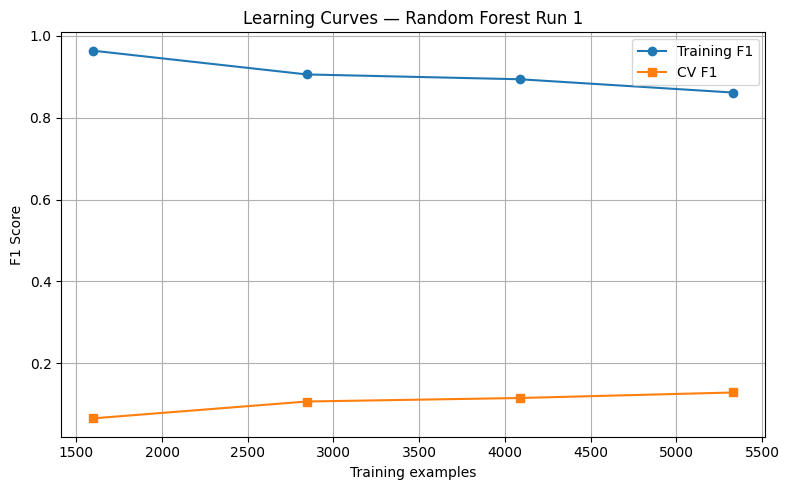

Saved model: imput/random_forest.joblib

[Random Forest] Run 2/5

Searching best parameters (RandomizedSearch)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 8, 'class_weight': 'balanced', 'bootstrap': True}

Scores for best parameters (CV mean):
ACC : 0.7503
PREC: 0.2083
REC : 0.0900
F1  : 0.1254
AUC : 0.5039

=== Final-Run Metrics: Random Forest [train] ===
Accuracy: 0.9214
Error rate (1-Acc): 0.0786
Classification Report:
              precision    recall  f1-score   support

           0     0.9546    0.9467    0.9507      6400
           1     0.7937    0.8200    0.8066      1600

    accuracy                         0.9214      8000
   macro avg     0.8742    0.8834    0.8786      8000
weighted avg     0.9224    0.9214    0.9219      8000

Confusion Matrix [rows=true, cols=pred]:
[[6059  341]
 [ 288 1312]]
Sensitivity (Recall+): 0.8200 | Sp

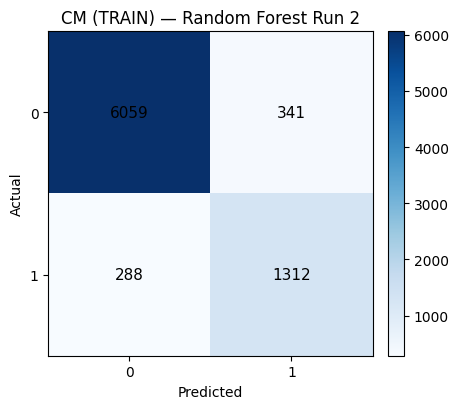

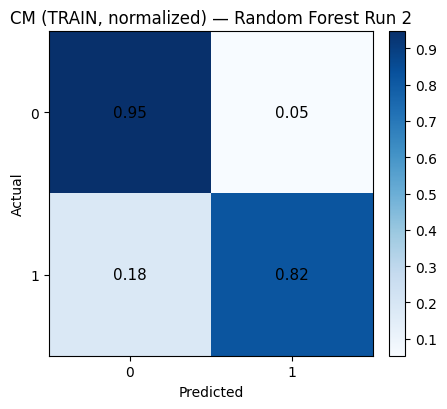


=== Final-Run Metrics: Random Forest [test] ===
Accuracy: 0.7345
Error rate (1-Acc): 0.2655
Classification Report:
              precision    recall  f1-score   support

           0     0.7981    0.8944    0.8435      1600
           1     0.1836    0.0950    0.1252       400

    accuracy                         0.7345      2000
   macro avg     0.4908    0.4947    0.4844      2000
weighted avg     0.6752    0.7345    0.6998      2000

Confusion Matrix [rows=true, cols=pred]:
[[1431  169]
 [ 362   38]]
Sensitivity (Recall+): 0.0950 | Specificity: 0.8944
Precision (PPV): 0.1836 | NPV: 0.7981
FPR: 0.1056 | FNR: 0.9050 | F1: 0.1252
MCC: -0.0140 | Cohen's kappa: -0.0130 | Balanced Acc: 0.4947
Hamming loss: 0.2655 | Zero-One loss: 0.2655
Prevalence+: 0.2000 | Pred+ rate: 0.1035 | Youden J: -0.0106
Log Loss: 0.6479 | Brier score: 0.2275 | Average Precision (PR-AUC): 0.1865 | ROC-AUC: 0.4729


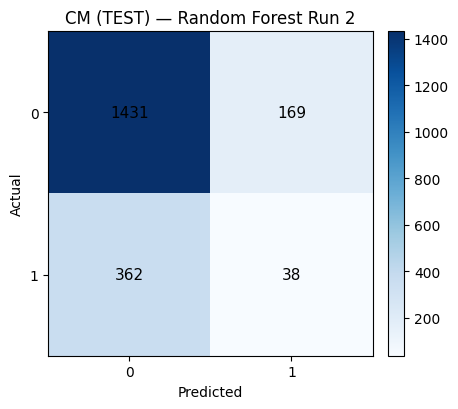

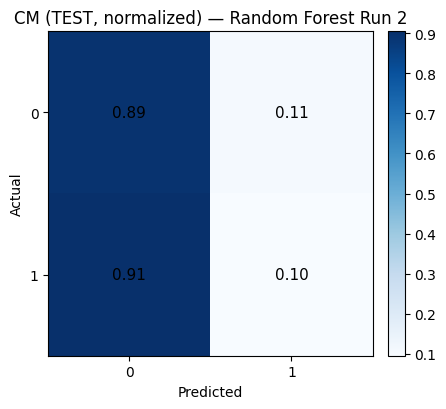

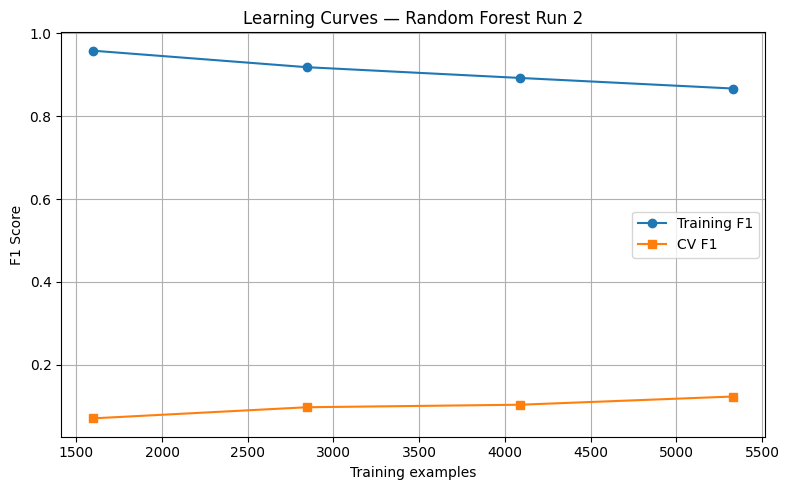

Saved model: imput/random_forest.joblib

[Random Forest] Run 3/5

Searching best parameters (RandomizedSearch)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 8, 'class_weight': 'balanced', 'bootstrap': True}

Scores for best parameters (CV mean):
ACC : 0.7359
PREC: 0.1992
REC : 0.1062
F1  : 0.1376
AUC : 0.5097

=== Final-Run Metrics: Random Forest [train] ===
Accuracy: 0.9093
Error rate (1-Acc): 0.0907
Classification Report:
              precision    recall  f1-score   support

           0     0.9503    0.9355    0.9428      6400
           1     0.7571    0.8044    0.7800      1600

    accuracy                         0.9093      8000
   macro avg     0.8537    0.8699    0.8614      8000
weighted avg     0.9117    0.9093    0.9103      8000

Confusion Matrix [rows=true, cols=pred]:
[[5987  413]
 [ 313 1287]]
Sensitivity (Recall+): 0.8044 | Sp

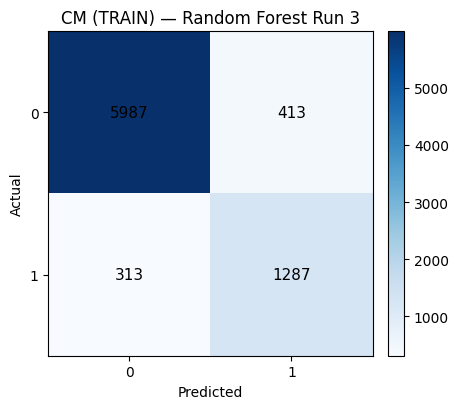

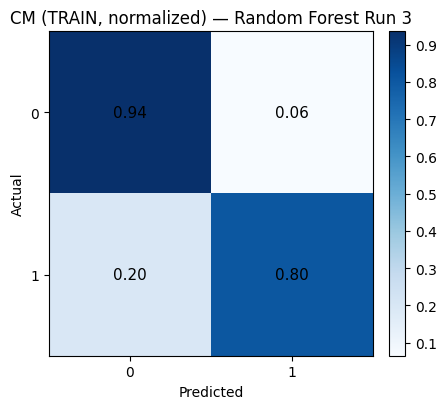


=== Final-Run Metrics: Random Forest [test] ===
Accuracy: 0.7275
Error rate (1-Acc): 0.2725
Classification Report:
              precision    recall  f1-score   support

           0     0.7995    0.8800    0.8378      1600
           1     0.1967    0.1175    0.1471       400

    accuracy                         0.7275      2000
   macro avg     0.4981    0.4988    0.4925      2000
weighted avg     0.6790    0.7275    0.6997      2000

Confusion Matrix [rows=true, cols=pred]:
[[1408  192]
 [ 353   47]]
Sensitivity (Recall+): 0.1175 | Specificity: 0.8800
Precision (PPV): 0.1967 | NPV: 0.7995
FPR: 0.1200 | FNR: 0.8825 | F1: 0.1471
MCC: -0.0031 | Cohen's kappa: -0.0029 | Balanced Acc: 0.4988
Hamming loss: 0.2725 | Zero-One loss: 0.2725
Prevalence+: 0.2000 | Pred+ rate: 0.1195 | Youden J: -0.0025
Log Loss: 0.6492 | Brier score: 0.2282 | Average Precision (PR-AUC): 0.1861 | ROC-AUC: 0.4663


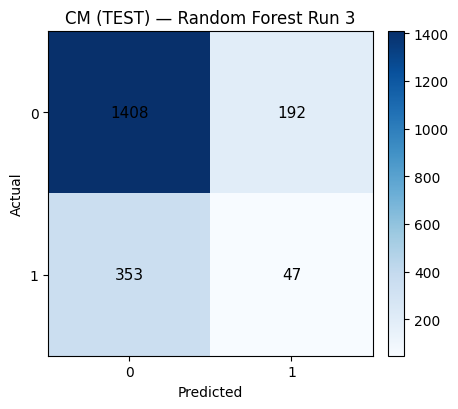

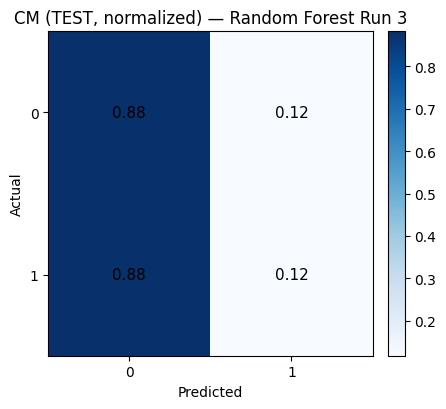

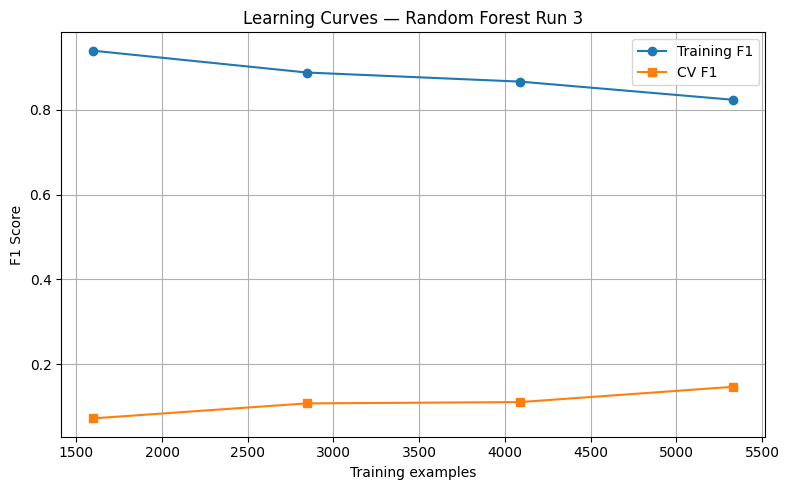

Saved model: imput/random_forest.joblib

[Random Forest] Run 4/5

Searching best parameters (RandomizedSearch)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'class_weight': 'balanced', 'bootstrap': True}

Scores for best parameters (CV mean):
ACC : 0.7569
PREC: 0.2213
REC : 0.0837
F1  : 0.1211
AUC : 0.5077

=== Final-Run Metrics: Random Forest [train] ===
Accuracy: 0.9216
Error rate (1-Acc): 0.0784
Classification Report:
              precision    recall  f1-score   support

           0     0.9564    0.9452    0.9507      6400
           1     0.7904    0.8275    0.8085      1600

    accuracy                         0.9216      8000
   macro avg     0.8734    0.8863    0.8796      8000
weighted avg     0.9232    0.9216    0.9223      8000

Confusion Matrix [rows=true, cols=pred]:
[[6049  351]
 [ 276 1324]]
Sensitivity (Recall+): 0.8275 | Sp

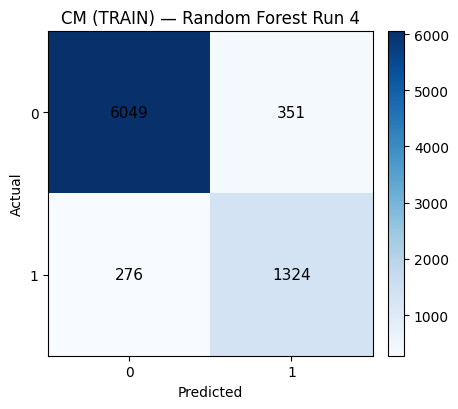

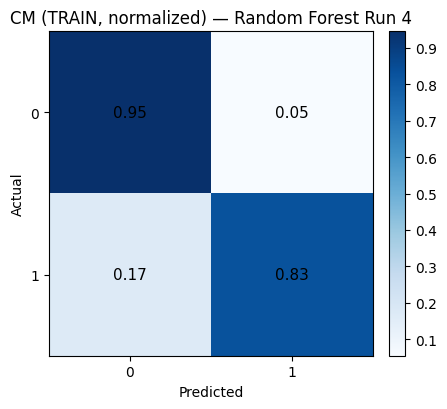


=== Final-Run Metrics: Random Forest [test] ===
Accuracy: 0.7310
Error rate (1-Acc): 0.2690
Classification Report:
              precision    recall  f1-score   support

           0     0.7970    0.8906    0.8412      1600
           1     0.1745    0.0925    0.1209       400

    accuracy                         0.7310      2000
   macro avg     0.4858    0.4916    0.4811      2000
weighted avg     0.6725    0.7310    0.6971      2000

Confusion Matrix [rows=true, cols=pred]:
[[1425  175]
 [ 363   37]]
Sensitivity (Recall+): 0.0925 | Specificity: 0.8906
Precision (PPV): 0.1745 | NPV: 0.7970
FPR: 0.1094 | FNR: 0.9075 | F1: 0.1209
MCC: -0.0219 | Cohen's kappa: -0.0205 | Balanced Acc: 0.4916
Hamming loss: 0.2690 | Zero-One loss: 0.2690
Prevalence+: 0.2000 | Pred+ rate: 0.1060 | Youden J: -0.0169
Log Loss: 0.6481 | Brier score: 0.2277 | Average Precision (PR-AUC): 0.1855 | ROC-AUC: 0.4725


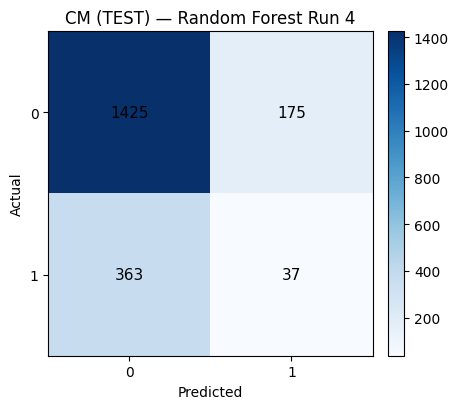

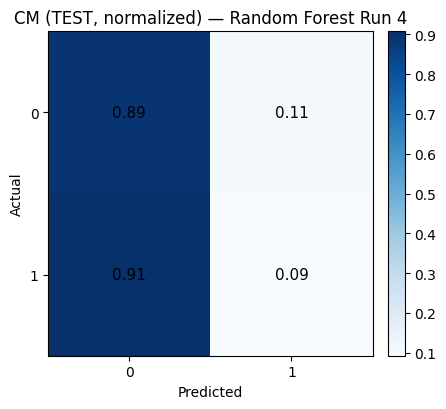

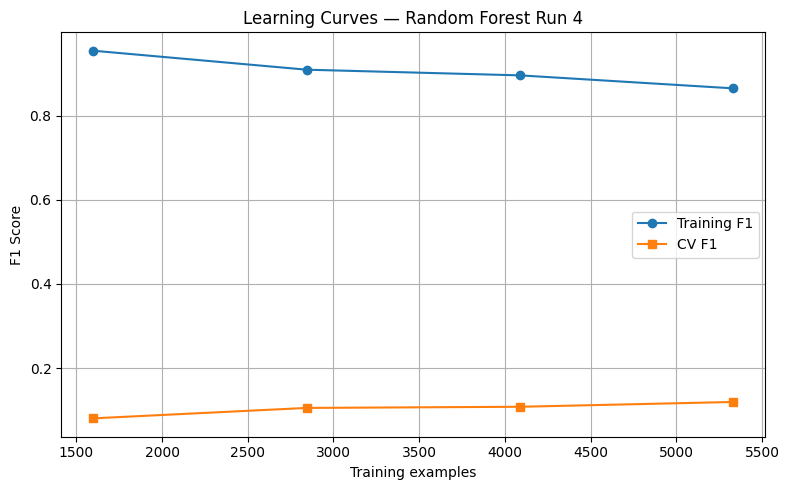

Saved model: imput/random_forest.joblib

[Random Forest] Run 5/5

Searching best parameters (RandomizedSearch)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 8, 'class_weight': 'balanced', 'bootstrap': True}

Scores for best parameters (CV mean):
ACC : 0.7466
PREC: 0.2140
REC : 0.0994
F1  : 0.1354
AUC : 0.5088

=== Final-Run Metrics: Random Forest [train] ===
Accuracy: 0.9093
Error rate (1-Acc): 0.0907
Classification Report:
              precision    recall  f1-score   support

           0     0.9503    0.9355    0.9428      6400
           1     0.7571    0.8044    0.7800      1600

    accuracy                         0.9093      8000
   macro avg     0.8537    0.8699    0.8614      8000
weighted avg     0.9117    0.9093    0.9103      8000

Confusion Matrix [rows=true, cols=pred]:
[[5987  413]
 [ 313 1287]]
Sensitivity (Recall+): 0.8044 | Sp

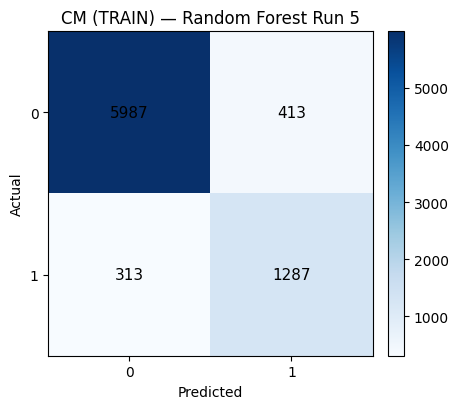

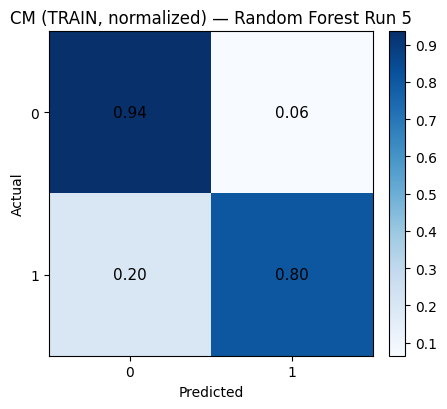


=== Final-Run Metrics: Random Forest [test] ===
Accuracy: 0.7275
Error rate (1-Acc): 0.2725
Classification Report:
              precision    recall  f1-score   support

           0     0.7995    0.8800    0.8378      1600
           1     0.1967    0.1175    0.1471       400

    accuracy                         0.7275      2000
   macro avg     0.4981    0.4988    0.4925      2000
weighted avg     0.6790    0.7275    0.6997      2000

Confusion Matrix [rows=true, cols=pred]:
[[1408  192]
 [ 353   47]]
Sensitivity (Recall+): 0.1175 | Specificity: 0.8800
Precision (PPV): 0.1967 | NPV: 0.7995
FPR: 0.1200 | FNR: 0.8825 | F1: 0.1471
MCC: -0.0031 | Cohen's kappa: -0.0029 | Balanced Acc: 0.4988
Hamming loss: 0.2725 | Zero-One loss: 0.2725
Prevalence+: 0.2000 | Pred+ rate: 0.1195 | Youden J: -0.0025
Log Loss: 0.6492 | Brier score: 0.2282 | Average Precision (PR-AUC): 0.1861 | ROC-AUC: 0.4663


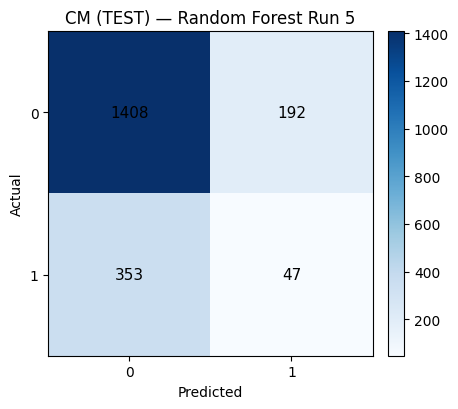

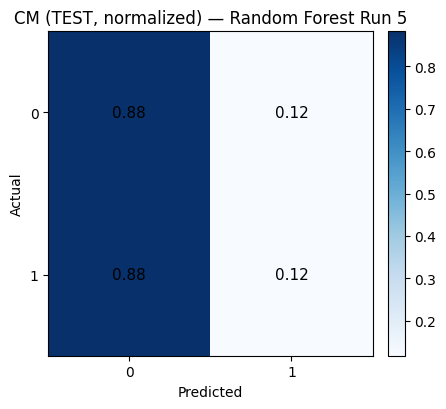

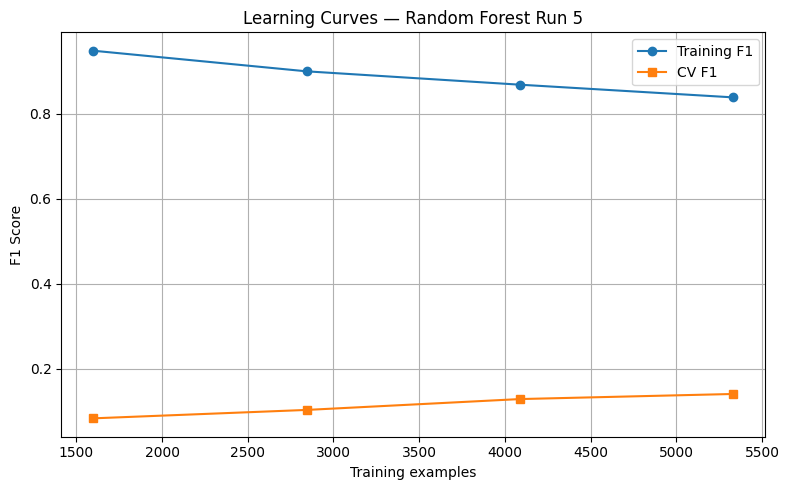

Saved model: imput/random_forest.joblib

F1 summary (Random Forest only):
           model  split  n_runs  mean_f1  std_f1  min_f1  max_f1
1  Random Forest   test       5   0.1322  0.0122  0.1209  0.1471
0  Random Forest  train       5   0.7967  0.0137  0.7800  0.8085


In [10]:
# ================== Random Forest (FAST + no warnings) ==================
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

MODEL_NAME = "Random Forest"
os.makedirs(model_dir, exist_ok=True)

# ---- scorers: ตัด UndefinedMetricWarning โดยกำหนด zero_division=0 ----
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall':    make_scorer(recall_score,    zero_division=0),
    'f1':        make_scorer(f1_score,        zero_division=0),
    'roc_auc':  'roc_auc'
}

# ---- ค้นหาแบบสุ่ม (เล็กลงมาก) ----
param_dist_rf = {
    'n_estimators':       [200, 300, 400],
    'max_depth':          [None, 8, 12, 16],
    'min_samples_split':  [2, 5, 10],
    'min_samples_leaf':   [1, 2, 4],
    'max_features':       ['sqrt', 'log2'],   # ตัด None เพื่อลดคอมโบ/overfit
    'bootstrap':          [True],
    'class_weight':       ['balanced', None], # ถ้า imbalance หนัก แนะนำ fix = ['balanced']
}
N_ITER = 24     # ปรับลดได้อีก เช่น 12 ถ้ายังช้า
N_FOLDS = 3     # ลดจาก 5 → 3 เพื่อความเร็ว

for run in range(1, n_runs + 1):
    print("\n" + "="*70)
    print(f"[{MODEL_NAME}] Run {run}/{n_runs}")

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42 + run)

    base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

    search = RandomizedSearchCV(
        estimator=base_rf,
        param_distributions=param_dist_rf,
        n_iter=N_ITER,
        cv=skf,
        scoring=scorers,
        refit='f1',                  # โฟกัส F1 สำหรับ imbalance
        n_jobs=-1,
        verbose=1,
        random_state=42 + run,
        return_train_score=False
    )

    print("\nSearching best parameters (RandomizedSearch)...")
    search.fit(X_train, y_train)
    best_est   = search.best_estimator_
    best_params= search.best_params_
    bi         = search.best_index_

    print("\nBest parameters:", best_params)
    print("\nScores for best parameters (CV mean):")
    print(f"ACC : {search.cv_results_['mean_test_accuracy'][bi]:.4f}")
    print(f"PREC: {search.cv_results_['mean_test_precision'][bi]:.4f}")
    print(f"REC : {search.cv_results_['mean_test_recall'][bi]:.4f}")
    print(f"F1  : {search.cv_results_['mean_test_f1'][bi]:.4f}")
    print(f"AUC : {search.cv_results_['mean_test_roc_auc'][bi]:.4f}")

    # ----- TRAIN -----
    y_tr_pred = best_est.predict(X_train)
    y_tr_prob = best_est.predict_proba(X_train)[:, 1]
    tr_metrics = log_final_run_metrics(
        MODEL_NAME, y_train, y_tr_pred, y_tr_prob, roc_data,
        split="train", run=run, params=best_params
    )
    row_tr = save_run_metrics(MODEL_NAME, run, tr_metrics, split="train", params=best_params)
    results[MODEL_NAME]['train'].append(tr_metrics.get('f1', np.nan))

    # CM (TRAIN)
    cm_train_png      = os.path.join(model_dir, f"cm_rf_train_run{run:02d}.png")
    cm_train_norm_png = os.path.join(model_dir, f"cm_rf_train_norm_run{run:02d}.png")
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN) — {MODEL_NAME} Run {run}", cm_train_png, normalize=False)
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN, normalized) — {MODEL_NAME} Run {run}", cm_train_norm_png, normalize=True)
    row_tr["cm_png"] = cm_train_png; row_tr["cm_norm_png"] = cm_train_norm_png

    # ----- TEST -----
    y_te_pred = best_est.predict(X_test)
    y_te_prob = best_est.predict_proba(X_test)[:, 1]
    te_metrics = log_final_run_metrics(
        MODEL_NAME, y_test, y_te_pred, y_te_prob, roc_data,
        split="test", run=run, params=best_params
    )
    row_te = save_run_metrics(MODEL_NAME, run, te_metrics, split="test", params=best_params, is_final=True)
    results[MODEL_NAME]['test'].append(te_metrics.get('f1', np.nan))

    # CM (TEST)
    cm_test_png      = os.path.join(model_dir, f"cm_rf_test_run{run:02d}.png")
    cm_test_norm_png = os.path.join(model_dir, f"cm_rf_test_norm_run{run:02d}.png")
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST) — {MODEL_NAME} Run {run}", cm_test_png, normalize=False)
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST, normalized) — {MODEL_NAME} Run {run}", cm_test_norm_png, normalize=True)
    row_te["cm_png"] = cm_test_png; row_te["cm_norm_png"] = cm_test_norm_png

    # ----- Learning Curve (ย่อเหลือ 4 จุด × 3-fold = 12 fits/รัน) -----
    sizes, tr_scores, cv_scores = learning_curve(
        best_est, X_train, y_train,
        cv=skf, n_jobs=-1, scoring='f1',
        train_sizes=np.linspace(0.3, 1.0, 4)
    )
    plt.figure(figsize=(8,5))
    plt.plot(sizes, tr_scores.mean(axis=1), marker='o', label='Training F1')
    plt.plot(sizes, cv_scores.mean(axis=1), marker='s', label='CV F1')
    plt.xlabel('Training examples'); plt.ylabel('F1 Score')
    plt.title(f'Learning Curves — {MODEL_NAME} Run {run}')
    plt.legend(loc='best'); plt.grid(True); plt.tight_layout(); plt.show()

    # ----- Save model ต่อรอบ -----
    try:
        model_path = save_model(MODEL_NAME, best_est, is_dnn=False)
    except Exception:
        os.makedirs("imput", exist_ok=True)
        model_path = os.path.join("imput", f"{MODEL_NAME.lower().replace(' ', '_')}_run{run:02d}.joblib")
        joblib.dump(best_est, model_path); print(f"[Fallback] Saved model: {model_path}")
    detailed_metrics[-1]["model_path"] = model_path

# per-model table & summary
df_all = pd.DataFrame(detailed_metrics); df_rf = df_all[df_all["model"] == MODEL_NAME].copy()
df_rf.to_csv(os.path.join(model_dir, "detailed_metrics_random_forest.csv"), index=False)

def _summarize_f1_for_model(results_dict, model_name):
    rows = []
    for split in ["train", "test"]:
        arr = np.array(results_dict.get(model_name, {}).get(split, []), dtype=float)
        if arr.size == 0: continue
        rows.append({"model": model_name, "split": split, "n_runs": len(arr),
                     "mean_f1": arr.mean(), "std_f1": arr.std(), "min_f1": arr.min(), "max_f1": arr.max()})
    return pd.DataFrame(rows).sort_values(["model","split"])

summary_f1_rf = _summarize_f1_for_model(results, MODEL_NAME)
print("\nF1 summary (Random Forest only):"); print(summary_f1_rf.round(4))
summary_f1_rf.to_csv(os.path.join(model_dir, "summary_f1_random_forest.csv"), index=False)
# ==================================================================================================



[EBM] Run 1/5

Searching best parameters...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters: {'interactions': 10, 'learning_rate': 0.05, 'max_bins': 128, 'max_leaves': 3, 'min_samples_leaf': 3, 'outer_bags': 4, 'random_state': 42}

Scores for best parameters (CV mean):
ACC : 0.8000
BAL : 0.5000
PREC: 0.0000
REC : 0.0000
F1  : 0.0000
AUC : 0.5117
AP  : 0.2129

[Threshold @TRAIN] best_thr=0.191  F1=0.3520  P=0.2215  R=0.8562

=== Final-Run Metrics: EBM [train] ===
Accuracy: 0.3694
Error rate (1-Acc): 0.6306
Classification Report:
              precision    recall  f1-score   support

           0     0.8733    0.2477    0.3859      6400
           1     0.2215    0.8562    0.3520      1600

    accuracy                         0.3694      8000
   macro avg     0.5474    0.5520    0.3689      8000
weighted avg     0.7429    0.3694    0.3791      8000

Confusion Matrix [rows=true, cols=pred]:
[[1585 4815]
 [ 230 1370]]
Sensitivity (Recall+): 0.8562 | Specifi

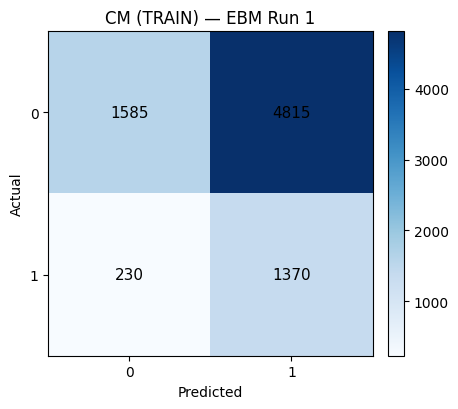

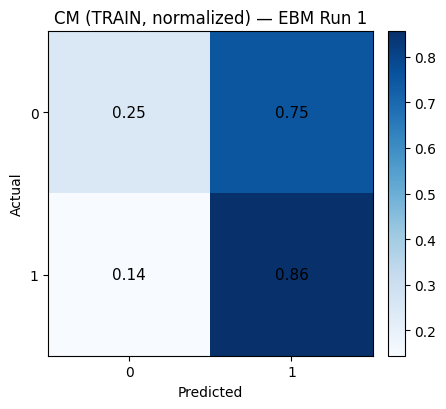


=== Final-Run Metrics: EBM [test] ===
Accuracy: 0.3445
Error rate (1-Acc): 0.6555
Classification Report:
              precision    recall  f1-score   support

           0     0.7979    0.2419    0.3712      1600
           1     0.1993    0.7550    0.3154       400

    accuracy                         0.3445      2000
   macro avg     0.4986    0.4984    0.3433      2000
weighted avg     0.6782    0.3445    0.3601      2000

Confusion Matrix [rows=true, cols=pred]:
[[ 387 1213]
 [  98  302]]
Sensitivity (Recall+): 0.7550 | Specificity: 0.2419
Precision (PPV): 0.1993 | NPV: 0.7979
FPR: 0.7581 | FNR: 0.2450 | F1: 0.3154
MCC: -0.0029 | Cohen's kappa: -0.0015 | Balanced Acc: 0.4984
Hamming loss: 0.6555 | Zero-One loss: 0.6555
Prevalence+: 0.2000 | Pred+ rate: 0.7575 | Youden J: -0.0031
Log Loss: 0.5015 | Brier score: 0.1604 | Average Precision (PR-AUC): 0.1942 | ROC-AUC: 0.4846


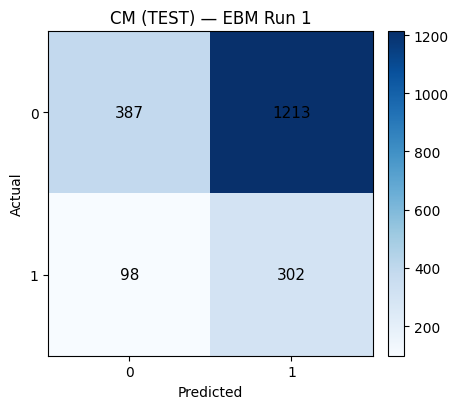

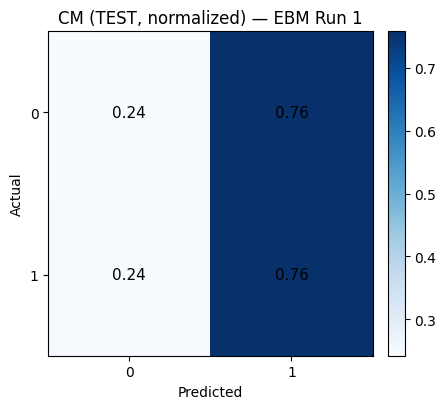

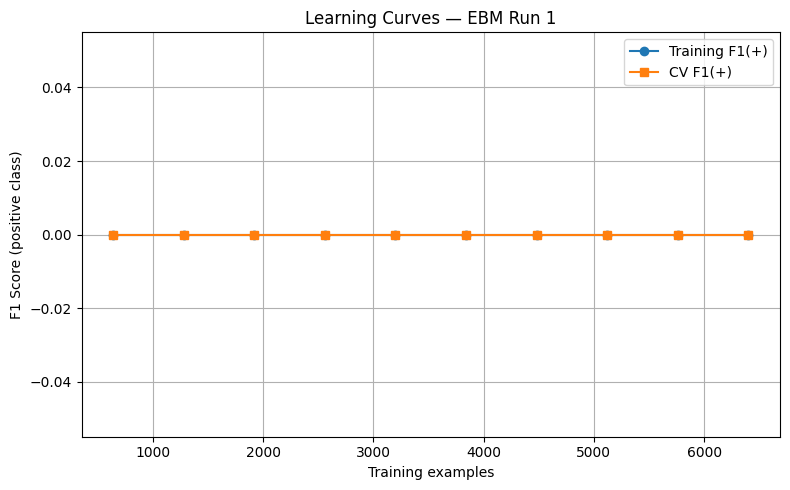

Saved model: imput/ebm.joblib

[EBM] Run 2/5

Searching best parameters...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters: {'interactions': 10, 'learning_rate': 0.1, 'max_bins': 128, 'max_leaves': 3, 'min_samples_leaf': 3, 'outer_bags': 8, 'random_state': 42}

Scores for best parameters (CV mean):
ACC : 0.8000
BAL : 0.5000
PREC: 0.0000
REC : 0.0000
F1  : 0.0000
AUC : 0.5094
AP  : 0.2142

[Threshold @TRAIN] best_thr=0.194  F1=0.3605  P=0.2349  R=0.7744

=== Final-Run Metrics: EBM [train] ===
Accuracy: 0.4505
Error rate (1-Acc): 0.5495
Classification Report:
              precision    recall  f1-score   support

           0     0.8676    0.3695    0.5183      6400
           1     0.2349    0.7744    0.3605      1600

    accuracy                         0.4505      8000
   macro avg     0.5512    0.5720    0.4394      8000
weighted avg     0.7410    0.4505    0.4867      8000

Confusion Matrix [rows=true, cols=pred]:
[[2365 4035]
 [ 361 1239]]
Sensitivit

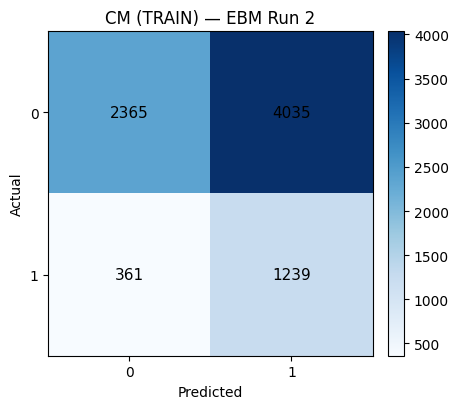

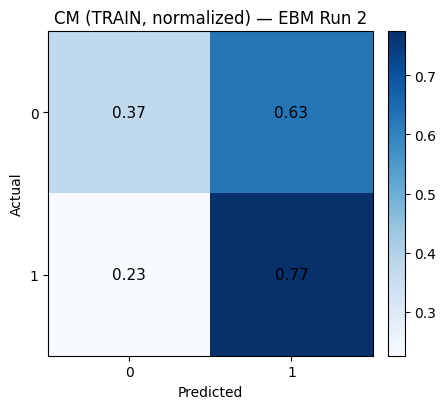


=== Final-Run Metrics: EBM [test] ===
Accuracy: 0.3980
Error rate (1-Acc): 0.6020
Classification Report:
              precision    recall  f1-score   support

           0     0.7870    0.3394    0.4742      1600
           1     0.1931    0.6325    0.2959       400

    accuracy                         0.3980      2000
   macro avg     0.4900    0.4859    0.3851      2000
weighted avg     0.6682    0.3980    0.4386      2000

Confusion Matrix [rows=true, cols=pred]:
[[ 543 1057]
 [ 147  253]]
Sensitivity (Recall+): 0.6325 | Specificity: 0.3394
Precision (PPV): 0.1931 | NPV: 0.7870
FPR: 0.6606 | FNR: 0.3675 | F1: 0.2959
MCC: -0.0237 | Cohen's kappa: -0.0152 | Balanced Acc: 0.4859
Hamming loss: 0.6020 | Zero-One loss: 0.6020
Prevalence+: 0.2000 | Pred+ rate: 0.6550 | Youden J: -0.0281
Log Loss: 0.5022 | Brier score: 0.1606 | Average Precision (PR-AUC): 0.1882 | ROC-AUC: 0.4805


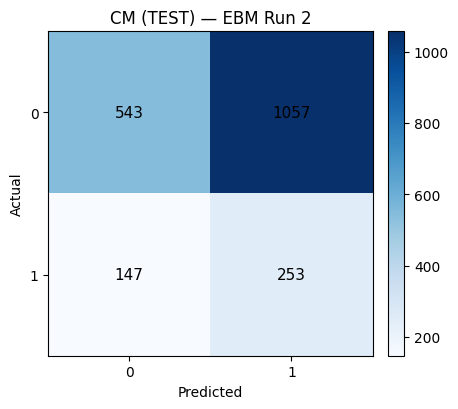

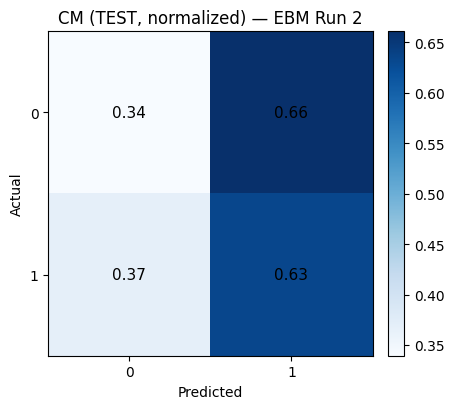

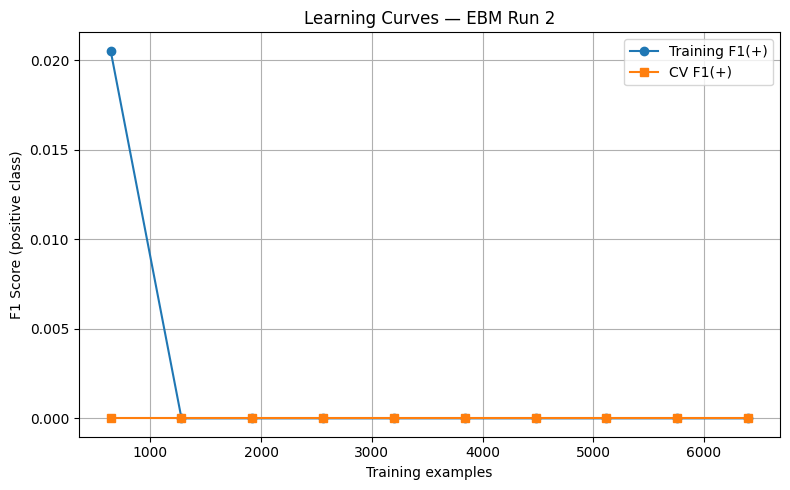

Saved model: imput/ebm.joblib

[EBM] Run 3/5

Searching best parameters...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters: {'interactions': 10, 'learning_rate': 0.01, 'max_bins': 256, 'max_leaves': 2, 'min_samples_leaf': 3, 'outer_bags': 8, 'random_state': 42}

Scores for best parameters (CV mean):
ACC : 0.8000
BAL : 0.5000
PREC: 0.0000
REC : 0.0000
F1  : 0.0000
AUC : 0.5010
AP  : 0.2122

[Threshold @TRAIN] best_thr=0.200  F1=0.3614  P=0.2537  R=0.6281

=== Final-Run Metrics: EBM [train] ===
Accuracy: 0.5561
Error rate (1-Acc): 0.4439
Classification Report:
              precision    recall  f1-score   support

           0     0.8527    0.5381    0.6598      6400
           1     0.2537    0.6281    0.3614      1600

    accuracy                         0.5561      8000
   macro avg     0.5532    0.5831    0.5106      8000
weighted avg     0.7329    0.5561    0.6002      8000

Confusion Matrix [rows=true, cols=pred]:
[[3444 2956]
 [ 595 1005]]
Sensitivi

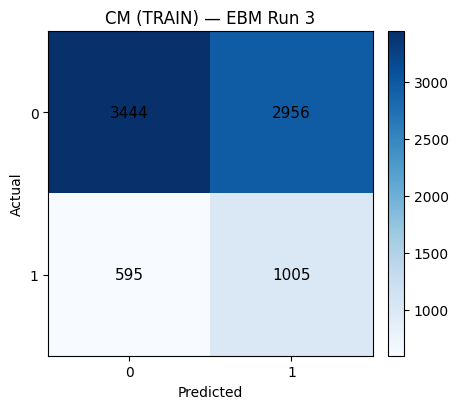

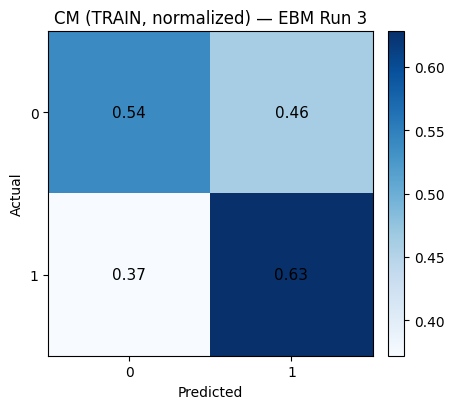


=== Final-Run Metrics: EBM [test] ===
Accuracy: 0.4970
Error rate (1-Acc): 0.5030
Classification Report:
              precision    recall  f1-score   support

           0     0.7895    0.5062    0.6169      1600
           1     0.1889    0.4600    0.2678       400

    accuracy                         0.4970      2000
   macro avg     0.4892    0.4831    0.4424      2000
weighted avg     0.6694    0.4970    0.5471      2000

Confusion Matrix [rows=true, cols=pred]:
[[810 790]
 [216 184]]
Sensitivity (Recall+): 0.4600 | Specificity: 0.5062
Precision (PPV): 0.1889 | NPV: 0.7895
FPR: 0.4937 | FNR: 0.5400 | F1: 0.2678
MCC: -0.0270 | Cohen's kappa: -0.0219 | Balanced Acc: 0.4831
Hamming loss: 0.5030 | Zero-One loss: 0.5030
Prevalence+: 0.2000 | Pred+ rate: 0.4870 | Youden J: -0.0338
Log Loss: 0.5031 | Brier score: 0.1608 | Average Precision (PR-AUC): 0.1897 | ROC-AUC: 0.4740


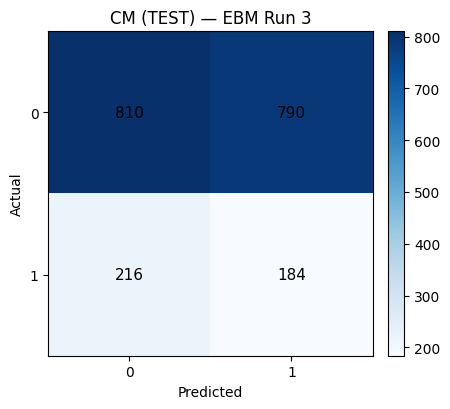

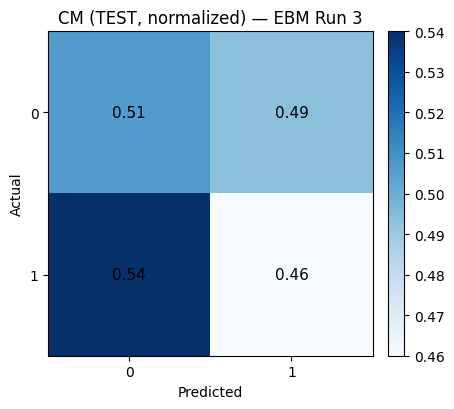

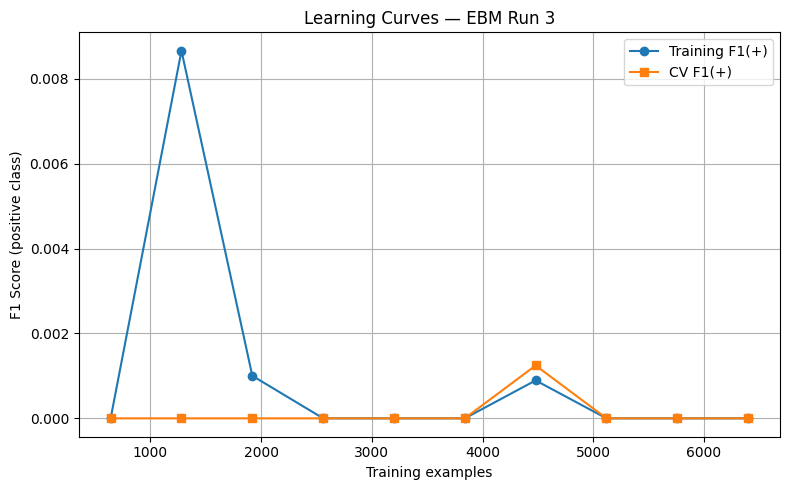

Saved model: imput/ebm.joblib

[EBM] Run 4/5

Searching best parameters...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters: {'interactions': 10, 'learning_rate': 0.1, 'max_bins': 128, 'max_leaves': 3, 'min_samples_leaf': 3, 'outer_bags': 8, 'random_state': 42}

Scores for best parameters (CV mean):
ACC : 0.8000
BAL : 0.5000
PREC: 0.0000
REC : 0.0000
F1  : 0.0000
AUC : 0.5076
AP  : 0.2127

[Threshold @TRAIN] best_thr=0.194  F1=0.3605  P=0.2349  R=0.7744

=== Final-Run Metrics: EBM [train] ===
Accuracy: 0.4505
Error rate (1-Acc): 0.5495
Classification Report:
              precision    recall  f1-score   support

           0     0.8676    0.3695    0.5183      6400
           1     0.2349    0.7744    0.3605      1600

    accuracy                         0.4505      8000
   macro avg     0.5512    0.5720    0.4394      8000
weighted avg     0.7410    0.4505    0.4867      8000

Confusion Matrix [rows=true, cols=pred]:
[[2365 4035]
 [ 361 1239]]
Sensitivit

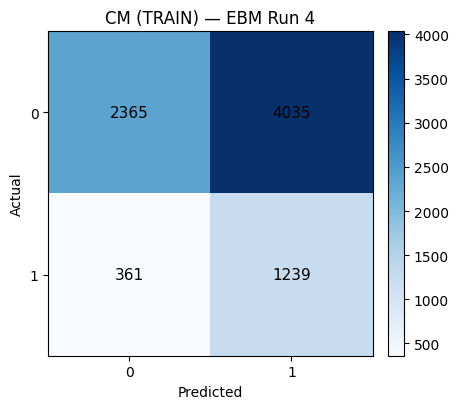

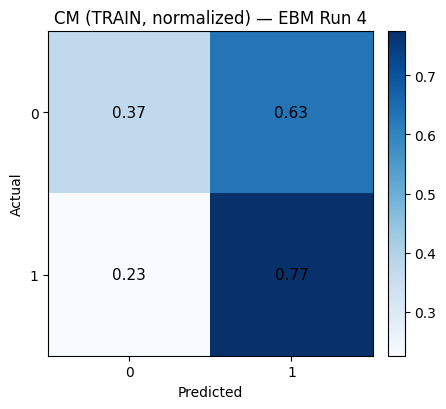


=== Final-Run Metrics: EBM [test] ===
Accuracy: 0.3980
Error rate (1-Acc): 0.6020
Classification Report:
              precision    recall  f1-score   support

           0     0.7870    0.3394    0.4742      1600
           1     0.1931    0.6325    0.2959       400

    accuracy                         0.3980      2000
   macro avg     0.4900    0.4859    0.3851      2000
weighted avg     0.6682    0.3980    0.4386      2000

Confusion Matrix [rows=true, cols=pred]:
[[ 543 1057]
 [ 147  253]]
Sensitivity (Recall+): 0.6325 | Specificity: 0.3394
Precision (PPV): 0.1931 | NPV: 0.7870
FPR: 0.6606 | FNR: 0.3675 | F1: 0.2959
MCC: -0.0237 | Cohen's kappa: -0.0152 | Balanced Acc: 0.4859
Hamming loss: 0.6020 | Zero-One loss: 0.6020
Prevalence+: 0.2000 | Pred+ rate: 0.6550 | Youden J: -0.0281
Log Loss: 0.5022 | Brier score: 0.1606 | Average Precision (PR-AUC): 0.1882 | ROC-AUC: 0.4805


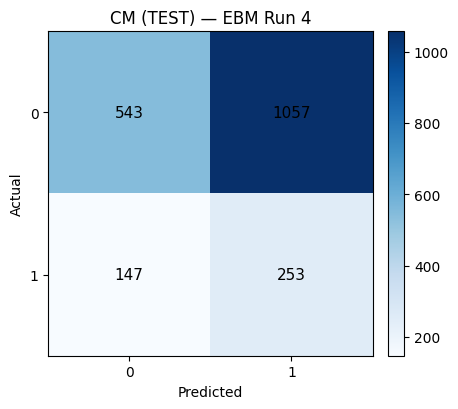

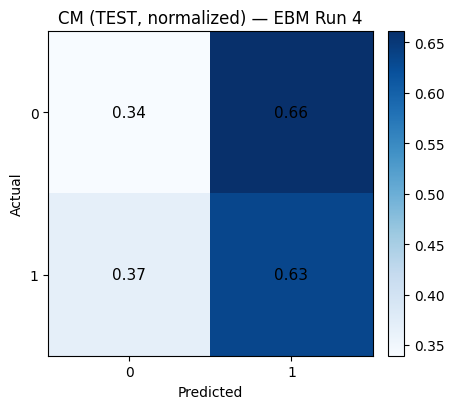

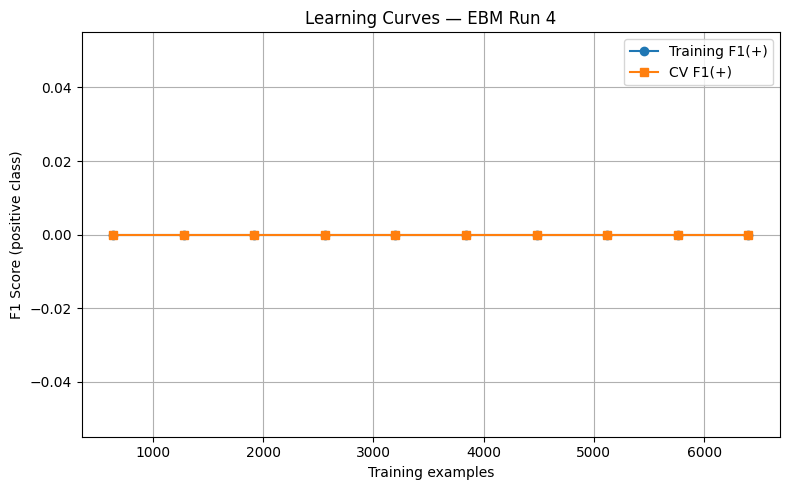

Saved model: imput/ebm.joblib

[EBM] Run 5/5

Searching best parameters...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters: {'interactions': 10, 'learning_rate': 0.05, 'max_bins': 256, 'max_leaves': 3, 'min_samples_leaf': 1, 'outer_bags': 4, 'random_state': 42}

Scores for best parameters (CV mean):
ACC : 0.8000
BAL : 0.5000
PREC: 0.0000
REC : 0.0000
F1  : 0.0000
AUC : 0.5086
AP  : 0.2144

[Threshold @TRAIN] best_thr=0.198  F1=0.3693  P=0.2583  R=0.6475

=== Final-Run Metrics: EBM [train] ===
Accuracy: 0.5576
Error rate (1-Acc): 0.4424
Classification Report:
              precision    recall  f1-score   support

           0     0.8586    0.5352    0.6594      6400
           1     0.2583    0.6475    0.3693      1600

    accuracy                         0.5576      8000
   macro avg     0.5585    0.5913    0.5143      8000
weighted avg     0.7385    0.5576    0.6013      8000

Confusion Matrix [rows=true, cols=pred]:
[[3425 2975]
 [ 564 1036]]
Sensitivi

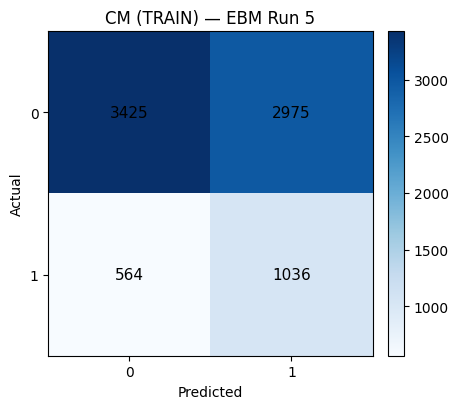

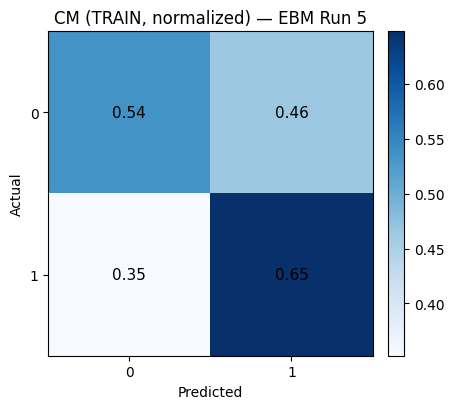


=== Final-Run Metrics: EBM [test] ===
Accuracy: 0.5010
Error rate (1-Acc): 0.4990
Classification Report:
              precision    recall  f1-score   support

           0     0.8034    0.4981    0.6150      1600
           1     0.2034    0.5125    0.2912       400

    accuracy                         0.5010      2000
   macro avg     0.5034    0.5053    0.4531      2000
weighted avg     0.6834    0.5010    0.5502      2000

Confusion Matrix [rows=true, cols=pred]:
[[797 803]
 [195 205]]
Sensitivity (Recall+): 0.5125 | Specificity: 0.4981
Precision (PPV): 0.2034 | NPV: 0.8034
FPR: 0.5019 | FNR: 0.4875 | F1: 0.2912
MCC: 0.0085 | Cohen's kappa: 0.0068 | Balanced Acc: 0.5053
Hamming loss: 0.4990 | Zero-One loss: 0.4990
Prevalence+: 0.2000 | Pred+ rate: 0.5040 | Youden J: 0.0106
Log Loss: 0.5025 | Brier score: 0.1607 | Average Precision (PR-AUC): 0.1935 | ROC-AUC: 0.4867


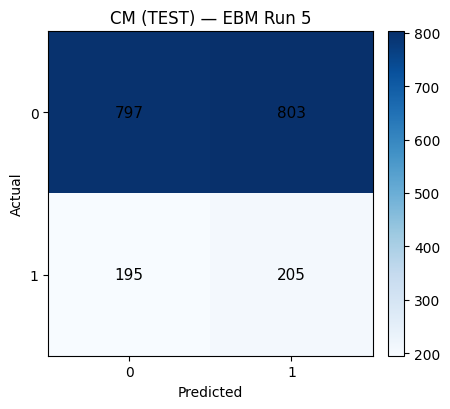

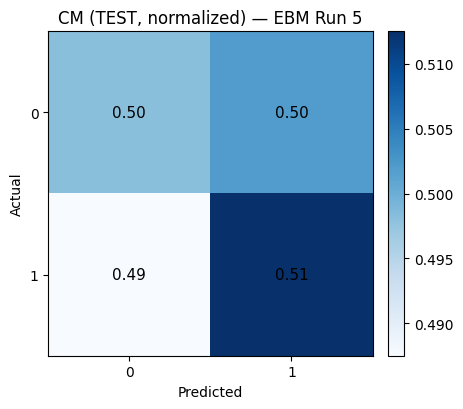

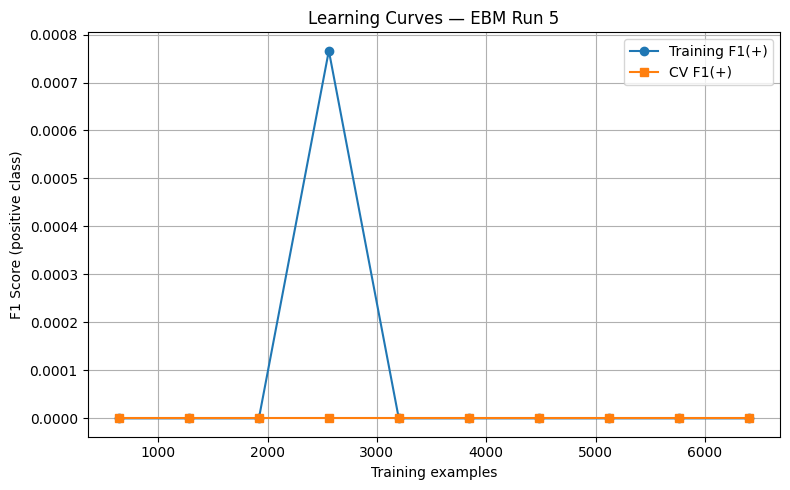

Saved model: imput/ebm.joblib

F1 summary (EBM only):
  model  split  n_runs  mean_f1  std_f1  min_f1  max_f1
1   EBM   test       7   0.2968  0.0150  0.2678  0.3154
0   EBM  train       7   0.3594  0.0056  0.3520  0.3693


In [12]:
# ================== EBM (multi-run; metrics per run + CM plots + per-model summary) ==================

from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.utils.class_weight import compute_sample_weight

# --- Import EBM ---
try:
    from interpret.glassbox import ExplainableBoostingClassifier
except Exception as e:
    print("[EBM] ข้าม: ต้องติดตั้งแพ็กเกจ 'interpret' ก่อน (pip install interpret)")
    print("รายละเอียด:", repr(e))
    raise

MODEL_NAME = "EBM"

# --- Scorers: เน้น positive class และหลีกเลี่ยง warning ด้วย zero_division=0 ---
scorers = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "precision": make_scorer(precision_score, pos_label=1, zero_division=0),
    "recall": make_scorer(recall_score, pos_label=1, zero_division=0),
    "f1": make_scorer(f1_score, pos_label=1, zero_division=0),
    "f1_pos": make_scorer(f1_score, pos_label=1, zero_division=0),
    "roc_auc": "roc_auc",            # ใช้สตริงเพื่อเรียก proba อัตโนมัติ
    "ap": "average_precision",       # = AP/PR-AUC, ไม่ต้อง make_scorer ให้ยุ่ง
}

# --- เลือก threshold ที่ให้ F1 สูงสุดบน TRAIN (robust) ---
def pick_best_threshold_by_f1(y_true, y_prob):
    # ป้องกันกรณี prob ค่าคงที่
    if np.allclose(y_prob.min(), y_prob.max()):
        return 0.5, 0.0, 0.0, 0.0
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    # thresholds มีขนาด len(prec)-1; คำนวณ F1 ที่จุด prec/rec ทุกจุด (รวม 0/1 edges)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    best_idx = int(np.nanargmax(f1))
    # map index กลับไป threshold ให้ถูกต้อง
    if best_idx == 0:
        best_thr = thr[0] if len(thr) else 0.5
    elif best_idx >= len(thr):
        best_thr = thr[-1] if len(thr) else 0.5
    else:
        best_thr = thr[best_idx]
    return float(best_thr), float(f1[best_idx]), float(prec[best_idx]), float(rec[best_idx])

# --- พารามิเตอร์สำหรับ GridSearch (ปลอดภัยและรันไว) ---
param_grid_ebm = {
    "interactions": [0, 10],        # 0 = additive only, 10 = บางคู่ที่สำคัญ
    "learning_rate": [0.01, 0.05, 0.1],
    "max_bins": [128, 256],
    "max_leaves": [2, 3],
    "min_samples_leaf": [1, 3],
    "outer_bags": [4, 8],
    "random_state": [42],
}

try:
    for run in range(1, n_runs + 1):
        print("\n" + "=" * 70)
        print(f"[{MODEL_NAME}] Run {run}/{n_runs}")

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + run)

        grid = GridSearchCV(
            estimator=ExplainableBoostingClassifier(),
            param_grid=param_grid_ebm,
            cv=skf,
            scoring=scorers,   # <— เปลี่ยนจาก list เป็น dict
            refit="ap",     # <— ให้เลือก best model ด้วย Average Precision
            n_jobs=-1,
            verbose=1,
            # error_score="raise"  # เปิดไว้ถ้าต้องการจับ error แบบหยุดทันที
        )

        print("\nSearching best parameters...")
        grid.fit(X_train, y_train)
        best_est = grid.best_estimator_
        best_params = grid.best_params_
        bi = grid.best_index_
        mr = grid.cv_results_

        print("\nBest parameters:", best_params)
        print("\nScores for best parameters (CV mean):")
        print(f"ACC : {mr['mean_test_accuracy'][bi]:.4f}")
        print(f"BAL : {mr['mean_test_balanced_accuracy'][bi]:.4f}")
        print(f"PREC: {mr['mean_test_precision'][bi]:.4f}")
        print(f"REC : {mr['mean_test_recall'][bi]:.4f}")
        print(f"F1  : {mr['mean_test_f1'][bi]:.4f}")
        print(f"AUC : {mr['mean_test_roc_auc'][bi]:.4f}")
        print(f"AP  : {mr['mean_test_ap'][bi]:.4f}")  # <— คีย์ของ AP

        # ----- TRAIN -----
        y_tr_prob = best_est.predict_proba(X_train)[:, 1]
        best_thr, best_f1_tr, best_p_tr, best_r_tr = pick_best_threshold_by_f1(y_train, y_tr_prob)
        print(f"\n[Threshold @TRAIN] best_thr={best_thr:.3f}  F1={best_f1_tr:.4f}  P={best_p_tr:.4f}  R={best_r_tr:.4f}")

        y_tr_pred = (y_tr_prob >= best_thr).astype(int)

        tr_metrics = log_final_run_metrics(
            MODEL_NAME, y_train, y_tr_pred, y_tr_prob, roc_data,
            split="train", run=run, params={**best_params, "thr": best_thr}
        )
        row_tr = save_run_metrics(
            MODEL_NAME, run, tr_metrics, split="train", params={**best_params, "thr": best_thr}
        )
        results[MODEL_NAME]['train'].append(tr_metrics.get('f1', np.nan))

        # CM (TRAIN)
        cm_train_png = os.path.join(model_dir, f"cm_ebm_train_run{run:02d}.png")
        cm_train_norm_png = os.path.join(model_dir, f"cm_ebm_train_norm_run{run:02d}.png")
        plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN) — {MODEL_NAME} Run {run}", cm_train_png, normalize=False)
        plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN, normalized) — {MODEL_NAME} Run {run}", cm_train_norm_png, normalize=True)
        row_tr["cm_png"] = cm_train_png
        row_tr["cm_norm_png"] = cm_train_norm_png

        # ----- TEST -----
        y_te_prob = best_est.predict_proba(X_test)[:, 1]
        y_te_pred = (y_te_prob >= best_thr).astype(int)  # ใช้ threshold จาก TRAIN

        te_metrics = log_final_run_metrics(
            MODEL_NAME, y_test, y_te_pred, y_te_prob, roc_data,
            split="test", run=run, params={**best_params, "thr": best_thr}
        )
        row_te = save_run_metrics(
            MODEL_NAME, run, te_metrics, split="test", params={**best_params, "thr": best_thr}, is_final=True
        )
        results[MODEL_NAME]['test'].append(te_metrics.get('f1', np.nan))

        # CM (TEST)
        cm_test_png = os.path.join(model_dir, f"cm_ebm_test_run{run:02d}.png")
        cm_test_norm_png = os.path.join(model_dir, f"cm_ebm_test_norm_run{run:02d}.png")
        plot_cm_and_save(y_test, y_te_pred, f"CM (TEST) — {MODEL_NAME} Run {run}", cm_test_png, normalize=False)
        plot_cm_and_save(y_test, y_te_pred, f"CM (TEST, normalized) — {MODEL_NAME} Run {run}", cm_test_norm_png, normalize=True)
        row_te["cm_png"] = cm_test_png
        row_te["cm_norm_png"] = cm_test_norm_png

        # ----- Learning Curve -----
        sizes, tr_scores, cv_scores = learning_curve(
            best_est, X_train, y_train,
            cv=skf, n_jobs=-1, scoring=scorers['f1_pos'],
            train_sizes=np.linspace(0.1, 1.0, 10)
        )
        plt.figure(figsize=(8, 5))
        plt.plot(sizes, tr_scores.mean(axis=1), marker='o', label='Training F1(+)')
        plt.plot(sizes, cv_scores.mean(axis=1), marker='s', label='CV F1(+)')
        plt.xlabel('Training examples')
        plt.ylabel('F1 Score (positive class)')
        plt.title(f'Learning Curves — {MODEL_NAME} Run {run}')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ----- Save model ต่อรอบ -----
        try:
            model_path = save_model(MODEL_NAME, best_est, is_dnn=False)
        except Exception:
            os.makedirs("imput", exist_ok=True)
            model_path = os.path.join("imput", f"{MODEL_NAME.lower().replace(' ', '_')}_run{run:02d}.joblib")
            joblib.dump(best_est, model_path)
            print(f"[Fallback] Saved model: {model_path}")
        detailed_metrics[-1]["model_path"] = model_path

    # ----------------- Save per-model (EBM) detailed table -----------------
    df_all = pd.DataFrame(detailed_metrics)
    df_ebm = df_all[df_all["model"] == MODEL_NAME].copy()
    df_ebm.to_csv(os.path.join(model_dir, "detailed_metrics_ebm.csv"), index=False)

    # ----------------- Make & save F1 summary for EBM only -----------------
    def _summarize_f1_for_model(results_dict, model_name):
        rows = []
        for split in ["train", "test"]:
            arr = np.array(results_dict.get(model_name, {}).get(split, []), dtype=float)
            if arr.size == 0:
                continue
            rows.append({
                "model": model_name,
                "split": split,
                "n_runs": len(arr),
                "mean_f1": arr.mean(),
                "std_f1": arr.std(),
                "min_f1": arr.min(),
                "max_f1": arr.max(),
            })
        return pd.DataFrame(rows).sort_values(["model", "split"])

    summary_f1_ebm = _summarize_f1_for_model(results, MODEL_NAME)
    print("\nF1 summary (EBM only):")
    print(summary_f1_ebm.round(4))
    summary_f1_ebm.to_csv(os.path.join(model_dir, "summary_f1_ebm.csv"), index=False)

except Exception as e:
    print("[EBM] ข้าม: ต้องติดตั้งแพ็กเกจ 'interpret' ก่อน (pip install interpret)")
    print("รายละเอียด:", repr(e))



[SVM] Run 1/5

Searching best parameters...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}

Scores for best parameters (CV mean):
ACC : 0.2000
PREC: 0.2000
REC : 1.0000
F1  : 0.3333
AUC : 0.4947

=== Final-Run Metrics: SVM [train] ===
Accuracy: 0.5089
Error rate (1-Acc): 0.4911
Classification Report:
              precision    recall  f1-score   support

           0     0.8097    0.5047    0.6218      6400
           1     0.2097    0.5256    0.2998      1600

    accuracy                         0.5089      8000
   macro avg     0.5097    0.5152    0.4608      8000
weighted avg     0.6897    0.5089    0.5574      8000

Confusion Matrix [rows=true, cols=pred]:
[[3230 3170]
 [ 759  841]]
Sensitivity (Recall+): 0.5256 | Specificity: 0.5047
Precision (PPV): 0.2097 | NPV: 0.8097
FPR: 0.4953 | FNR: 0.4744 | F1: 0.2998
MCC: 0.0243 | Cohen's kappa: 0.0194 | Balanced Acc: 0.5152
Hamming loss: 0.4911 | 

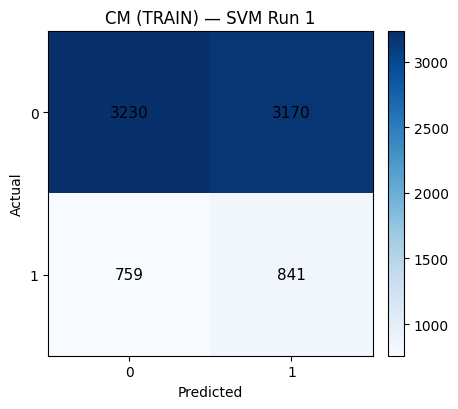

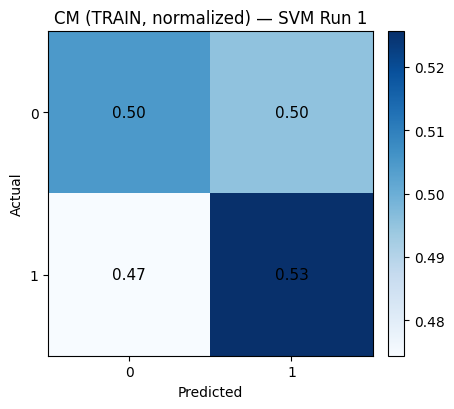


=== Final-Run Metrics: SVM [test] ===
Accuracy: 0.5015
Error rate (1-Acc): 0.4985
Classification Report:
              precision    recall  f1-score   support

           0     0.7947    0.5081    0.6199      1600
           1     0.1945    0.4750    0.2760       400

    accuracy                         0.5015      2000
   macro avg     0.4946    0.4916    0.4479      2000
weighted avg     0.6747    0.5015    0.5511      2000

Confusion Matrix [rows=true, cols=pred]:
[[813 787]
 [210 190]]
Sensitivity (Recall+): 0.4750 | Specificity: 0.5081
Precision (PPV): 0.1945 | NPV: 0.7947
FPR: 0.4919 | FNR: 0.5250 | F1: 0.2760
MCC: -0.0135 | Cohen's kappa: -0.0110 | Balanced Acc: 0.4916
Hamming loss: 0.4985 | Zero-One loss: 0.4985
Prevalence+: 0.2000 | Pred+ rate: 0.4885 | Youden J: -0.0169
Log Loss: 0.7442 | Brier score: 0.2735 | Average Precision (PR-AUC): 0.1893 | ROC-AUC: 0.4800


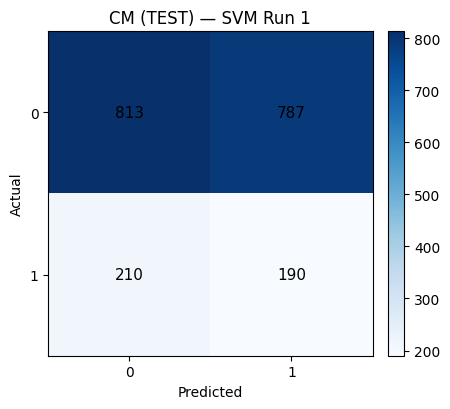

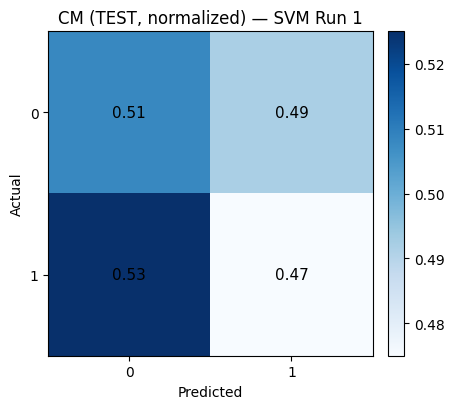

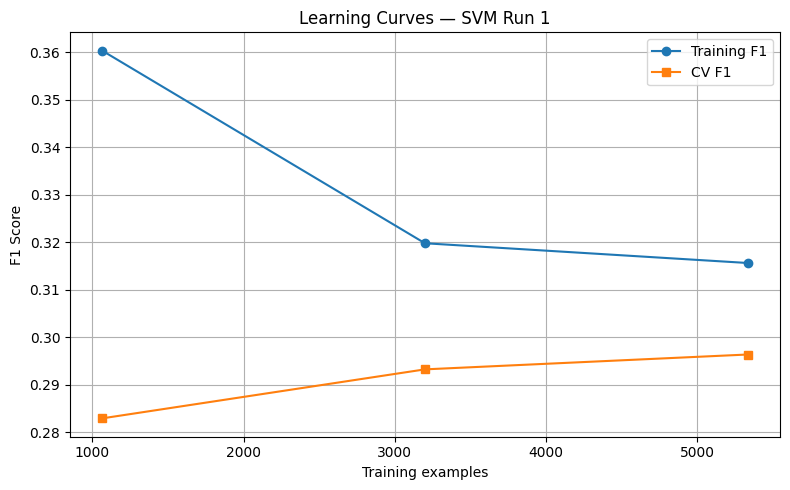

Saved model: imput/svm.joblib

[SVM] Run 2/5

Searching best parameters...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}

Scores for best parameters (CV mean):
ACC : 0.2000
PREC: 0.2000
REC : 1.0000
F1  : 0.3333
AUC : 0.5015

=== Final-Run Metrics: SVM [train] ===
Accuracy: 0.5089
Error rate (1-Acc): 0.4911
Classification Report:
              precision    recall  f1-score   support

           0     0.8097    0.5047    0.6218      6400
           1     0.2097    0.5256    0.2998      1600

    accuracy                         0.5089      8000
   macro avg     0.5097    0.5152    0.4608      8000
weighted avg     0.6897    0.5089    0.5574      8000

Confusion Matrix [rows=true, cols=pred]:
[[3230 3170]
 [ 759  841]]
Sensitivity (Recall+): 0.5256 | Specificity: 0.5047
Precision (PPV): 0.2097 | NPV: 0.8097
FPR: 0.4953 | FNR: 0.4744 | F1: 0.2998
MCC: 0.0243 | Cohen's kappa: 0.0194 | Balanced Acc: 

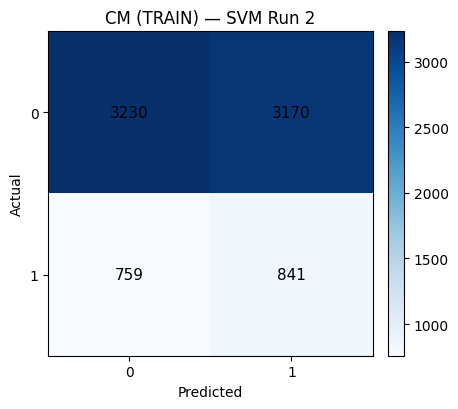

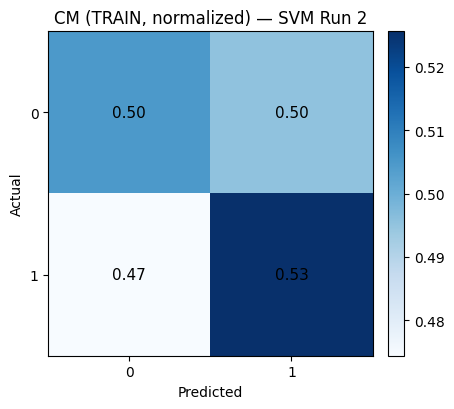


=== Final-Run Metrics: SVM [test] ===
Accuracy: 0.5015
Error rate (1-Acc): 0.4985
Classification Report:
              precision    recall  f1-score   support

           0     0.7947    0.5081    0.6199      1600
           1     0.1945    0.4750    0.2760       400

    accuracy                         0.5015      2000
   macro avg     0.4946    0.4916    0.4479      2000
weighted avg     0.6747    0.5015    0.5511      2000

Confusion Matrix [rows=true, cols=pred]:
[[813 787]
 [210 190]]
Sensitivity (Recall+): 0.4750 | Specificity: 0.5081
Precision (PPV): 0.1945 | NPV: 0.7947
FPR: 0.4919 | FNR: 0.5250 | F1: 0.2760
MCC: -0.0135 | Cohen's kappa: -0.0110 | Balanced Acc: 0.4916
Hamming loss: 0.4985 | Zero-One loss: 0.4985
Prevalence+: 0.2000 | Pred+ rate: 0.4885 | Youden J: -0.0169
Log Loss: 0.7442 | Brier score: 0.2735 | Average Precision (PR-AUC): 0.1893 | ROC-AUC: 0.4800


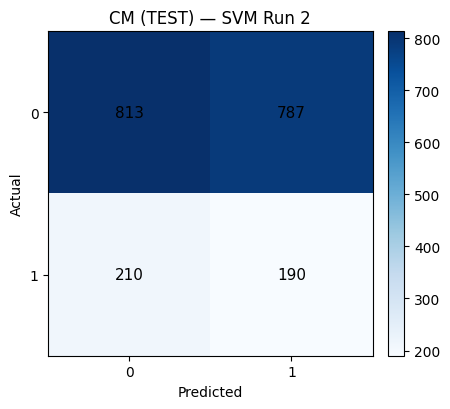

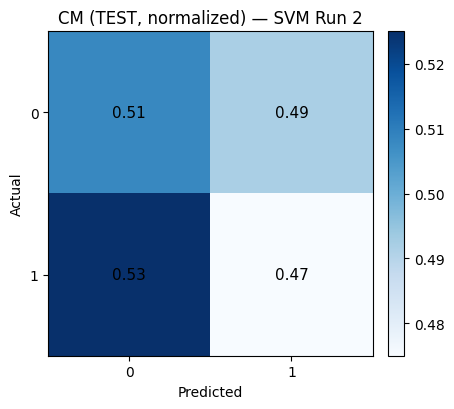

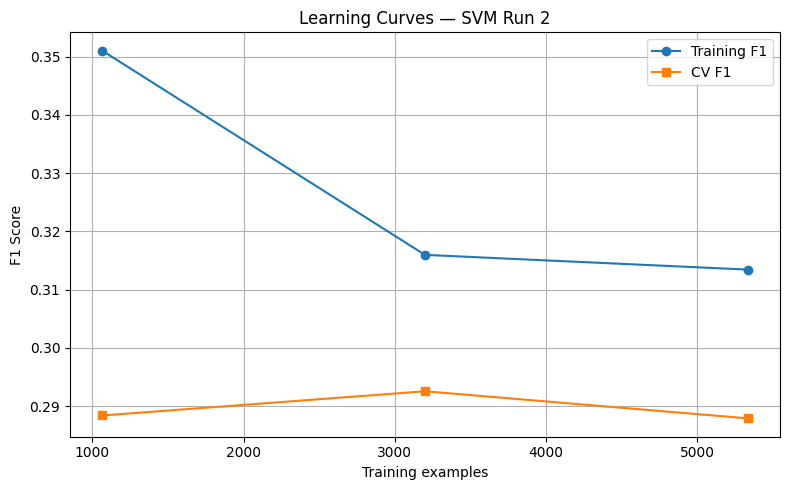

Saved model: imput/svm.joblib

[SVM] Run 3/5

Searching best parameters...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}

Scores for best parameters (CV mean):
ACC : 0.2000
PREC: 0.2000
REC : 1.0000
F1  : 0.3333
AUC : 0.5026

=== Final-Run Metrics: SVM [train] ===
Accuracy: 0.5089
Error rate (1-Acc): 0.4911
Classification Report:
              precision    recall  f1-score   support

           0     0.8097    0.5047    0.6218      6400
           1     0.2097    0.5256    0.2998      1600

    accuracy                         0.5089      8000
   macro avg     0.5097    0.5152    0.4608      8000
weighted avg     0.6897    0.5089    0.5574      8000

Confusion Matrix [rows=true, cols=pred]:
[[3230 3170]
 [ 759  841]]
Sensitivity (Recall+): 0.5256 | Specificity: 0.5047
Precision (PPV): 0.2097 | NPV: 0.8097
FPR: 0.4953 | FNR: 0.4744 | F1: 0.2998
MCC: 0.0243 | Cohen's kappa: 0.0194 | Balanced Acc: 

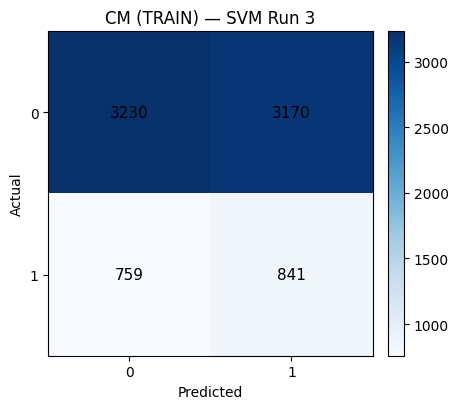

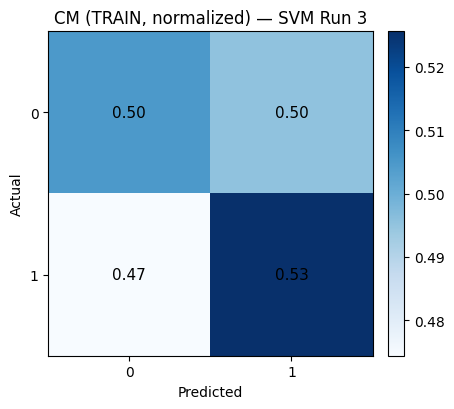


=== Final-Run Metrics: SVM [test] ===
Accuracy: 0.5015
Error rate (1-Acc): 0.4985
Classification Report:
              precision    recall  f1-score   support

           0     0.7947    0.5081    0.6199      1600
           1     0.1945    0.4750    0.2760       400

    accuracy                         0.5015      2000
   macro avg     0.4946    0.4916    0.4479      2000
weighted avg     0.6747    0.5015    0.5511      2000

Confusion Matrix [rows=true, cols=pred]:
[[813 787]
 [210 190]]
Sensitivity (Recall+): 0.4750 | Specificity: 0.5081
Precision (PPV): 0.1945 | NPV: 0.7947
FPR: 0.4919 | FNR: 0.5250 | F1: 0.2760
MCC: -0.0135 | Cohen's kappa: -0.0110 | Balanced Acc: 0.4916
Hamming loss: 0.4985 | Zero-One loss: 0.4985
Prevalence+: 0.2000 | Pred+ rate: 0.4885 | Youden J: -0.0169
Log Loss: 0.7442 | Brier score: 0.2735 | Average Precision (PR-AUC): 0.1893 | ROC-AUC: 0.4800


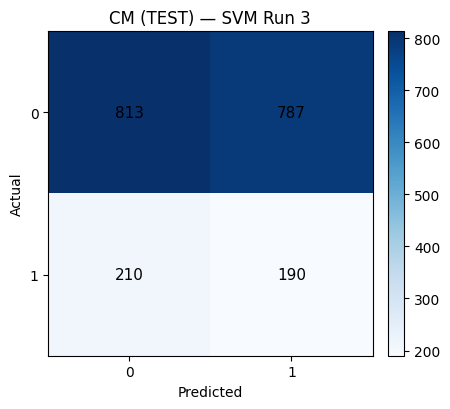

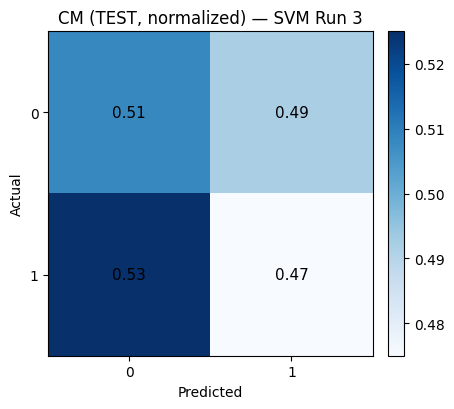

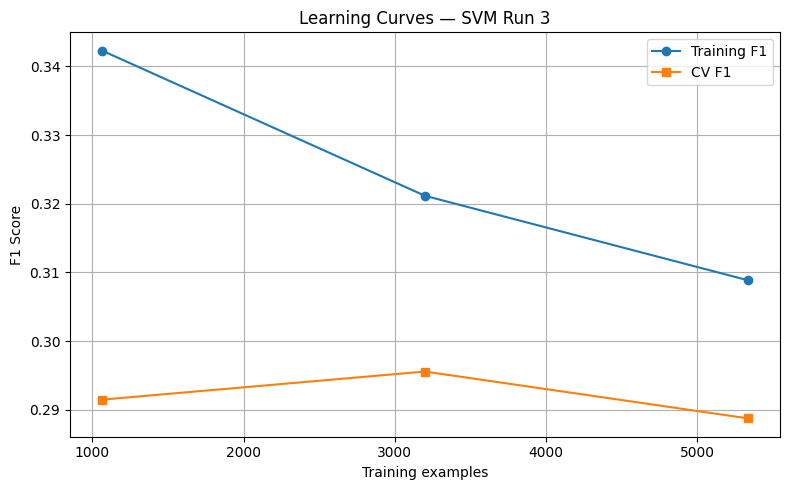

Saved model: imput/svm.joblib

[SVM] Run 4/5

Searching best parameters...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}

Scores for best parameters (CV mean):
ACC : 0.2000
PREC: 0.2000
REC : 1.0000
F1  : 0.3333
AUC : 0.4973

=== Final-Run Metrics: SVM [train] ===
Accuracy: 0.5089
Error rate (1-Acc): 0.4911
Classification Report:
              precision    recall  f1-score   support

           0     0.8097    0.5047    0.6218      6400
           1     0.2097    0.5256    0.2998      1600

    accuracy                         0.5089      8000
   macro avg     0.5097    0.5152    0.4608      8000
weighted avg     0.6897    0.5089    0.5574      8000

Confusion Matrix [rows=true, cols=pred]:
[[3230 3170]
 [ 759  841]]
Sensitivity (Recall+): 0.5256 | Specificity: 0.5047
Precision (PPV): 0.2097 | NPV: 0.8097
FPR: 0.4953 | FNR: 0.4744 | F1: 0.2998
MCC: 0.0243 | Cohen's kappa: 0.0194 | Balanced Acc: 

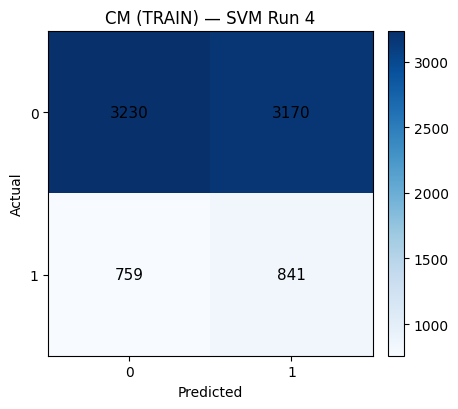

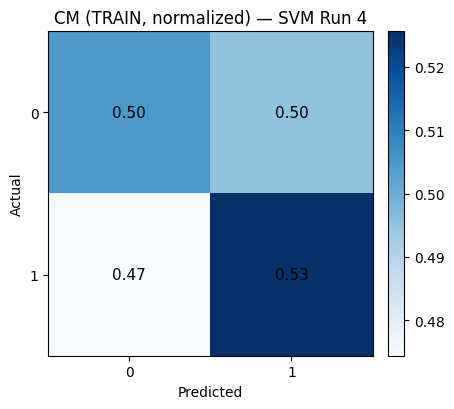


=== Final-Run Metrics: SVM [test] ===
Accuracy: 0.5015
Error rate (1-Acc): 0.4985
Classification Report:
              precision    recall  f1-score   support

           0     0.7947    0.5081    0.6199      1600
           1     0.1945    0.4750    0.2760       400

    accuracy                         0.5015      2000
   macro avg     0.4946    0.4916    0.4479      2000
weighted avg     0.6747    0.5015    0.5511      2000

Confusion Matrix [rows=true, cols=pred]:
[[813 787]
 [210 190]]
Sensitivity (Recall+): 0.4750 | Specificity: 0.5081
Precision (PPV): 0.1945 | NPV: 0.7947
FPR: 0.4919 | FNR: 0.5250 | F1: 0.2760
MCC: -0.0135 | Cohen's kappa: -0.0110 | Balanced Acc: 0.4916
Hamming loss: 0.4985 | Zero-One loss: 0.4985
Prevalence+: 0.2000 | Pred+ rate: 0.4885 | Youden J: -0.0169
Log Loss: 0.7442 | Brier score: 0.2735 | Average Precision (PR-AUC): 0.1893 | ROC-AUC: 0.4800


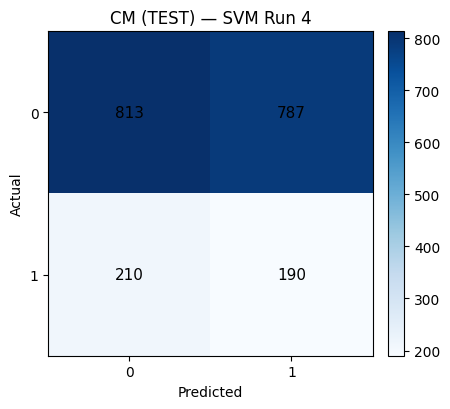

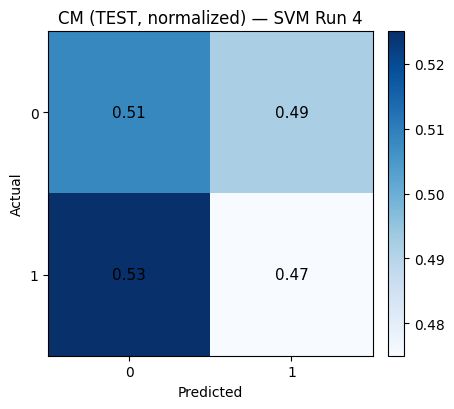

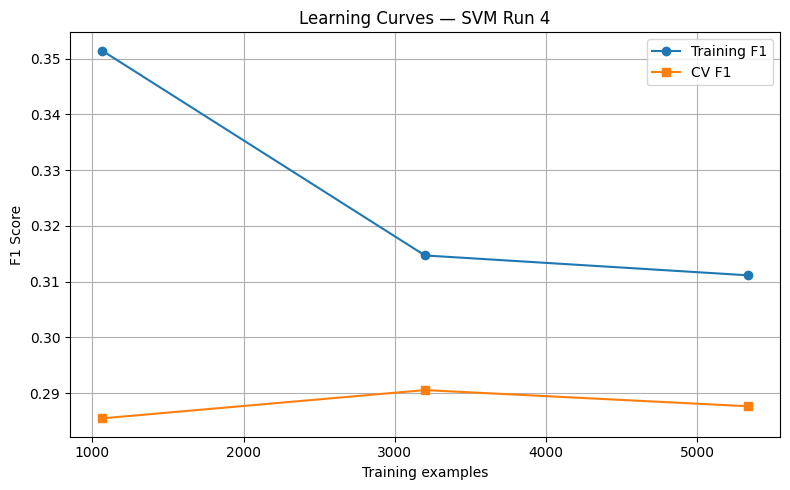

Saved model: imput/svm.joblib

[SVM] Run 5/5

Searching best parameters...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}

Scores for best parameters (CV mean):
ACC : 0.2000
PREC: 0.2000
REC : 1.0000
F1  : 0.3333
AUC : 0.5033

=== Final-Run Metrics: SVM [train] ===
Accuracy: 0.5089
Error rate (1-Acc): 0.4911
Classification Report:
              precision    recall  f1-score   support

           0     0.8097    0.5047    0.6218      6400
           1     0.2097    0.5256    0.2998      1600

    accuracy                         0.5089      8000
   macro avg     0.5097    0.5152    0.4608      8000
weighted avg     0.6897    0.5089    0.5574      8000

Confusion Matrix [rows=true, cols=pred]:
[[3230 3170]
 [ 759  841]]
Sensitivity (Recall+): 0.5256 | Specificity: 0.5047
Precision (PPV): 0.2097 | NPV: 0.8097
FPR: 0.4953 | FNR: 0.4744 | F1: 0.2998
MCC: 0.0243 | Cohen's kappa: 0.0194 | Balanced Acc: 

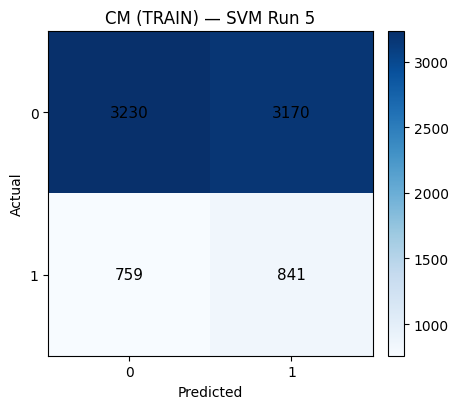

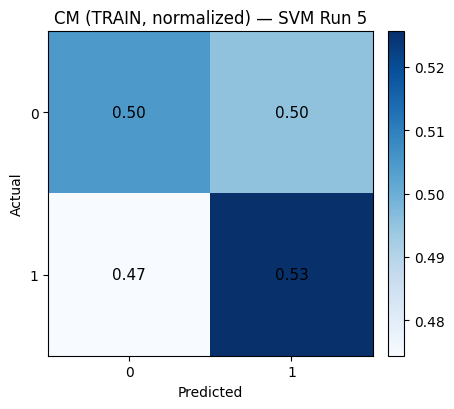


=== Final-Run Metrics: SVM [test] ===
Accuracy: 0.5015
Error rate (1-Acc): 0.4985
Classification Report:
              precision    recall  f1-score   support

           0     0.7947    0.5081    0.6199      1600
           1     0.1945    0.4750    0.2760       400

    accuracy                         0.5015      2000
   macro avg     0.4946    0.4916    0.4479      2000
weighted avg     0.6747    0.5015    0.5511      2000

Confusion Matrix [rows=true, cols=pred]:
[[813 787]
 [210 190]]
Sensitivity (Recall+): 0.4750 | Specificity: 0.5081
Precision (PPV): 0.1945 | NPV: 0.7947
FPR: 0.4919 | FNR: 0.5250 | F1: 0.2760
MCC: -0.0135 | Cohen's kappa: -0.0110 | Balanced Acc: 0.4916
Hamming loss: 0.4985 | Zero-One loss: 0.4985
Prevalence+: 0.2000 | Pred+ rate: 0.4885 | Youden J: -0.0169
Log Loss: 0.7442 | Brier score: 0.2735 | Average Precision (PR-AUC): 0.1893 | ROC-AUC: 0.4800


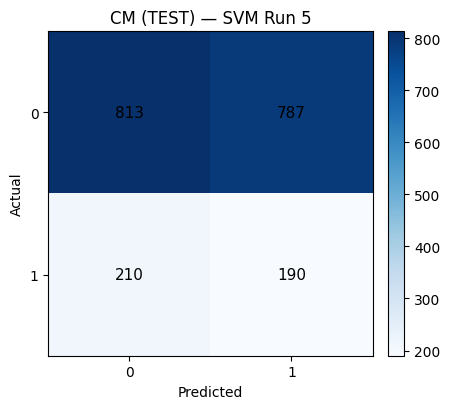

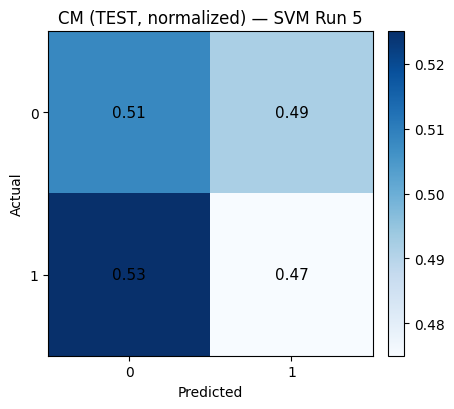

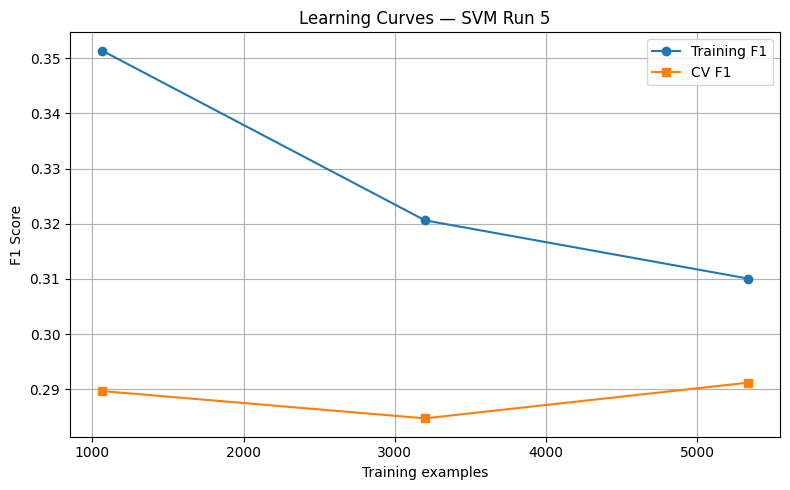

Saved model: imput/svm.joblib

F1 summary (SVM only):
  model  split  n_runs  mean_f1  std_f1  min_f1  max_f1
1   SVM   test      10   0.3046  0.0287  0.2760  0.3333
0   SVM  train      10   0.3166  0.0168  0.2998  0.3333


In [17]:
# ================== SVM (multi-run; metrics per run + CM plots + per-model summary) ==================
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import warnings
from sklearn.exceptions import ConvergenceWarning

MODEL_NAME = "SVM"

# กริดเล็กลง + ไม่ใช้ probability เพื่อความเร็ว (ROC/PR ใช้ decision_function ผ่าน helper อยู่แล้ว)
param_grid_svm = [
    {   # linear
        'kernel': ['linear'],
        'C': [0.1, 1, 10],
        'class_weight': [None, 'balanced'],
    },
    {   # rbf
        'kernel': ['rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale'],
        'class_weight': [None, 'balanced'],
    },
]

# scorers ที่ปลอดภัย (ไม่มี needs_threshold/needs_proba)
_scorers = {
    'accuracy':  'accuracy',
    'precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'recall':    make_scorer(recall_score,    pos_label=1, zero_division=0),
    'f1':        make_scorer(f1_score,        pos_label=1, zero_division=0),
    'roc_auc':   'roc_auc',  # ใช้ decision_function ได้
}
_scorer_f1_safe = _scorers['f1']

# ปรับให้ไวขึ้น: CV=3 และ learning_curve แค่ 3 จุด
for run in range(1, n_runs + 1):
    print("\n" + "="*70); print(f"[{MODEL_NAME}] Run {run}/{n_runs}")
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42 + run)

    grid = GridSearchCV(
        estimator=SVC(cache_size=1000, tol=1e-3, max_iter=2000),  # คงไว้ให้ค้นเร็ว
        param_grid=param_grid_svm,
        cv=skf,
        scoring=_scorers,
        refit='f1',
        n_jobs=-1,
        verbose=1
    )

    print("\nSearching best parameters...")
    # ---- ปิด ConvergenceWarning ระหว่างค้นหา เพื่อไม่ให้ log สแปม ----
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        grid.fit(X_train, y_train)

    best_params, bi = grid.best_params_, grid.best_index_
    print("\nBest parameters:", best_params)
    print("\nScores for best parameters (CV mean):")
    print(f"ACC : {grid.cv_results_['mean_test_accuracy'][bi]:.4f}")
    print(f"PREC: {grid.cv_results_['mean_test_precision'][bi]:.4f}")
    print(f"REC : {grid.cv_results_['mean_test_recall'][bi]:.4f}")
    print(f"F1  : {grid.cv_results_['mean_test_f1'][bi]:.4f}")
    print(f"AUC : {grid.cv_results_['mean_test_roc_auc'][bi]:.4f}")

    # ---- Refit ตัวที่ชนะให้ converge จริง (ไม่จำกัดรอบ/ผ่อน tol หน่อย) ----
    final_params = {**best_params, "cache_size": 2000, "tol": 5e-3, "max_iter": -1}
    best_est = SVC(**final_params)
    best_est.fit(X_train, y_train)

    # ----- TRAIN -----
    y_tr_pred = best_est.predict(X_train)
    y_tr_prob = get_pos_proba_from_estimator(best_est, X_train)  # helper เดิมของหนู
    tr_metrics = log_final_run_metrics(MODEL_NAME, y_train, y_tr_pred, y_tr_prob, roc_data,
                                       split="train", run=run, params=final_params)
    row_tr = save_run_metrics(MODEL_NAME, run, tr_metrics, split="train", params=final_params)
    update_results_scalar(results, MODEL_NAME, "train", tr_metrics, key="f1")

    # CM (TRAIN)
    cm_train_png      = os.path.join(model_dir, f"cm_svm_train_run{run:02d}.png")
    cm_train_norm_png = os.path.join(model_dir, f"cm_svm_train_norm_run{run:02d}.png")
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN) — {MODEL_NAME} Run {run}", cm_train_png, normalize=False)
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN, normalized) — {MODEL_NAME} Run {run}", cm_train_norm_png, normalize=True)
    row_tr["cm_png"] = cm_train_png; row_tr["cm_norm_png"] = cm_train_norm_png

    # ----- TEST -----
    y_te_pred = best_est.predict(X_test)
    y_te_prob = get_pos_proba_from_estimator(best_est, X_test)
    te_metrics = log_final_run_metrics(MODEL_NAME, y_test, y_te_pred, y_te_prob, roc_data,
                                       split="test", run=run, params=final_params)
    row_te = save_run_metrics(MODEL_NAME, run, te_metrics, split="test", params=final_params, is_final=True)
    update_results_scalar(results, MODEL_NAME, "test", te_metrics, key="f1")

    # CM (TEST)
    cm_test_png      = os.path.join(model_dir, f"cm_svm_test_run{run:02d}.png")
    cm_test_norm_png = os.path.join(model_dir, f"cm_svm_test_norm_run{run:02d}.png")
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST) — {MODEL_NAME} Run {run}", cm_test_png, normalize=False)
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST, normalized) — {MODEL_NAME} Run {run}", cm_test_norm_png, normalize=True)
    row_te["cm_png"] = cm_test_png; row_te["cm_norm_png"] = cm_test_norm_png

    # ----- Learning Curve (เบา ๆ; ปิดได้ถ้าต้องการ) -----
    DO_LEARNING_CURVE = True
    if DO_LEARNING_CURVE:
        sizes, tr_scores, cv_scores = learning_curve(
            best_est, X_train, y_train,
            cv=skf, n_jobs=-1, scoring=_scorer_f1_safe,
            train_sizes=[0.2, 0.6, 1.0]
        )
        plt.figure(figsize=(8,5))
        plt.plot(sizes, tr_scores.mean(axis=1), marker='o', label='Training F1')
        plt.plot(sizes, cv_scores.mean(axis=1), marker='s', label='CV F1')
        plt.xlabel('Training examples'); plt.ylabel('F1 Score')
        plt.title(f'Learning Curves — {MODEL_NAME} Run {run}')
        plt.legend(loc='best'); plt.grid(True); plt.tight_layout(); plt.show()

    # ----- Save model ต่อรอบ -----
    try:
        model_path = save_model(MODEL_NAME, best_est, is_dnn=False)
    except Exception:
        os.makedirs("imput", exist_ok=True)
        model_path = os.path.join("imput", f"{MODEL_NAME.lower().replace(' ', '_')}_run{run:02d}.joblib")
        joblib.dump(best_est, model_path); print(f"[Fallback] Saved model: {model_path}")
    # ผูกไฟล์โมเดลกับแถวผลลัพธ์ล่าสุด (TEST ของรันนี้)
    detailed_metrics[-1]["model_path"] = model_path

# per-model tables
df_all = pd.DataFrame(detailed_metrics)
df_svm = df_all[df_all["model"] == MODEL_NAME].copy()
df_svm.to_csv(os.path.join(model_dir, "detailed_metrics_svm.csv"), index=False)

def _summarize_f1_for_model(results_dict, model_name):
    rows = []
    for split in ["train","test"]:
        arr = np.array(results_dict.get(model_name, {}).get(split, []), dtype=float)
        if arr.size == 0: continue
        rows.append({"model":model_name,"split":split,"n_runs":len(arr),
                     "mean_f1":arr.mean(),"std_f1":arr.std(),"min_f1":arr.min(),"max_f1":arr.max()})
    return pd.DataFrame(rows).sort_values(["model","split"])

summary_f1_svm = _summarize_f1_for_model(results, MODEL_NAME)
print("\nF1 summary (SVM only):"); print(summary_f1_svm.round(4))
summary_f1_svm.to_csv(os.path.join(model_dir, "summary_f1_svm.csv"), index=False)
# ==================================================================================================



[DNN] Run 1/5

=== Final-Run Metrics: DNN [train] ===
Accuracy: 0.7788
Error rate (1-Acc): 0.2212
Classification Report:
              precision    recall  f1-score   support

           0     0.8026    0.9594    0.8740      6400
           1     0.2571    0.0563    0.0923      1600

    accuracy                         0.7788      8000
   macro avg     0.5299    0.5078    0.4832      8000
weighted avg     0.6935    0.7788    0.7177      8000

Confusion Matrix [rows=true, cols=pred]:
[[6140  260]
 [1510   90]]
Sensitivity (Recall+): 0.0562 | Specificity: 0.9594
Precision (PPV): 0.2571 | NPV: 0.8026
FPR: 0.0406 | FNR: 0.9437 | F1: 0.0923
MCC: 0.0306 | Cohen's kappa: 0.0221 | Balanced Acc: 0.5078
Hamming loss: 0.2213 | Zero-One loss: 0.2212
Prevalence+: 0.2000 | Pred+ rate: 0.0437 | Youden J: 0.0156
Log Loss: 0.5901 | Brier score: 0.1995 | Average Precision (PR-AUC): 0.2331 | ROC-AUC: 0.5581


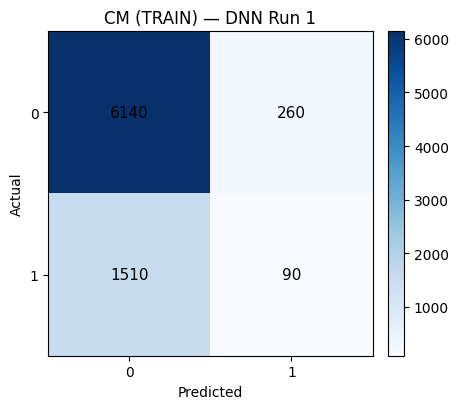

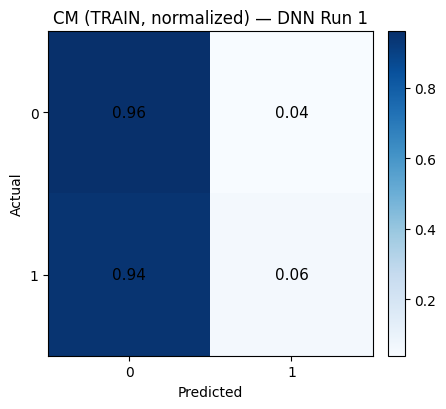

2025-11-04 00:21:39.089025: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



=== Final-Run Metrics: DNN [test] ===
Accuracy: 0.7715
Error rate (1-Acc): 0.2285
Classification Report:
              precision    recall  f1-score   support

           0     0.7981    0.9563    0.8701      1600
           1     0.1566    0.0325    0.0538       400

    accuracy                         0.7715      2000
   macro avg     0.4774    0.4944    0.4619      2000
weighted avg     0.6698    0.7715    0.7068      2000

Confusion Matrix [rows=true, cols=pred]:
[[1530   70]
 [ 387   13]]
Sensitivity (Recall+): 0.0325 | Specificity: 0.9562
Precision (PPV): 0.1566 | NPV: 0.7981
FPR: 0.0437 | FNR: 0.9675 | F1: 0.0538
MCC: -0.0226 | Cohen's kappa: -0.0160 | Balanced Acc: 0.4944
Hamming loss: 0.2285 | Zero-One loss: 0.2285
Prevalence+: 0.2000 | Pred+ rate: 0.0415 | Youden J: -0.0113
Log Loss: 0.5985 | Brier score: 0.2035 | Average Precision (PR-AUC): 0.1857 | ROC-AUC: 0.4794


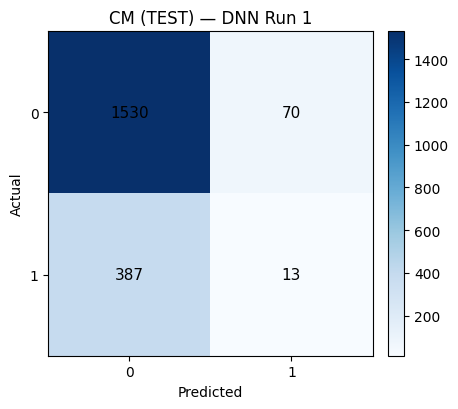

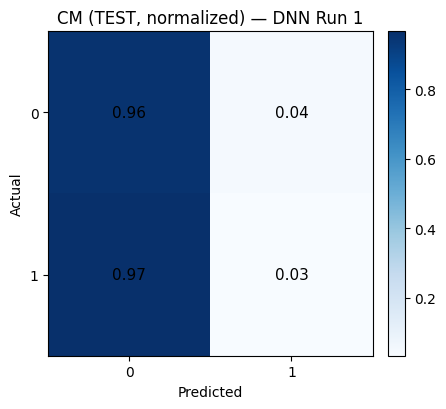

Saved model: imput/dnn.h5

[DNN] Run 2/5

=== Final-Run Metrics: DNN [train] ===
Accuracy: 0.4943
Error rate (1-Acc): 0.5057
Classification Report:
              precision    recall  f1-score   support

           0     0.8947    0.4169    0.5687      6400
           1     0.2563    0.8037    0.3886      1600

    accuracy                         0.4943      8000
   macro avg     0.5755    0.6103    0.4787      8000
weighted avg     0.7670    0.4943    0.5327      8000

Confusion Matrix [rows=true, cols=pred]:
[[2668 3732]
 [ 314 1286]]
Sensitivity (Recall+): 0.8037 | Specificity: 0.4169
Precision (PPV): 0.2563 | NPV: 0.8947
FPR: 0.5831 | FNR: 0.1962 | F1: 0.3886
MCC: 0.1825 | Cohen's kappa: 0.1225 | Balanced Acc: 0.6103
Hamming loss: 0.5058 | Zero-One loss: 0.5057
Prevalence+: 0.2000 | Pred+ rate: 0.6272 | Youden J: 0.2206
Log Loss: 0.5970 | Brier score: 0.2038 | Average Precision (PR-AUC): 0.3364 | ROC-AUC: 0.6694


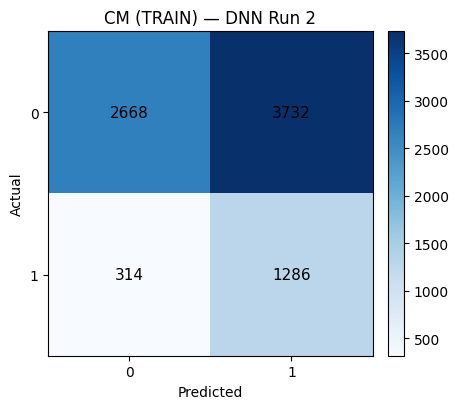

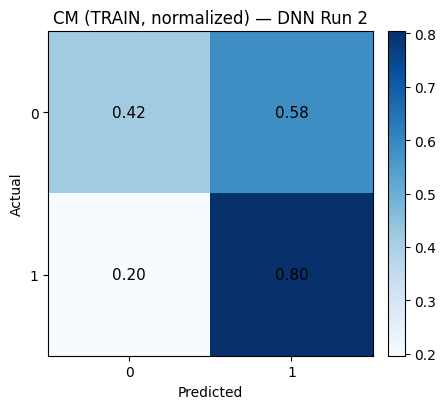

2025-11-04 00:21:45.297157: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



=== Final-Run Metrics: DNN [test] ===
Accuracy: 0.4300
Error rate (1-Acc): 0.5700
Classification Report:
              precision    recall  f1-score   support

           0     0.8059    0.3787    0.5153      1600
           1     0.2035    0.6350    0.3083       400

    accuracy                         0.4300      2000
   macro avg     0.5047    0.5069    0.4118      2000
weighted avg     0.6854    0.4300    0.4739      2000

Confusion Matrix [rows=true, cols=pred]:
[[606 994]
 [146 254]]
Sensitivity (Recall+): 0.6350 | Specificity: 0.3787
Precision (PPV): 0.2035 | NPV: 0.8059
FPR: 0.6212 | FNR: 0.3650 | F1: 0.3083
MCC: 0.0114 | Cohen's kappa: 0.0077 | Balanced Acc: 0.5069
Hamming loss: 0.5700 | Zero-One loss: 0.5700
Prevalence+: 0.2000 | Pred+ rate: 0.6240 | Youden J: 0.0137
Log Loss: 0.6338 | Brier score: 0.2210 | Average Precision (PR-AUC): 0.2095 | ROC-AUC: 0.5148


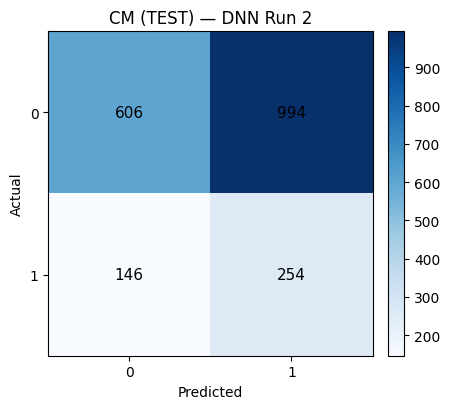

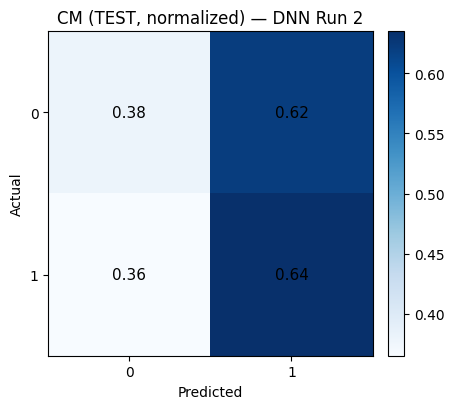

Saved model: imput/dnn.h5

[DNN] Run 3/5

=== Final-Run Metrics: DNN [train] ===
Accuracy: 0.6296
Error rate (1-Acc): 0.3704
Classification Report:
              precision    recall  f1-score   support

           0     0.8182    0.6905    0.7489      6400
           1     0.2378    0.3862    0.2944      1600

    accuracy                         0.6296      8000
   macro avg     0.5280    0.5384    0.5216      8000
weighted avg     0.7021    0.6296    0.6580      8000

Confusion Matrix [rows=true, cols=pred]:
[[4419 1981]
 [ 982  618]]
Sensitivity (Recall+): 0.3862 | Specificity: 0.6905
Precision (PPV): 0.2378 | NPV: 0.8182
FPR: 0.3095 | FNR: 0.6137 | F1: 0.2944
MCC: 0.0655 | Cohen's kappa: 0.0622 | Balanced Acc: 0.5384
Hamming loss: 0.3704 | Zero-One loss: 0.3704
Prevalence+: 0.2000 | Pred+ rate: 0.3249 | Youden J: 0.0767
Log Loss: 0.5589 | Brier score: 0.1849 | Average Precision (PR-AUC): 0.2344 | ROC-AUC: 0.5571


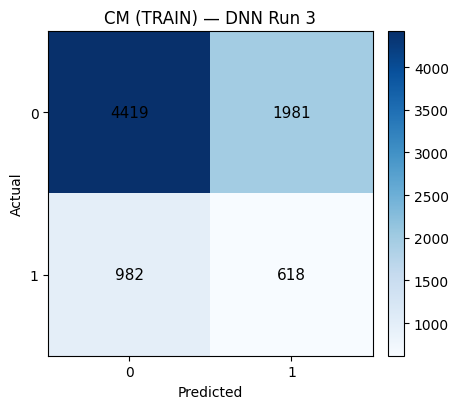

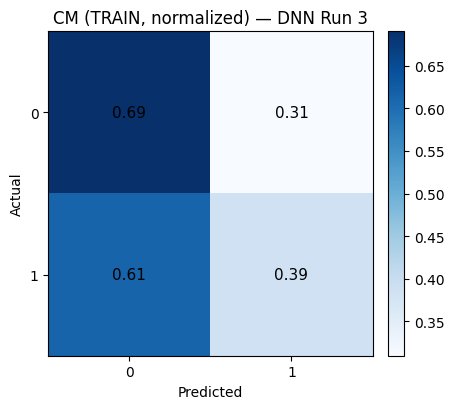

2025-11-04 00:21:51.695061: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



=== Final-Run Metrics: DNN [test] ===
Accuracy: 0.5895
Error rate (1-Acc): 0.4105
Classification Report:
              precision    recall  f1-score   support

           0     0.7896    0.6637    0.7212      1600
           1     0.1786    0.2925    0.2218       400

    accuracy                         0.5895      2000
   macro avg     0.4841    0.4781    0.4715      2000
weighted avg     0.6674    0.5895    0.6213      2000

Confusion Matrix [rows=true, cols=pred]:
[[1062  538]
 [ 283  117]]
Sensitivity (Recall+): 0.2925 | Specificity: 0.6637
Precision (PPV): 0.1786 | NPV: 0.7896
FPR: 0.3362 | FNR: 0.7075 | F1: 0.2218
MCC: -0.0373 | Cohen's kappa: -0.0353 | Balanced Acc: 0.4781
Hamming loss: 0.4105 | Zero-One loss: 0.4105
Prevalence+: 0.2000 | Pred+ rate: 0.3275 | Youden J: -0.0438
Log Loss: 0.5685 | Brier score: 0.1893 | Average Precision (PR-AUC): 0.1895 | ROC-AUC: 0.4813


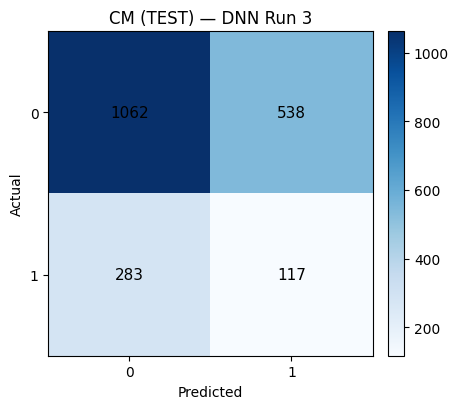

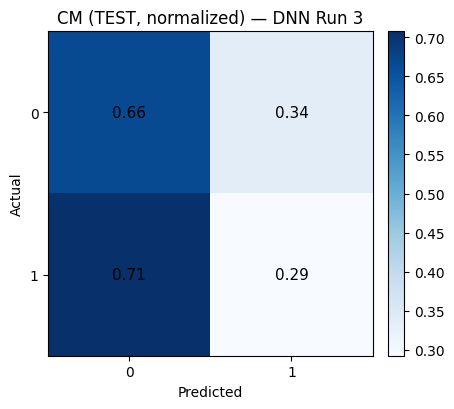

Saved model: imput/dnn.h5

[DNN] Run 4/5

=== Final-Run Metrics: DNN [train] ===
Accuracy: 0.7549
Error rate (1-Acc): 0.2451
Classification Report:
              precision    recall  f1-score   support

           0     0.8080    0.9098    0.8559      6400
           1     0.2724    0.1350    0.1805      1600

    accuracy                         0.7549      8000
   macro avg     0.5402    0.5224    0.5182      8000
weighted avg     0.7008    0.7549    0.7208      8000

Confusion Matrix [rows=true, cols=pred]:
[[5823  577]
 [1384  216]]
Sensitivity (Recall+): 0.1350 | Specificity: 0.9098
Precision (PPV): 0.2724 | NPV: 0.8080
FPR: 0.0902 | FNR: 0.8650 | F1: 0.1805
MCC: 0.0600 | Cohen's kappa: 0.0553 | Balanced Acc: 0.5224
Hamming loss: 0.2451 | Zero-One loss: 0.2451
Prevalence+: 0.2000 | Pred+ rate: 0.0991 | Youden J: 0.0448
Log Loss: 0.5463 | Brier score: 0.1790 | Average Precision (PR-AUC): 0.2372 | ROC-AUC: 0.5611


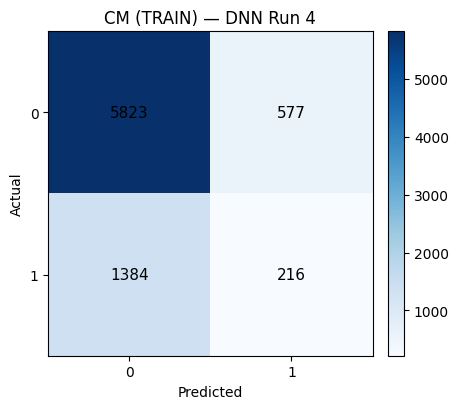

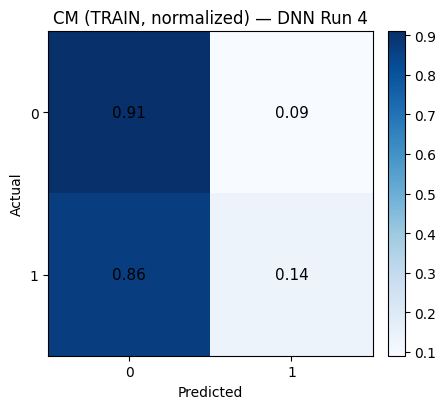

2025-11-04 00:21:59.974457: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



=== Final-Run Metrics: DNN [test] ===
Accuracy: 0.7395
Error rate (1-Acc): 0.2605
Classification Report:
              precision    recall  f1-score   support

           0     0.7996    0.9000    0.8468      1600
           1     0.1960    0.0975    0.1302       400

    accuracy                         0.7395      2000
   macro avg     0.4978    0.4988    0.4885      2000
weighted avg     0.6788    0.7395    0.7035      2000

Confusion Matrix [rows=true, cols=pred]:
[[1440  160]
 [ 361   39]]
Sensitivity (Recall+): 0.0975 | Specificity: 0.9000
Precision (PPV): 0.1960 | NPV: 0.7996
FPR: 0.1000 | FNR: 0.9025 | F1: 0.1302
MCC: -0.0033 | Cohen's kappa: -0.0031 | Balanced Acc: 0.4988
Hamming loss: 0.2605 | Zero-One loss: 0.2605
Prevalence+: 0.2000 | Pred+ rate: 0.0995 | Youden J: -0.0025
Log Loss: 0.5513 | Brier score: 0.1813 | Average Precision (PR-AUC): 0.2017 | ROC-AUC: 0.5002


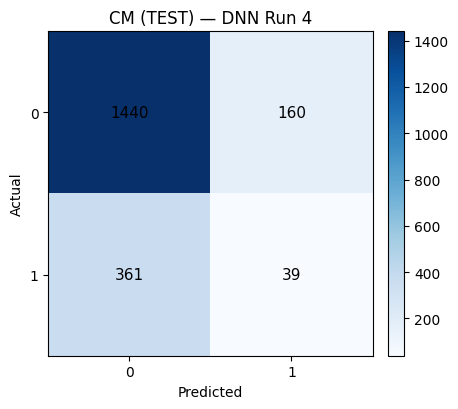

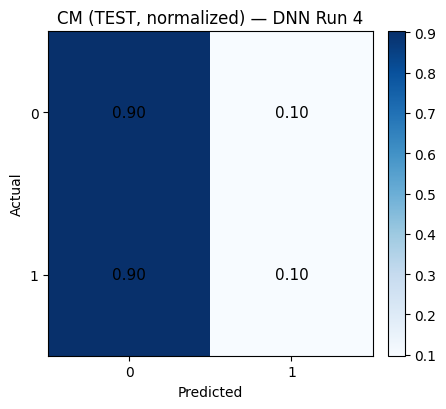

Saved model: imput/dnn.h5

[DNN] Run 5/5

=== Final-Run Metrics: DNN [train] ===
Accuracy: 0.7021
Error rate (1-Acc): 0.2979
Classification Report:
              precision    recall  f1-score   support

           0     0.8130    0.8152    0.8141      6400
           1     0.2527    0.2500    0.2513      1600

    accuracy                         0.7021      8000
   macro avg     0.5328    0.5326    0.5327      8000
weighted avg     0.7009    0.7021    0.7015      8000

Confusion Matrix [rows=true, cols=pred]:
[[5217 1183]
 [1200  400]]
Sensitivity (Recall+): 0.2500 | Specificity: 0.8152
Precision (PPV): 0.2527 | NPV: 0.8130
FPR: 0.1848 | FNR: 0.7500 | F1: 0.2513
MCC: 0.0654 | Cohen's kappa: 0.0654 | Balanced Acc: 0.5326
Hamming loss: 0.2979 | Zero-One loss: 0.2979
Prevalence+: 0.2000 | Pred+ rate: 0.1979 | Youden J: 0.0652
Log Loss: 0.5441 | Brier score: 0.1780 | Average Precision (PR-AUC): 0.2416 | ROC-AUC: 0.5661


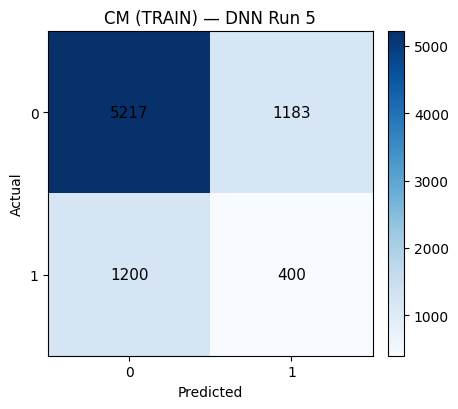

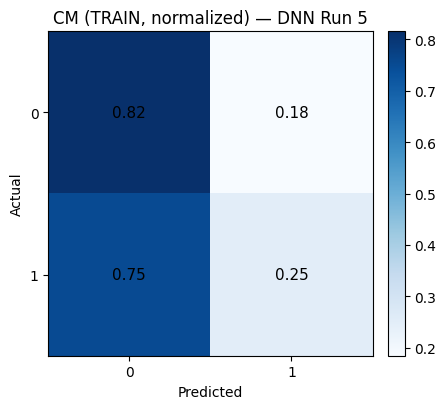

2025-11-04 00:22:05.756670: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



=== Final-Run Metrics: DNN [test] ===
Accuracy: 0.6820
Error rate (1-Acc): 0.3180
Classification Report:
              precision    recall  f1-score   support

           0     0.7975    0.8075    0.8025      1600
           1     0.1895    0.1800    0.1846       400

    accuracy                         0.6820      2000
   macro avg     0.4935    0.4938    0.4935      2000
weighted avg     0.6759    0.6820    0.6789      2000

Confusion Matrix [rows=true, cols=pred]:
[[1292  308]
 [ 328   72]]
Sensitivity (Recall+): 0.1800 | Specificity: 0.8075
Precision (PPV): 0.1895 | NPV: 0.7975
FPR: 0.1925 | FNR: 0.8200 | F1: 0.1846
MCC: -0.0127 | Cohen's kappa: -0.0127 | Balanced Acc: 0.4938
Hamming loss: 0.3180 | Zero-One loss: 0.3180
Prevalence+: 0.2000 | Pred+ rate: 0.1900 | Youden J: -0.0125
Log Loss: 0.5510 | Brier score: 0.1811 | Average Precision (PR-AUC): 0.1958 | ROC-AUC: 0.4790


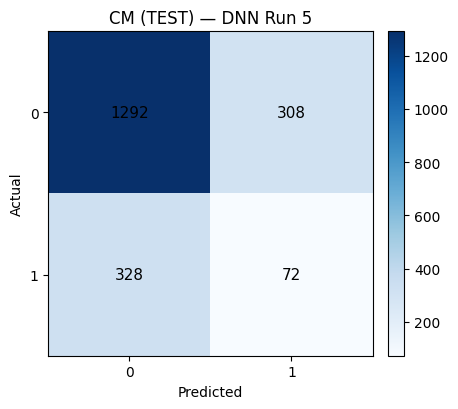

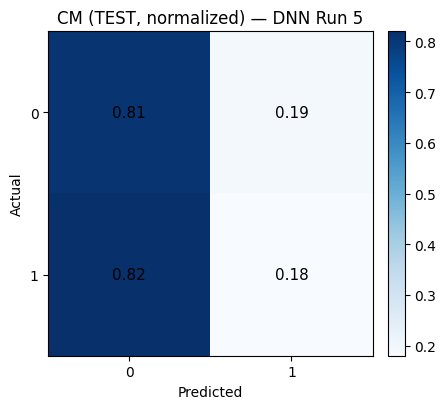

Saved model: imput/dnn.h5

F1 summary (DNN only):
  model  split  n_runs  mean_f1  std_f1  min_f1  max_f1
1   DNN   test       5   0.1797  0.0856  0.0538  0.3083
0   DNN  train       5   0.2414  0.1005  0.0923  0.3886


In [25]:
# ================== DNN (Keras) — multi-run; imbalance-aware + best-threshold ==================
import os, random, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

# ---- Utils (CM) ----
if "plot_cm_and_save" not in globals():
    def plot_cm_and_save(y_true, y_pred, title, out_path, normalize=False):
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        cm_disp = (cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)) if normalize else cm
        fig, ax = plt.subplots(figsize=(4.8, 4.2))
        im = ax.imshow(cm_disp, interpolation='nearest', cmap='Blues')
        ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
        ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xticklabels([0,1]); ax.set_yticklabels([0,1])
        fmt = ".2f" if normalize else "d"
        for (i, j), v in np.ndenumerate(cm_disp):
            ax.text(j, i, format(v, fmt), ha='center', va='center', fontsize=11)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout(); os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=150, bbox_inches='tight'); plt.show()
        return cm

# ---- Safe defaults for shared objects (กัน NameError ถ้าไม่ได้ประกาศมาก่อน) ----
MODEL_NAME = "DNN"
if 'results' not in globals(): results = {}
results.setdefault(MODEL_NAME, {'train': [], 'test': []})
if 'detailed_metrics' not in globals(): detailed_metrics = []
if 'roc_data' not in globals(): roc_data = None
if 'model_dir' not in globals(): 
    model_dir = os.path.join("outputs", MODEL_NAME.lower())
    os.makedirs(model_dir, exist_ok=True)
if 'n_runs' not in globals(): n_runs = 5  # ปรับได้

# ---- Model builder ----
def build_dnn(input_dim, units=(256,128), dropout=0.3, l2=1e-4, lr=1e-3, initial_bias=None):
    bias_init = None if initial_bias is None else keras.initializers.Constant(initial_bias)
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(units[0], kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout),

        layers.Dense(units[1], kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout),

        layers.Dense(1, activation='sigmoid', bias_initializer=bias_init)
    ])
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'), keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
    )
    return model

# ---- Helper: smart indexing for pandas/ndarray ----
def _ix(X, idx):
    if hasattr(X, "iloc"): return X.iloc[idx]
    return X[idx]

# ---- Compute class weights + initial bias from y_train ----
pos = int(np.sum(np.array(y_train) == 1))
neg = int(np.sum(np.array(y_train) == 0))
initial_bias = float(np.log((pos + 1e-7) / (neg + 1e-7))) if (pos>0 and neg>0) else None

classes = np.array([0,1])
cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=np.array(y_train))
class_weight = {int(c): float(w) for c, w in zip(classes, cw_vals)}

# ---- Callbacks common ----
rlrop = callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=0)
es    = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True, verbose=0)

# ================== RUNS ==================
for run in range(1, n_runs + 1):
    print("\n" + "="*70); print(f"[{MODEL_NAME}] Run {run}/{n_runs}")

    # reproducibility per run
    tf.keras.utils.set_random_seed(42 + run)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    # stratified split: 20% ของ X_train เป็น validation
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42 + run)
    idx_tr, idx_val = next(sss.split(np.zeros(len(y_train)), np.array(y_train)))
    X_tr, X_val = _ix(X_train, idx_tr), _ix(X_train, idx_val)
    y_tr_, y_val_ = _ix(y_train, idx_tr), _ix(y_train, idx_val)

    # build & fit
    dnn = build_dnn(X_train.shape[1], units=(256,128), dropout=0.3, l2=1e-4, lr=1e-3, initial_bias=initial_bias)
    _ = dnn.fit(
        X_tr, y_tr_,
        validation_data=(X_val, y_val_),
        epochs=200, batch_size=64,
        callbacks=[rlrop, es],
        class_weight=class_weight,
        verbose=0
    )

    # ----- choose best threshold on validation (Youden's J) -----
    val_prob = dnn.predict(X_val, verbose=0).ravel()
    fpr, tpr, thr = roc_curve(y_val_, val_prob)
    youden = tpr - fpr
    best_thr = float(thr[np.argmax(youden)])

    # ----- TRAIN -----
    y_tr_prob = dnn.predict(X_train, verbose=0).ravel()
    y_tr_pred = (y_tr_prob >= best_thr).astype(int)
    tr_params = {"units":(256,128), "dropout":0.3, "lr":1e-3, "l2":1e-4, "thr":best_thr, "class_weight":class_weight}
    tr_metrics = log_final_run_metrics(MODEL_NAME, y_train, y_tr_pred, y_tr_prob, roc_data,
                                       split="train", run=run, params=tr_params)
    row_tr = save_run_metrics(MODEL_NAME, run, tr_metrics, split="train", params=tr_params)
    results[MODEL_NAME]['train'].append(tr_metrics.get('f1', np.nan))

    # CM (TRAIN)
    cm_train_png      = os.path.join(model_dir, f"cm_dnn_train_run{run:02d}.png")
    cm_train_norm_png = os.path.join(model_dir, f"cm_dnn_train_norm_run{run:02d}.png")
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN) — {MODEL_NAME} Run {run}", cm_train_png, normalize=False)
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN, normalized) — {MODEL_NAME} Run {run}", cm_train_norm_png, normalize=True)
    row_tr["cm_png"] = cm_train_png; row_tr["cm_norm_png"] = cm_train_norm_png

    # ----- TEST -----
    y_te_prob = dnn.predict(X_test, verbose=0).ravel()
    y_te_pred = (y_te_prob >= best_thr).astype(int)
    te_metrics = log_final_run_metrics(MODEL_NAME, y_test, y_te_pred, y_te_prob, roc_data,
                                       split="test", run=run, params=tr_params)
    row_te = save_run_metrics(MODEL_NAME, run, te_metrics, split="test", params=tr_params, is_final=True)
    results[MODEL_NAME]['test'].append(te_metrics.get('f1', np.nan))

    # CM (TEST)
    cm_test_png      = os.path.join(model_dir, f"cm_dnn_test_run{run:02d}.png")
    cm_test_norm_png = os.path.join(model_dir, f"cm_dnn_test_norm_run{run:02d}.png")
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST) — {MODEL_NAME} Run {run}", cm_test_png, normalize=False)
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST, normalized) — {MODEL_NAME} Run {run}", cm_test_norm_png, normalize=True)
    row_te["cm_png"] = cm_test_png; row_te["cm_norm_png"] = cm_test_norm_png

    # ----- Save model per run -----
    try:
        model_path = save_model(MODEL_NAME, dnn, is_dnn=True)
    except Exception:
        os.makedirs("imput", exist_ok=True)  # คง path เดิมของคุณ
        model_path = os.path.join("imput", f"{MODEL_NAME.lower().replace(' ', '_')}_run{run:02d}.h5")
        dnn.save(model_path); print(f"[Fallback] Saved model: {model_path}")
    detailed_metrics[-1]["model_path"] = model_path

# ----- Per-model tables -----
df_all = pd.DataFrame(detailed_metrics)
df_dnn = df_all[df_all["model"] == MODEL_NAME].copy()
df_dnn.to_csv(os.path.join(model_dir, "detailed_metrics_dnn.csv"), index=False)

def _summarize_f1_for_model(results_dict, model_name):
    rows = []
    for split in ["train","test"]:
        arr = np.array(results_dict.get(model_name, {}).get(split, []), dtype=float)
        if arr.size == 0: continue
        rows.append({"model":model_name,"split":split,"n_runs":len(arr),
                     "mean_f1":arr.mean(),"std_f1":arr.std(),"min_f1":arr.min(),"max_f1":arr.max()})
    return pd.DataFrame(rows).sort_values(["model","split"])

summary_f1_dnn = _summarize_f1_for_model(results, MODEL_NAME)
print("\nF1 summary (DNN only):")
try:
    print(summary_f1_dnn.round(4))
except Exception:
    print(summary_f1_dnn)
summary_f1_dnn.to_csv(os.path.join(model_dir, "summary_f1_dnn.csv"), index=False)
# ==================================================================================================



[XGBoost] Run 1/5

Searching best parameters...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_split_loss': 1.0, 'n_estimators': 200, 'reg_lambda': 1, 'scale_pos_weight': 4.0, 'subsample': 1.0}

Scores for best parameters (CV mean):
ACC : 0.5560
PREC: 0.1996
REC : 0.4050
F1  : 0.2674
AUC : 0.5040

=== Final-Run Metrics: XGBoost [train] ===
Accuracy: 0.6707
Error rate (1-Acc): 0.3293
Classification Report:
              precision    recall  f1-score   support

           0     0.9086    0.6542    0.7607      6400
           1     0.3476    0.7369    0.4724      1600

    accuracy                         0.6707      8000
   macro avg     0.6281    0.6955    0.6165      8000
weighted avg     0.7964    0.6707    0.7030      8000

Confusion Matrix [rows=true, cols=pred]:
[[4187 2213]
 [ 421 1179]]
Sensitivity (Recall+): 0.7369 | Specificity: 0.6542
Precision (PPV): 0.3476 | NPV: 0.9086
F

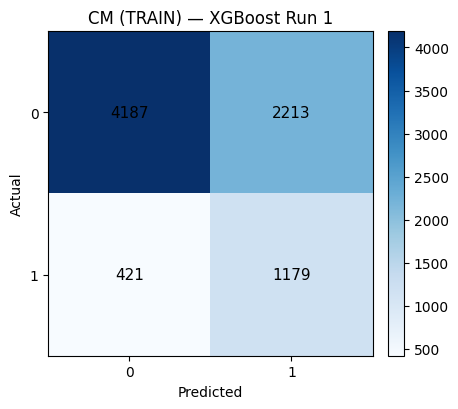

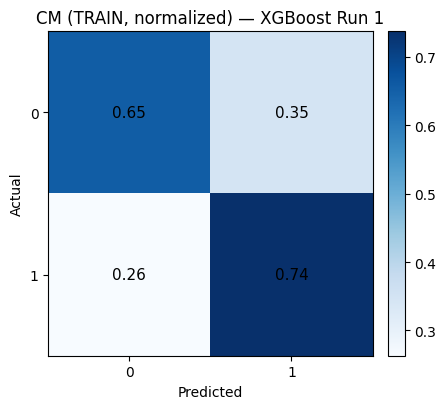


=== Final-Run Metrics: XGBoost [test] ===
Accuracy: 0.5445
Error rate (1-Acc): 0.4555
Classification Report:
              precision    recall  f1-score   support

           0     0.7942    0.5813    0.6712      1600
           1     0.1918    0.3975    0.2587       400

    accuracy                         0.5445      2000
   macro avg     0.4930    0.4894    0.4650      2000
weighted avg     0.6737    0.5445    0.5887      2000

Confusion Matrix [rows=true, cols=pred]:
[[930 670]
 [241 159]]
Sensitivity (Recall+): 0.3975 | Specificity: 0.5812
Precision (PPV): 0.1918 | NPV: 0.7942
FPR: 0.4187 | FNR: 0.6025 | F1: 0.2587
MCC: -0.0173 | Cohen's kappa: -0.0152 | Balanced Acc: 0.4894
Hamming loss: 0.4555 | Zero-One loss: 0.4555
Prevalence+: 0.2000 | Pred+ rate: 0.4145 | Youden J: -0.0213
Log Loss: 0.6814 | Brier score: 0.2442 | Average Precision (PR-AUC): 0.1939 | ROC-AUC: 0.4814


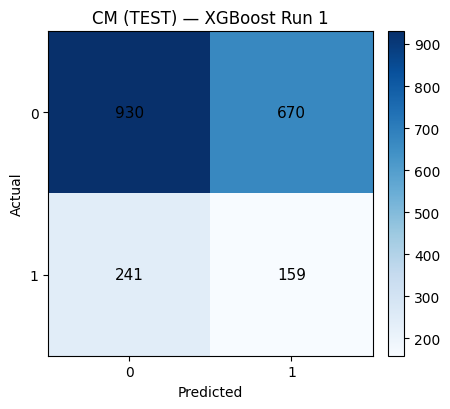

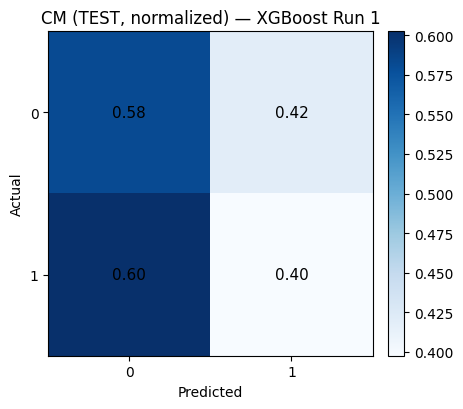

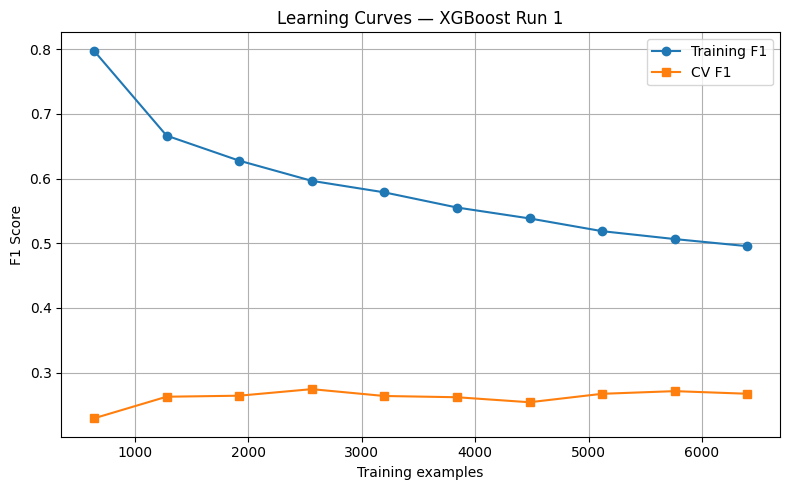

Saved model: imput/xgboost.joblib

[XGBoost] Run 2/5

Searching best parameters...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_split_loss': 0.0, 'n_estimators': 200, 'reg_lambda': 1, 'scale_pos_weight': 4.0, 'subsample': 1.0}

Scores for best parameters (CV mean):
ACC : 0.5601
PREC: 0.2065
REC : 0.4225
F1  : 0.2774
AUC : 0.4988

=== Final-Run Metrics: XGBoost [train] ===
Accuracy: 0.6687
Error rate (1-Acc): 0.3313
Classification Report:
              precision    recall  f1-score   support

           0     0.9085    0.6516    0.7589      6400
           1     0.3460    0.7375    0.4711      1600

    accuracy                         0.6687      8000
   macro avg     0.6273    0.6945    0.6150      8000
weighted avg     0.7960    0.6687    0.7013      8000

Confusion Matrix [rows=true, cols=pred]:
[[4170 2230]
 [ 420 1180]]
Sensitivity (Recall+): 0.7375 | Specificity: 0.6516
Preci

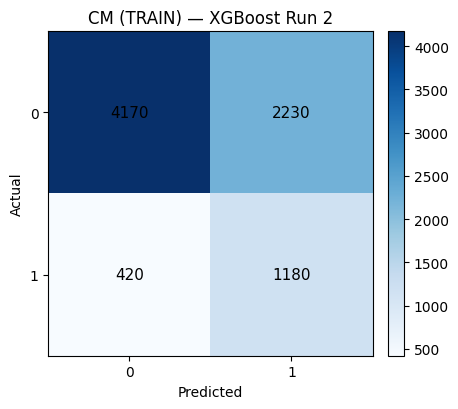

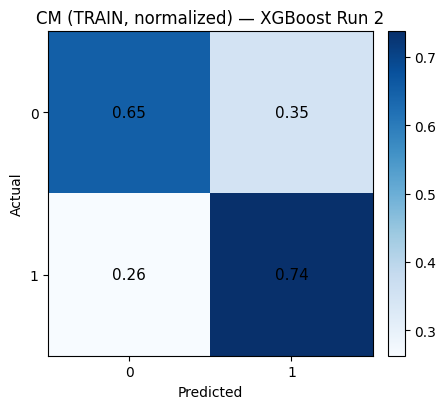


=== Final-Run Metrics: XGBoost [test] ===
Accuracy: 0.5405
Error rate (1-Acc): 0.4595
Classification Report:
              precision    recall  f1-score   support

           0     0.7928    0.5763    0.6674      1600
           1     0.1900    0.3975    0.2571       400

    accuracy                         0.5405      2000
   macro avg     0.4914    0.4869    0.4622      2000
weighted avg     0.6722    0.5405    0.5853      2000

Confusion Matrix [rows=true, cols=pred]:
[[922 678]
 [241 159]]
Sensitivity (Recall+): 0.3975 | Specificity: 0.5762
Precision (PPV): 0.1900 | NPV: 0.7928
FPR: 0.4237 | FNR: 0.6025 | F1: 0.2571
MCC: -0.0213 | Cohen's kappa: -0.0186 | Balanced Acc: 0.4869
Hamming loss: 0.4595 | Zero-One loss: 0.4595
Prevalence+: 0.2000 | Pred+ rate: 0.4185 | Youden J: -0.0263
Log Loss: 0.6812 | Brier score: 0.2441 | Average Precision (PR-AUC): 0.1945 | ROC-AUC: 0.4826


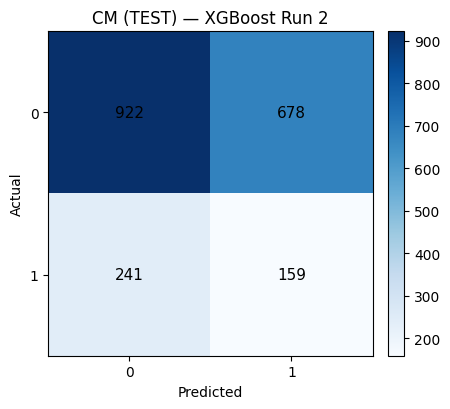

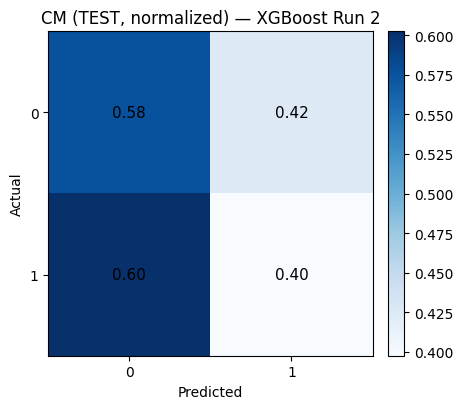

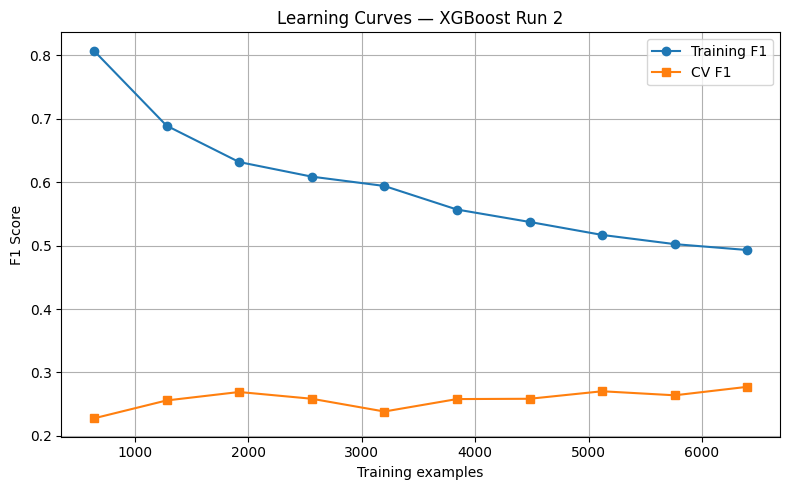

Saved model: imput/xgboost.joblib

[XGBoost] Run 3/5

Searching best parameters...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_split_loss': 0.0, 'n_estimators': 200, 'reg_lambda': 1, 'scale_pos_weight': 4.0, 'subsample': 1.0}

Scores for best parameters (CV mean):
ACC : 0.5551
PREC: 0.2024
REC : 0.4169
F1  : 0.2725
AUC : 0.4965

=== Final-Run Metrics: XGBoost [train] ===
Accuracy: 0.6701
Error rate (1-Acc): 0.3299
Classification Report:
              precision    recall  f1-score   support

           0     0.9054    0.6562    0.7609      6400
           1     0.3454    0.7256    0.4681      1600

    accuracy                         0.6701      8000
   macro avg     0.6254    0.6909    0.6145      8000
weighted avg     0.7934    0.6701    0.7024      8000

Confusion Matrix [rows=true, cols=pred]:
[[4200 2200]
 [ 439 1161]]
Sensitivity (Recall+): 0.7256 | Specificity: 0.6562
Preci

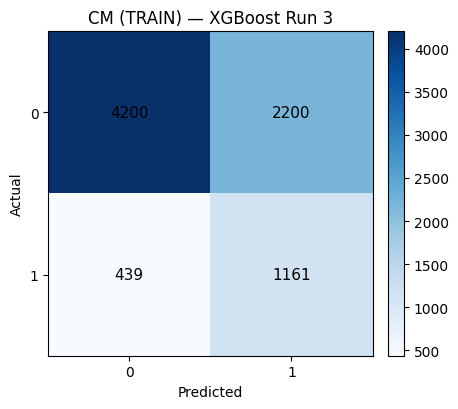

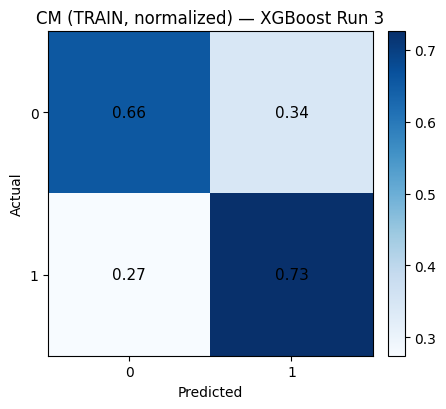


=== Final-Run Metrics: XGBoost [test] ===
Accuracy: 0.5425
Error rate (1-Acc): 0.4575
Classification Report:
              precision    recall  f1-score   support

           0     0.7971    0.5744    0.6676      1600
           1     0.1960    0.4150    0.2662       400

    accuracy                         0.5425      2000
   macro avg     0.4965    0.4947    0.4669      2000
weighted avg     0.6768    0.5425    0.5874      2000

Confusion Matrix [rows=true, cols=pred]:
[[919 681]
 [234 166]]
Sensitivity (Recall+): 0.4150 | Specificity: 0.5744
Precision (PPV): 0.1960 | NPV: 0.7971
FPR: 0.4256 | FNR: 0.5850 | F1: 0.2662
MCC: -0.0086 | Cohen's kappa: -0.0075 | Balanced Acc: 0.4947
Hamming loss: 0.4575 | Zero-One loss: 0.4575
Prevalence+: 0.2000 | Pred+ rate: 0.4235 | Youden J: -0.0106
Log Loss: 0.6806 | Brier score: 0.2438 | Average Precision (PR-AUC): 0.1969 | ROC-AUC: 0.4896


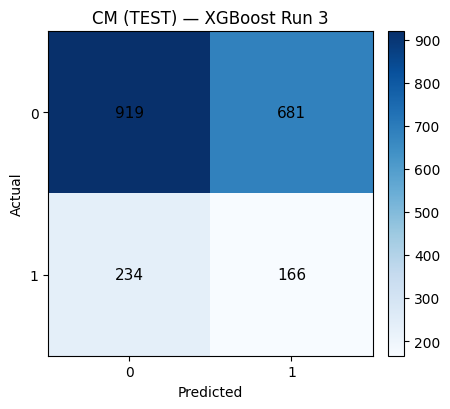

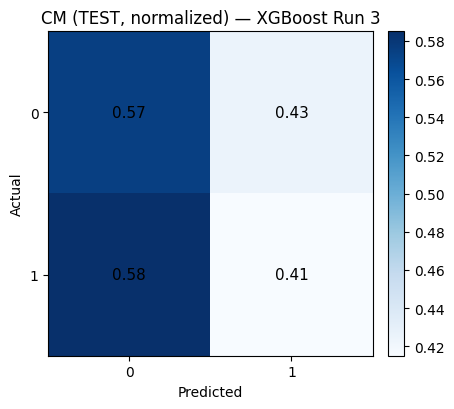

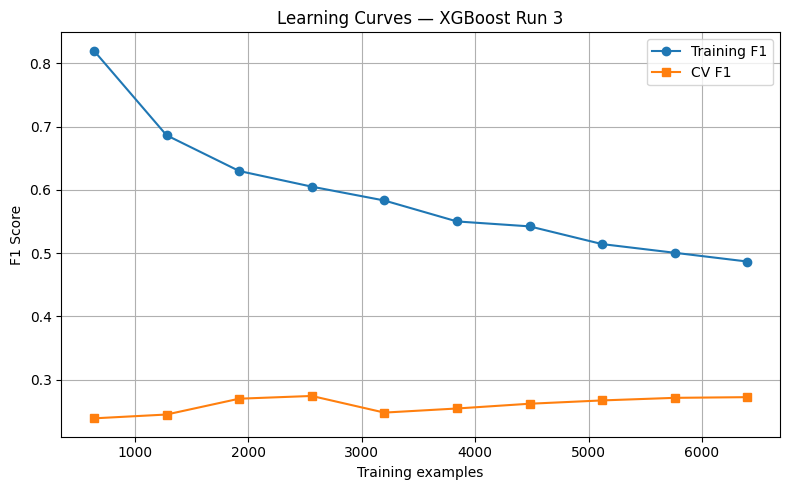

Saved model: imput/xgboost.joblib

[XGBoost] Run 4/5

Searching best parameters...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_split_loss': 1.0, 'n_estimators': 200, 'reg_lambda': 10, 'scale_pos_weight': 4.0, 'subsample': 1.0}

Scores for best parameters (CV mean):
ACC : 0.5674
PREC: 0.2101
REC : 0.4219
F1  : 0.2804
AUC : 0.5120

=== Final-Run Metrics: XGBoost [train] ===
Accuracy: 0.6601
Error rate (1-Acc): 0.3399
Classification Report:
              precision    recall  f1-score   support

           0     0.9021    0.6452    0.7523      6400
           1     0.3365    0.7200    0.4587      1600

    accuracy                         0.6601      8000
   macro avg     0.6193    0.6826    0.6055      8000
weighted avg     0.7890    0.6601    0.6936      8000

Confusion Matrix [rows=true, cols=pred]:
[[4129 2271]
 [ 448 1152]]
Sensitivity (Recall+): 0.7200 | Specificity: 0.6452
Prec

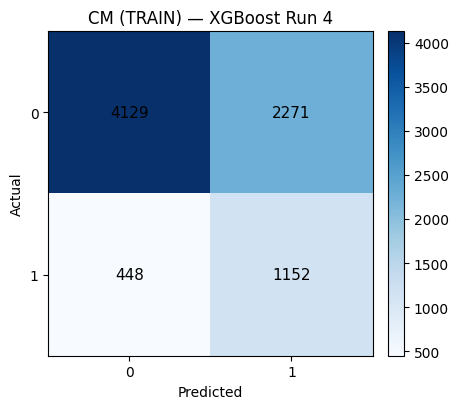

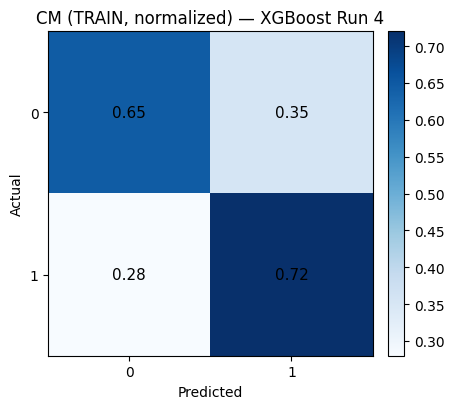


=== Final-Run Metrics: XGBoost [test] ===
Accuracy: 0.5460
Error rate (1-Acc): 0.4540
Classification Report:
              precision    recall  f1-score   support

           0     0.7973    0.5800    0.6715      1600
           1     0.1962    0.4100    0.2654       400

    accuracy                         0.5460      2000
   macro avg     0.4967    0.4950    0.4684      2000
weighted avg     0.6770    0.5460    0.5903      2000

Confusion Matrix [rows=true, cols=pred]:
[[928 672]
 [236 164]]
Sensitivity (Recall+): 0.4100 | Specificity: 0.5800
Precision (PPV): 0.1962 | NPV: 0.7973
FPR: 0.4200 | FNR: 0.5900 | F1: 0.2654
MCC: -0.0081 | Cohen's kappa: -0.0071 | Balanced Acc: 0.4950
Hamming loss: 0.4540 | Zero-One loss: 0.4540
Prevalence+: 0.2000 | Pred+ rate: 0.4180 | Youden J: -0.0100
Log Loss: 0.6839 | Brier score: 0.2455 | Average Precision (PR-AUC): 0.1910 | ROC-AUC: 0.4804


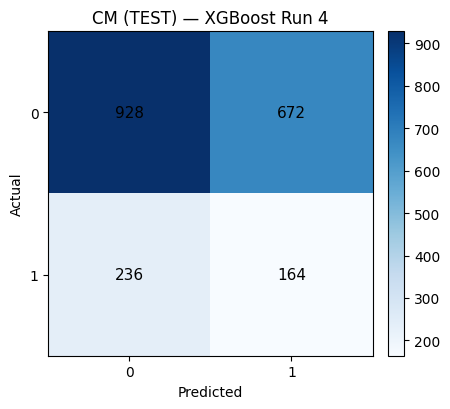

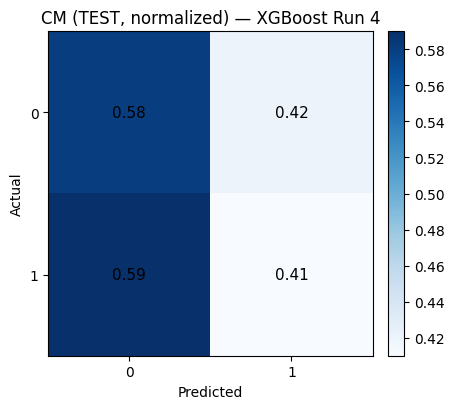

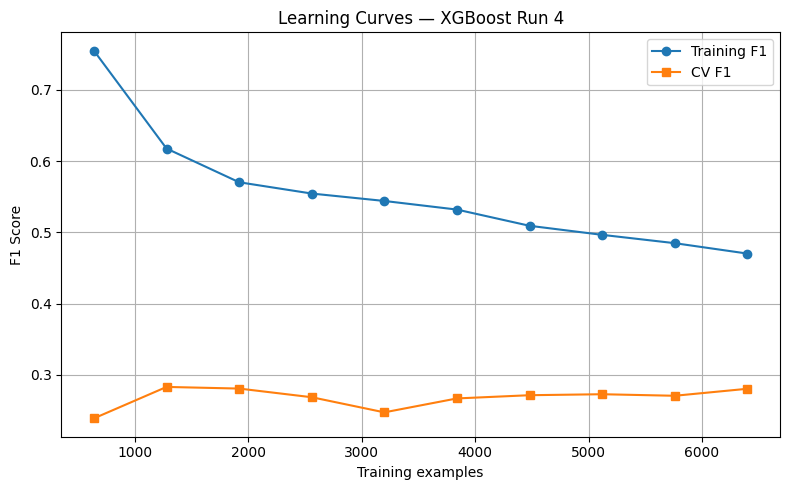

Saved model: imput/xgboost.joblib

[XGBoost] Run 5/5

Searching best parameters...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_split_loss': 0.0, 'n_estimators': 200, 'reg_lambda': 1, 'scale_pos_weight': 4.0, 'subsample': 0.8}

Scores for best parameters (CV mean):
ACC : 0.5766
PREC: 0.2102
REC : 0.4050
F1  : 0.2768
AUC : 0.5071

=== Final-Run Metrics: XGBoost [train] ===
Accuracy: 0.6905
Error rate (1-Acc): 0.3095
Classification Report:
              precision    recall  f1-score   support

           0     0.9098    0.6806    0.7787      6400
           1     0.3636    0.7300    0.4855      1600

    accuracy                         0.6905      8000
   macro avg     0.6367    0.7053    0.6321      8000
weighted avg     0.8005    0.6905    0.7200      8000

Confusion Matrix [rows=true, cols=pred]:
[[4356 2044]
 [ 432 1168]]
Sensitivity (Recall+): 0.7300 | Specificity: 0.6806
Preci

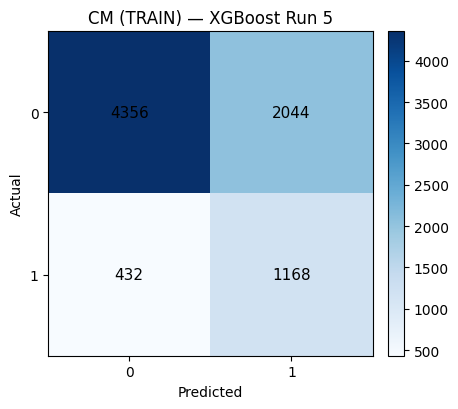

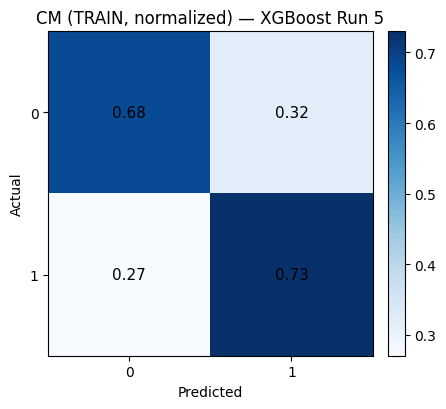


=== Final-Run Metrics: XGBoost [test] ===
Accuracy: 0.5485
Error rate (1-Acc): 0.4515
Classification Report:
              precision    recall  f1-score   support

           0     0.7864    0.5981    0.6794      1600
           1     0.1788    0.3500    0.2367       400

    accuracy                         0.5485      2000
   macro avg     0.4826    0.4741    0.4581      2000
weighted avg     0.6648    0.5485    0.5909      2000

Confusion Matrix [rows=true, cols=pred]:
[[957 643]
 [260 140]]
Sensitivity (Recall+): 0.3500 | Specificity: 0.5981
Precision (PPV): 0.1788 | NPV: 0.7864
FPR: 0.4019 | FNR: 0.6500 | F1: 0.2367
MCC: -0.0425 | Cohen's kappa: -0.0382 | Balanced Acc: 0.4741
Hamming loss: 0.4515 | Zero-One loss: 0.4515
Prevalence+: 0.2000 | Pred+ rate: 0.3915 | Youden J: -0.0519
Log Loss: 0.6791 | Brier score: 0.2431 | Average Precision (PR-AUC): 0.1934 | ROC-AUC: 0.4797


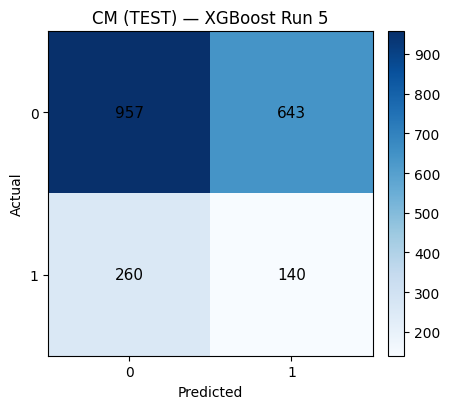

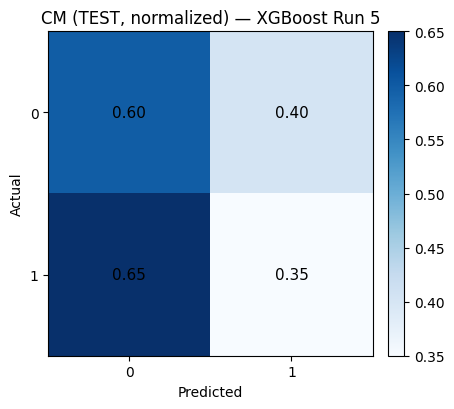

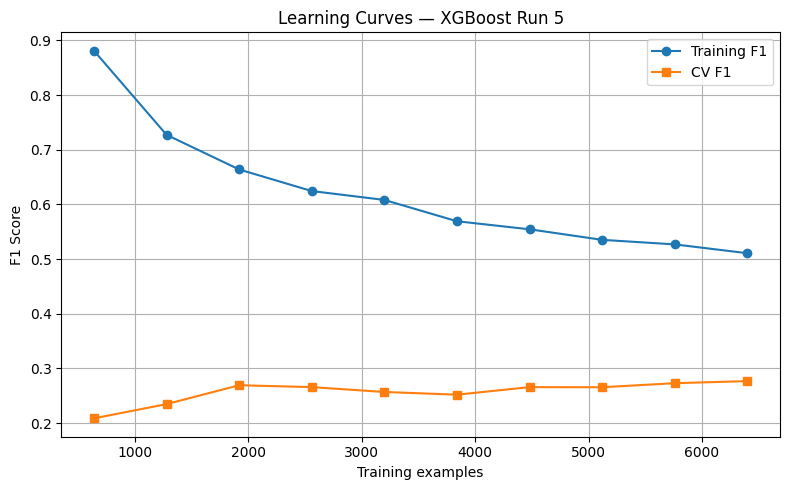

Saved model: imput/xgboost.joblib

F1 summary (XGBoost only):
     model  split  n_runs  mean_f1  std_f1  min_f1  max_f1
1  XGBoost   test       6   0.2571  0.0098  0.2367  0.2662
0  XGBoost  train       6   0.4713  0.0079  0.4587  0.4855


In [31]:
# ================== XGBoost (multi-run; metrics per run + CM plots + per-model summary) ==================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import confusion_matrix

try:
    model_dir
except NameError:
    model_dir = "imput"
os.makedirs(model_dir, exist_ok=True)

if "plot_cm_and_save" not in globals():
    def plot_cm_and_save(y_true, y_pred, title, out_path, normalize=False):
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        cm_disp = (cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)) if normalize else cm
        fig, ax = plt.subplots(figsize=(4.8, 4.2))
        im = ax.imshow(cm_disp, interpolation='nearest', cmap='Blues')
        ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
        ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xticklabels([0,1]); ax.set_yticklabels([0,1])
        fmt = ".2f" if normalize else "d"
        for (i, j), v in np.ndenumerate(cm_disp):
            ax.text(j, i, format(v, fmt), ha='center', va='center', fontsize=11)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout(); os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=150, bbox_inches='tight'); plt.show()
        return cm

MODEL_NAME = "XGBoost"

try:
    from xgboost import XGBClassifier

    # จัดการ imbalance ด้วย scale_pos_weight
    pos = int((y_train == 1).sum()); neg = int((y_train == 0).sum())
    spw = (neg / max(pos, 1.0)) if pos > 0 else 1.0

    base_xgb = XGBClassifier(
       objective='binary:logistic',
    eval_metric='aucpr',   # เดิม 'logloss' → ใช้ AUC-PR ดีกว่าในเคส imbalance
    n_jobs=-1,
    tree_method='hist',
    random_state=42,
    verbosity=0  
    )

    param_grid_xgb = {
    'n_estimators': [200, 500],
    'max_depth': [3, 5, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 10],
    'min_split_loss': [0.0, 1.0],  # เดิม 'gamma'
    'scale_pos_weight': [spw],
    }

    for run in range(1, n_runs + 1):
        print("\n" + "="*70); print(f"[{MODEL_NAME}] Run {run}/{n_runs}")
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + run)

        grid = GridSearchCV(
            estimator=base_xgb,
            param_grid=param_grid_xgb,
            cv=skf,
            scoring=['accuracy','precision','recall','f1','roc_auc'],
            refit='f1',
            n_jobs=-1,
            verbose=1
        )

        print("\nSearching best parameters...")
        grid.fit(X_train, y_train)
        best_est, best_params, bi = grid.best_estimator_, grid.best_params_, grid.best_index_

        print("\nBest parameters:", best_params)
        print("\nScores for best parameters (CV mean):")
        print(f"ACC : {grid.cv_results_['mean_test_accuracy'][bi]:.4f}")
        print(f"PREC: {grid.cv_results_['mean_test_precision'][bi]:.4f}")
        print(f"REC : {grid.cv_results_['mean_test_recall'][bi]:.4f}")
        print(f"F1  : {grid.cv_results_['mean_test_f1'][bi]:.4f}")
        print(f"AUC : {grid.cv_results_['mean_test_roc_auc'][bi]:.4f}")

        # ----- TRAIN -----
        y_tr_pred = best_est.predict(X_train)
        y_tr_prob = best_est.predict_proba(X_train)[:, 1]
        tr_metrics = log_final_run_metrics(MODEL_NAME, y_train, y_tr_pred, y_tr_prob, roc_data,
                                           split="train", run=run, params=best_params)
        row_tr = save_run_metrics(MODEL_NAME, run, tr_metrics, split="train", params=best_params)
        results[MODEL_NAME]['train'].append(tr_metrics.get('f1', np.nan))

        # CM (TRAIN)
        cm_train_png      = os.path.join(model_dir, f"cm_xgb_train_run{run:02d}.png")
        cm_train_norm_png = os.path.join(model_dir, f"cm_xgb_train_norm_run{run:02d}.png")
        plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN) — {MODEL_NAME} Run {run}", cm_train_png, normalize=False)
        plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN, normalized) — {MODEL_NAME} Run {run}", cm_train_norm_png, normalize=True)
        row_tr["cm_png"] = cm_train_png; row_tr["cm_norm_png"] = cm_train_norm_png

        # ----- TEST -----
        y_te_pred = best_est.predict(X_test)
        y_te_prob = best_est.predict_proba(X_test)[:, 1]
        te_metrics = log_final_run_metrics(MODEL_NAME, y_test, y_te_pred, y_te_prob, roc_data,
                                           split="test", run=run, params=best_params)
        row_te = save_run_metrics(MODEL_NAME, run, te_metrics, split="test", params=best_params, is_final=True)
        results[MODEL_NAME]['test'].append(te_metrics.get('f1', np.nan))

        # CM (TEST)
        cm_test_png      = os.path.join(model_dir, f"cm_xgb_test_run{run:02d}.png")
        cm_test_norm_png = os.path.join(model_dir, f"cm_xgb_test_norm_run{run:02d}.png")
        plot_cm_and_save(y_test, y_te_pred, f"CM (TEST) — {MODEL_NAME} Run {run}", cm_test_png, normalize=False)
        plot_cm_and_save(y_test, y_te_pred, f"CM (TEST, normalized) — {MODEL_NAME} Run {run}", cm_test_norm_png, normalize=True)
        row_te["cm_png"] = cm_test_png; row_te["cm_norm_png"] = cm_test_norm_png

        # ----- Learning Curve -----
        sizes, tr_scores, cv_scores = learning_curve(
            best_est, X_train, y_train,
            cv=skf, n_jobs=-1, scoring='f1',
            train_sizes=np.linspace(0.1, 1.0, 10)
        )
        plt.figure(figsize=(8,5))
        plt.plot(sizes, tr_scores.mean(axis=1), marker='o', label='Training F1')
        plt.plot(sizes, cv_scores.mean(axis=1), marker='s', label='CV F1')
        plt.xlabel('Training examples'); plt.ylabel('F1 Score')
        plt.title(f'Learning Curves — {MODEL_NAME} Run {run}')
        plt.legend(loc='best'); plt.grid(True); plt.tight_layout(); plt.show()

        # ----- Save model ต่อรอบ -----
        try:
            model_path = save_model(MODEL_NAME, best_est, is_dnn=False)
        except Exception:
            os.makedirs("imput", exist_ok=True)
            model_path = os.path.join("imput", f"{MODEL_NAME.lower().replace(' ', '_')}_run{run:02d}.joblib")
            joblib.dump(best_est, model_path); print(f"[Fallback] Saved model: {model_path}")
        detailed_metrics[-1]["model_path"] = model_path

    # per-model tables
    df_all = pd.DataFrame(detailed_metrics); df_xgb = df_all[df_all["model"] == MODEL_NAME].copy()
    df_xgb.to_csv(os.path.join(model_dir, "detailed_metrics_xgboost.csv"), index=False)

    def _summarize_f1_for_model(results_dict, model_name):
        rows = []
        for split in ["train","test"]:
            arr = np.array(results_dict.get(model_name, {}).get(split, []), dtype=float)
            if arr.size == 0: continue
            rows.append({"model":model_name,"split":split,"n_runs":len(arr),
                         "mean_f1":arr.mean(),"std_f1":arr.std(),"min_f1":arr.min(),"max_f1":arr.max()})
        return pd.DataFrame(rows).sort_values(["model","split"])

    summary_f1_xgb = _summarize_f1_for_model(results, MODEL_NAME)
    print("\nF1 summary (XGBoost only):"); print(summary_f1_xgb.round(4))
    summary_f1_xgb.to_csv(os.path.join(model_dir, "summary_f1_xgboost.csv"), index=False)

except Exception as e:
    print("[XGBoost] ข้าม: ต้องติดตั้งแพ็กเกจ 'xgboost' ก่อน (pip install xgboost)")
    print("รายละเอียด:", repr(e))
# ==================================================================================================



=== Overall Summary (mean/std/min/max per model & split) ===
              model split  accuracy_mean  accuracy_std  accuracy_min  accuracy_max  error_rate_mean  error_rate_std  error_rate_min  error_rate_max  sensitivity_mean  sensitivity_std  sensitivity_min  sensitivity_max  specificity_mean  specificity_std  specificity_min  specificity_max  precision_pos_mean  precision_pos_std  precision_pos_min  precision_pos_max  npv_mean  npv_std  npv_min  npv_max  fpr_mean  fpr_std  fpr_min  fpr_max  fnr_mean  fnr_std  fnr_min  fnr_max  f1_mean  f1_std  f1_min  f1_max  mcc_mean  mcc_std  mcc_min  mcc_max  kappa_mean  kappa_std  kappa_min  kappa_max  balanced_accuracy_mean  balanced_accuracy_std  balanced_accuracy_min  balanced_accuracy_max
                DNN  test         0.6425        0.1375        0.4300        0.7715           0.3575          0.1375          0.2285          0.5700            0.2475           0.2374           0.0325           0.6350            0.7412           0.2309     

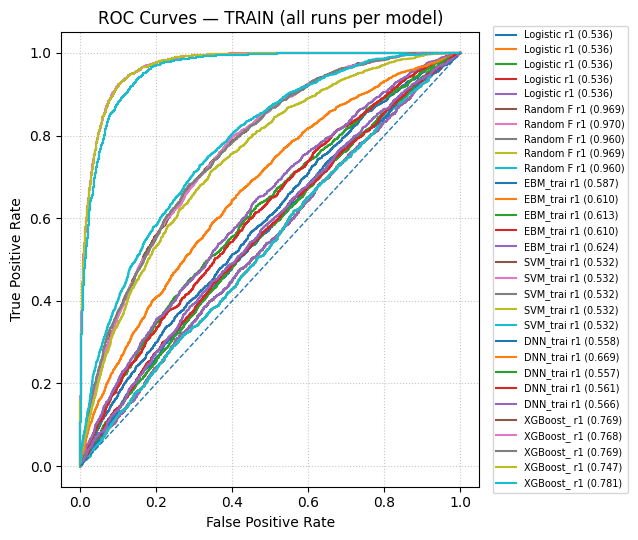

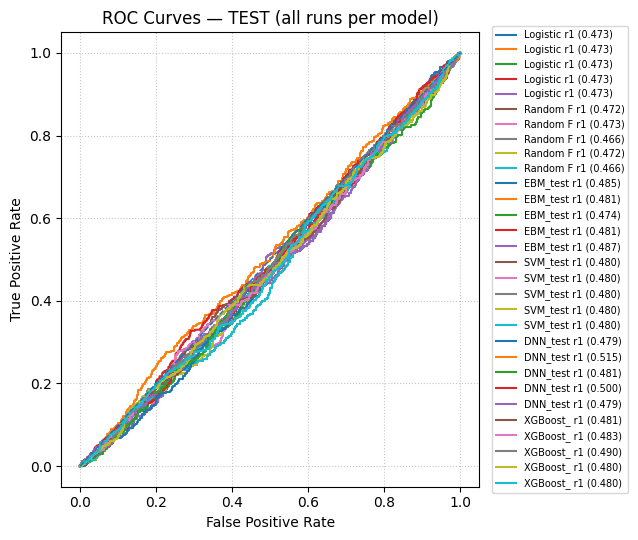

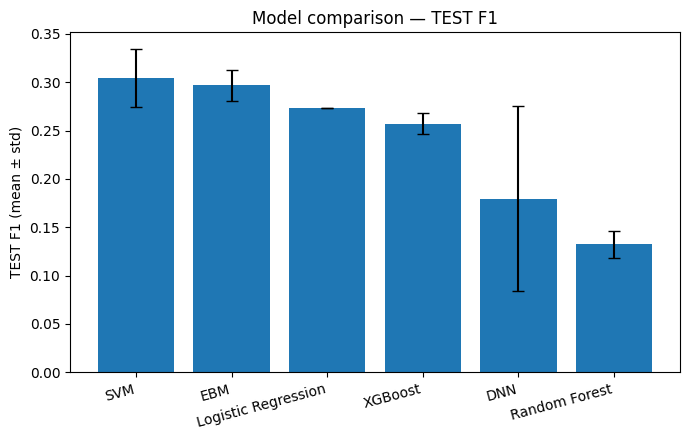

[Saved] -> imput/bar_TEST_F1_mean_std.png

[Done] Wrote: 
- imput/summary_all_metrics.csv
- imput/leaderboard_f1_test.csv
- imput/pivot_mean_f1_train_test.csv
- (no params table)


In [39]:
# ================== OVERALL SUMMARY & COMPARISON ==================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt

os.makedirs(model_dir, exist_ok=True)

# 1) รวมทุก run/ทุกโมเดลจาก detailed_metrics
df = pd.DataFrame(detailed_metrics).copy()

# กันกรณีบางเวอร์ชัน save_run_metrics ไม่มีคอลัมน์ split ให้เดาเอาจาก is_final
if "split" not in df.columns:
    df["split"] = np.where(df.get("is_final", False), "test", "train")

# เลือก metric ที่มีจริงใน df
metric_cols = [
    'accuracy','error_rate','sensitivity','specificity','precision_pos','npv',
    'fpr','fnr','f1','mcc','kappa','balanced_accuracy'
]
metric_cols = [c for c in metric_cols if c in df.columns]

# 2) ตารางสรุป mean/std/min/max ต่อ model & split (ครอบคลุมหลาย metric)
summary_all = (
    df.groupby(["model","split"])[metric_cols]
      .agg(['mean','std','min','max'])
      .reset_index()
)
# ทำคอลัมน์ชื่อแบนราบ (model, split, f1_mean, f1_std, ...)
summary_all.columns = [
    f"{a}_{b}".strip("_") if b else a
    for (a, b) in pd.MultiIndex.from_frame(
        pd.DataFrame(summary_all.columns.tolist(), columns=["a","b"])
    ).tolist()
]
summary_all = summary_all.rename(columns={"model_":"model","split_":"split"})
summary_all.to_csv(os.path.join(model_dir, "summary_all_metrics.csv"), index=False)

print("\n=== Overall Summary (mean/std/min/max per model & split) ===")
display_cols = ["model","split"] + [c for c in summary_all.columns if c not in ("model","split")]
print(summary_all[display_cols].round(4).to_string(index=False))

# 3) Leaderboard: จัดอันดับด้วย mean F1 บน TEST
if "f1" in metric_cols:
    leaderboard = (
        df[df["split"]=="test"]
        .groupby("model")["f1"].agg(['mean','std','min','max','count'])
        .sort_values("mean", ascending=False)
        .reset_index()
        .rename(columns={"count":"n_runs"})
    )
    leaderboard.to_csv(os.path.join(model_dir, "leaderboard_f1_test.csv"), index=False)
    print("\n=== Leaderboard by TEST F1 (mean over runs) ===")
    print(leaderboard.round(4).to_string(index=False))
else:
    leaderboard = pd.DataFrame()
    print("\n[Note] ไม่มีคอลัมน์ f1 ใน detailed_metrics (ข้าม Leaderboard)")

# 4) Pivot เปรียบเทียบ F1 เฉลี่ยแบบกว้าง (Train/Test เคียงข้าง)
if "f1" in metric_cols:
    f1_pivot = (
        df.groupby(["model","split"])["f1"].mean()
          .unstack("split")
          .reindex(leaderboard["model"] if not leaderboard.empty else None)
    )
    # ช่องว่าง overfit (Train - Test)
    for col in ("train","test"):
        if col not in f1_pivot.columns: f1_pivot[col] = np.nan
    f1_pivot["overfit_gap_(train-test)"] = f1_pivot["train"] - f1_pivot["test"]
    print("\n=== Mean F1 by model (Train/Test) + overfit gap ===")
    print(f1_pivot.round(4).to_string())
    f1_pivot.to_csv(os.path.join(model_dir, "pivot_mean_f1_train_test.csv"))
else:
    f1_pivot = pd.DataFrame()

# 5) ดึง "best run" ต่อโมเดลบน TEST (อิง F1 สูงสุด) + พารามิเตอร์ที่ใช้
if "f1" in metric_cols and "params" in df.columns:
    df_test = df[df["split"]=="test"].copy()
    idx = df_test.groupby("model")["f1"].idxmax()
    best_rows = df_test.loc[idx, ["model","run","f1","accuracy","precision_pos","sensitivity",
                                  "specificity","balanced_accuracy","mcc","kappa","params","model_path","cm_png","cm_norm_png"]\
                                  if set(["accuracy","precision_pos","sensitivity",
                                          "specificity","balanced_accuracy","mcc","kappa",
                                          "model_path","cm_png","cm_norm_png"]).issubset(df_test.columns)
                                  else ["model","run","f1","params"]]
    # แปลง dict params -> JSON string สวย ๆ
    best_rows = best_rows.copy()
    best_rows["params"] = best_rows["params"].apply(lambda p: json.dumps(p, ensure_ascii=False))
    best_rows.to_csv(os.path.join(model_dir, "best_by_f1_test.csv"), index=False)
    print("\n=== Best-by-TEST-F1 per model (params of the best run) ===")
    print(best_rows.round(4).to_string(index=False))
elif "f1" in metric_cols:
    print("\n[Note] ไม่มีคอลัมน์ 'params' ใน detailed_metrics — ข้ามตารางพารามิเตอร์ที่ดีที่สุด")

# 6) (ทางเลือก) รวม ROC ของ “โมเดลล่าสุด” แต่ละตัว (ใน roc_data) ลงรูปเดียว
#    หมายเหตุ: โครงเดิมของเราเก็บ roc_data[model] = (fpr, tpr, auc) ที่ "ครั้งล่าสุด"
#    ถ้าอยากเก็บทุก run ให้เปลี่ยนเป็น roc_data[(model, split, run)] เป็นอนาคตได้
# ===== ROC bundle: separate TRAIN / TEST =====
def split_roc_maps_multi(roc_data):
    """
    รองรับหลายรอบต่อโมเดล
    return:
        roc_tr: {model: {run_id: (fpr, tpr, auc)}}
        roc_te: {model: {run_id: (fpr, tpr, auc)}}
    """
    roc_tr, roc_te = {}, {}
    if not isinstance(roc_data, dict) or len(roc_data) == 0:
        return roc_tr, roc_te

    for k, v in roc_data.items():
        # รูปแบบใหม่: key เป็น (model, split, run)
        if isinstance(k, tuple) and len(k) == 3:
            mdl, split, run_id = k
            split = str(split).lower()
            if not (isinstance(v, (list, tuple)) and len(v) == 3):
                continue

            if split == "train":
                roc_tr.setdefault(mdl, {})[run_id] = v
            elif split == "test":
                roc_te.setdefault(mdl, {})[run_id] = v
            else:
                # ถ้า split แปลกๆ ให้โยนไป test
                roc_te.setdefault(mdl, {})[run_id] = v

        else:
            # ให้ฟอลแบ็กไปใช้ logic เดิมของคุณ (รองรับของเก่า)
            mdl = k
            val = v
            try:
                if isinstance(val, dict):
                    if 'train' in val and len(val['train']) == 3:
                        roc_tr.setdefault(mdl, {})[1] = val['train']
                    if 'test' in val and len(val['test']) == 3:
                        roc_te.setdefault(mdl, {})[1] = val['test']
                elif isinstance(val, (list, tuple)):
                    if len(val) == 2 and all(isinstance(t, (list, tuple)) and len(t) == 3 for t in val):
                        # ((tr),(te))
                        roc_tr.setdefault(mdl, {})[1] = val[0]
                        roc_te.setdefault(mdl, {})[1] = val[1]
                    elif len(val) == 3:
                        name = str(mdl).lower()
                        if 'train' in name:
                            roc_tr.setdefault(mdl.replace(' (train)',''), {})[1] = val
                        elif 'test' in name:
                            roc_te.setdefault(mdl.replace(' (test)',''), {})[1] = val
                        else:
                            roc_te.setdefault(mdl, {})[1] = val
            except Exception:
                continue

    return roc_tr, roc_te


def plot_roc_multi_short(roc_map, title, out_path):
    if not roc_map:
        print(f"[WARN] ไม่มี ROC data สำหรับ {title}")
        return

    plt.figure(figsize=(6.5, 5.5))
    for mdl, run_dict in roc_map.items():
        for run_id, (fpr, tpr, auc_val) in sorted(run_dict.items()):
            lbl = f"{mdl[:8]} r{run_id} ({auc_val:.3f})"  # ตัดชื่อให้สั้น
            plt.plot(fpr, tpr, label=lbl)

    plt.plot([0,1], [0,1], '--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=7)  # ย้ายออกข้างนอก
    plt.grid(True, ls=':', alpha=0.7)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()


try:
    roc_tr, roc_te = split_roc_maps_multi(roc_data)

    plot_roc_multi_short(
        roc_tr,
        "ROC Curves — TRAIN (all runs per model)",
        os.path.join(model_dir, "roc_curves_train_all_runs.png")
    )
    plot_roc_multi_short(
        roc_te,
        "ROC Curves — TEST (all runs per model)",
        os.path.join(model_dir, "roc_curves_test_all_runs.png")
    )
except Exception as e:
    print("[WARN] วาด/เซฟ ROC train/test ไม่สำเร็จ:", repr(e))


# 7) (ทางเลือก) บาร์ชาร์ต F1 เฉลี่ยบน TEST + error bar (std) — ดูภาพรวมชัด ๆ
if not leaderboard.empty:
    plt.figure(figsize=(7, 4.5))
    plt.bar(leaderboard["model"], leaderboard["mean"], yerr=leaderboard["std"], capsize=4)
    plt.ylabel("TEST F1 (mean ± std)"); plt.title("Model comparison — TEST F1")
    plt.xticks(rotation=15, ha='right'); plt.tight_layout()
    out_png2 = os.path.join(model_dir, "bar_TEST_F1_mean_std.png")
    plt.savefig(out_png2, dpi=150, bbox_inches='tight'); plt.show()
    print(f"[Saved] -> {out_png2}")

print(f"\n[Done] Wrote: \n- {os.path.join(model_dir,'summary_all_metrics.csv')}"
      f"\n- {os.path.join(model_dir,'leaderboard_f1_test.csv') if not leaderboard.empty else '(no leaderboard)'}"
      f"\n- {os.path.join(model_dir,'pivot_mean_f1_train_test.csv') if not f1_pivot.empty else '(no f1 pivot)'}"
      f"\n- {os.path.join(model_dir,'best_by_f1_test.csv') if 'params' in df.columns and 'f1' in metric_cols else '(no params table)'}")
# ==================================================================================================
